In [1]:
pip install fastdtw

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.signal import savgol_filter as svgl
import statsmodels.api as sm
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from fastdtw import fastdtw
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN



In [3]:
df = pd.read_excel(r'cons_data_all_res (1).xlsx')
df.head(5)


Time  year  moy_date  doy_date  busday  season  dow_date  \
0 2017-01-01 00:00:00  2017         1         1   False  Winter         1   
1 2017-01-01 01:00:00  2017         1         1   False  Winter         1   
2 2017-01-01 02:00:00  2017         1         1   False  Winter         1   
3 2017-01-01 03:00:00  2017         1         1   False  Winter         1   
4 2017-01-01 04:00:00  2017         1         1   False  Winter         1   

   hour month_name  temp  ...      r3      r4      r5      r6      r7      r8  \
0     0  January    22.0  ...  0.0821  0.0667  0.2131  0.0854  0.1277  0.2173   
1     1  January    22.0  ...  0.0989  0.1047  0.1719  0.0948  0.1112  0.2411   
2     2  January    22.0  ...  0.0990  0.1001  0.1865  0.0978  0.1850  0.8316   
3     3  January    23.5  ...  0.1038  0.1354  0.1882  0.1064  0.0970  0.6645   
4     4  January    27.0  ...  0.0780  0.3508  0.2092  0.2456  0.1374  1.9451   

       r9     r10     r11     r12  
0  0.1478  0.1568  1.1462  0.2553  
1  0.1597  0.4315  0.2193  0.5326  
2  0.2118  1.4843  0.1563  0.3818  
3  0.2361  1.3716  0.2327  0.3798  
4  0.3902  0.2105  0.2395  0.5176  

[5 rows x 23 columns]

In [4]:
df.shape

(8760, 23)

In [5]:
a = df.describe()
print(a)

         year     moy_date     doy_date     dow_date         hour  \
count  8760.0  8760.000000  8760.000000  8760.000000  8760.000000   
mean   2017.0     6.526027   183.000000     3.991781    11.500000   
std       0.0     3.448048   105.372043     2.003519     6.922582   
min    2017.0     1.000000     1.000000     1.000000     0.000000   
25%    2017.0     4.000000    92.000000     2.000000     5.750000   
50%    2017.0     7.000000   183.000000     4.000000    11.500000   
75%    2017.0    10.000000   274.000000     6.000000    17.250000   
max    2017.0    12.000000   365.000000     7.000000    23.000000   

              temp        humid           r1           r2           r3  \
count  8760.000000  8760.000000  8760.000000  8760.000000  8760.000000   
mean     28.658419    66.912808     0.224942     0.228293     0.239121   
std       2.851937    18.325252     0.139805     0.196766     0.213277   
min      17.500000    14.160000     0.010500     0.004400     0.010800   
25%     

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Time        8760 non-null   datetime64[ns]
 1   year        8760 non-null   int64         
 2   moy_date    8760 non-null   int64         
 3   doy_date    8760 non-null   int64         
 4   busday      8760 non-null   bool          
 5   season      8760 non-null   object        
 6   dow_date    8760 non-null   int64         
 7   hour        8760 non-null   int64         
 8   month_name  8760 non-null   object        
 9   temp        8760 non-null   float64       
 10  humid       8760 non-null   float64       
 11  r1          8760 non-null   float64       
 12  r2          8760 non-null   float64       
 13  r3          8760 non-null   float64       
 14  r4          8760 non-null   float64       
 15  r5          8760 non-null   float64       
 16  r6          8760 non-nul

In [7]:
#handling missing values
missing_values = df.isnull().values.any()
missing_values

False

In [8]:
nan = df.isnull().sum()
print(nan[nan != 0])
'''No Null Values'''

Series([], dtype: int64)


'No Null Values'

In [9]:
season = df['season'].value_counts()
season

Monsoon    2952
Summer     2928
Winter     2880
Name: season, dtype: int64

In [10]:
day_type = df['busday'].value_counts()
day_type

True     5976
False    2784
Name: busday, dtype: int64

In [11]:
df.columns
#index_columns_when_required
columns_index_temp = ['Time','year', 'moy_date', 'doy_date', 'busday', 'season', 'dow_date', 'hour',
       'month_name', 'temp', 'humid']
len(df)

8760

In [12]:
df1 = df.copy()
df2 = df.copy()
df1 = df1.set_index(columns_index_temp)

correlation_matrix = df1.corr()
print(correlation_matrix)
correlation_matrix.size
#meter values not correlated with each other 

           r1        r2        r3        r4        r5        r6        r7  \
r1   1.000000 -0.019204  0.052913  0.095047  0.084175  0.082733  0.150884   
r2  -0.019204  1.000000  0.057535  0.091947  0.043274  0.110214  0.077554   
r3   0.052913  0.057535  1.000000  0.076965  0.111725  0.248240  0.110788   
r4   0.095047  0.091947  0.076965  1.000000  0.138301  0.103235  0.141575   
r5   0.084175  0.043274  0.111725  0.138301  1.000000  0.180115  0.092182   
r6   0.082733  0.110214  0.248240  0.103235  0.180115  1.000000  0.138243   
r7   0.150884  0.077554  0.110788  0.141575  0.092182  0.138243  1.000000   
r8   0.196319  0.051140  0.043062  0.174623  0.141254  0.133624  0.106078   
r9   0.046691  0.118133  0.215027  0.080676  0.237884  0.379834  0.180632   
r10  0.129816  0.125227  0.175034  0.164283  0.123046  0.289322  0.147466   
r11  0.045753  0.169754  0.140930  0.176780  0.082823  0.128822  0.129095   
r12 -0.026275  0.223436  0.190310  0.172544  0.090124  0.248709  0.078529   

144

In [13]:
#CREATE DATA FUNCTIONS

#getting individual meter with respect to data
def get_column_df(df, column_name):
    if column_name not in df.columns:
        print(f"Column '{column_name}' does not exist in the df.")
        return pd.DataFrame()
    
    df = df.set_index(columns_index_temp)
    filtered_df = pd.DataFrame(df[column_name])
    filtered_df.reset_index(drop=False, inplace=True)
    filtered_df.set_index('Time',inplace = True)


    return filtered_df

def get_multiple_timeseries(df1,):
    df1.set_index('Time',inplace = True)
    df2 = df1.drop(columns = ['year', 'moy_date', 'doy_date', 'busday', 'season', 'dow_date', 'hour',
       'month_name', 'temp', 'humid'],axis = 1)
    return df2


#train-test-split function
def get_train_test(df,):
    
    train_len = int(.8*len(df))
    train_df = df.iloc[:train_len].copy()
    test_df = df.iloc[train_len:].copy()
    return train_df,test_df
    

## smoothing function
def savgol(x, window_length=9, polyorder=6): 
    y = svgl(x, window_length, polyorder)
    return pd.Series(y, index=x.index)

def trend(x): ## passing parameter to smoothing function
    #print(x)
    return savgol(x, 21, 3)


In [14]:
#dataframe with all the meters w.r.t to timestamp
df_r = get_multiple_timeseries(df2)
df_r

r1      r2      r3      r4      r5      r6      r7  \
Time                                                                          
2017-01-01 00:00:00  0.1338  0.6225  0.0821  0.0667  0.2131  0.0854  0.1277   
2017-01-01 01:00:00  0.1539  0.4753  0.0989  0.1047  0.1719  0.0948  0.1112   
2017-01-01 02:00:00  0.3061  0.7379  0.0990  0.1001  0.1865  0.0978  0.1850   
2017-01-01 03:00:00  0.3564  0.2106  0.1038  0.1354  0.1882  0.1064  0.0970   
2017-01-01 04:00:00  0.3306  0.1353  0.0780  0.3508  0.2092  0.2456  0.1374   
...                     ...     ...     ...     ...     ...     ...     ...   
2017-12-31 19:00:00  0.1499  0.2189  0.0447  0.0896  0.1475  0.0889  0.1258   
2017-12-31 20:00:00  0.1475  0.1456  0.0223  0.0584  0.1649  0.0883  0.1166   
2017-12-31 21:00:00  0.1500  0.1353  0.0521  0.1000  0.1887  0.0977  0.0997   
2017-12-31 22:00:00  0.1502  0.1113  0.0485  0.1067  0.1874  0.0950  0.1459   
2017-12-31 23:00:00  0.1489  0.1121  0.0293  0.0600  0.1898  0.0885  0.1009   

                         r8      r9     r10     r11     r12  
Time                                                         
2017-01-01 00:00:00  0.2173  0.1478  0.1568  1.1462  0.2553  
2017-01-01 01:00:00  0.2411  0.1597  0.4315  0.2193  0.5326  
2017-01-01 02:00:00  0.8316  0.2118  1.4843  0.1563  0.3818  
2017-01-01 03:00:00  0.6645  0.2361  1.3716  0.2327  0.3798  
2017-01-01 04:00:00  1.9451  0.3902  0.2105  0.2395  0.5176  
...                     ...     ...     ...     ...     ...  
2017-12-31 19:00:00  0.1211  0.1620  0.1375  0.5079  0.1471  
2017-12-31 20:00:00  0.1056  0.1639  0.1367  0.1133  0.1921  
2017-12-31 21:00:00  0.1052  0.1642  0.1791  0.1159  0.1581  
2017-12-31 22:00:00  0.1232  0.1654  0.1425  0.4760  0.2320  
2017-12-31 23:00:00  0.1025  0.1606  0.1343  0.1131  0.2954  

[8760 rows x 12 columns]

NORMALIZATION

In [15]:
#Individual scaling (Z-score normalization)
time_series_cols = df_r.columns
df_individual_scaled = df_r.copy()
for col in time_series_cols:
    scaler = StandardScaler()
    df_individual_scaled[col] = scaler.fit_transform(df_individual_scaled[[col]])
df_individual_scaled


r1        r2        r3        r4        r5  \
Time                                                                    
2017-01-01 00:00:00 -0.651961  2.003547 -0.736273 -1.004787 -0.622458   
2017-01-01 01:00:00 -0.508181  1.255406 -0.657498 -0.817546 -0.871257   
2017-01-01 02:00:00  0.580540  2.590066 -0.657029 -0.840212 -0.783090   
2017-01-01 03:00:00  0.940347 -0.089926 -0.634522 -0.666276 -0.772824   
2017-01-01 04:00:00  0.755794 -0.472637 -0.755498  0.395081 -0.646010   
...                       ...       ...       ...       ...       ...   
2017-12-31 19:00:00 -0.536794 -0.047741 -0.911642 -0.891950 -1.018604   
2017-12-31 20:00:00 -0.553962 -0.420287 -1.016676 -1.045684 -0.913528   
2017-12-31 21:00:00 -0.536079 -0.472637 -0.876944 -0.840705 -0.769805   
2017-12-31 22:00:00 -0.534648 -0.594616 -0.893824 -0.807692 -0.777655   
2017-12-31 23:00:00 -0.543947 -0.590550 -0.983853 -1.037800 -0.763162   

                           r6        r7        r8        r9       r10  \
Time                                                                    
2017-01-01 00:00:00 -0.847593 -0.694975 -0.721712 -0.769815 -0.737997   
2017-01-01 01:00:00 -0.815737 -0.743694 -0.647161 -0.740097 -0.061372   
2017-01-01 02:00:00 -0.805570 -0.525789  1.202499 -0.609987  2.531822   
2017-01-01 03:00:00 -0.776425 -0.785621  0.679081 -0.549303  2.254226   
2017-01-01 04:00:00 -0.304684 -0.666334  4.690386 -0.164467 -0.605726   
...                       ...       ...       ...       ...       ...   
2017-12-31 19:00:00 -0.835731 -0.700585 -1.023045 -0.734353 -0.785536   
2017-12-31 20:00:00 -0.837765 -0.727749 -1.071597 -0.729609 -0.787506   
2017-12-31 21:00:00 -0.805909 -0.777649 -1.072849 -0.728859 -0.683069   
2017-12-31 22:00:00 -0.815059 -0.641237 -1.016467 -0.725863 -0.773220   
2017-12-31 23:00:00 -0.837087 -0.774106 -1.081307 -0.737850 -0.793418   

                          r11       r12  
Time                                     
2017-01-01 00:00:00  0.996870 -0.646513  
2017-01-01 01:00:00 -0.686114 -0.187695  
2017-01-01 02:00:00 -0.800504 -0.437208  
2017-01-01 03:00:00 -0.661783 -0.440517  
2017-01-01 04:00:00 -0.649436 -0.212514  
...                       ...       ...  
2017-12-31 19:00:00 -0.162099 -0.825540  
2017-12-31 20:00:00 -0.878579 -0.751083  
2017-12-31 21:00:00 -0.873858 -0.807339  
2017-12-31 22:00:00 -0.220021 -0.685065  
2017-12-31 23:00:00 -0.878942 -0.580164  

[8760 rows x 12 columns]

In [16]:
#Joint scaling (Min-max scaling)
df_joint_scaled = df_r.copy()
scaler = MinMaxScaler()
df_joint_scaled[time_series_cols] = scaler.fit_transform(df_joint_scaled[time_series_cols])
df_joint_scaled


r1        r2        r3        r4        r5  \
Time                                                                    
2017-01-01 00:00:00  0.064602  0.235413  0.029219  0.010976  0.085324   
2017-01-01 01:00:00  0.075134  0.179349  0.036104  0.017905  0.067623   
2017-01-01 02:00:00  0.154878  0.279365  0.036145  0.017066  0.073896   
2017-01-01 03:00:00  0.181232  0.078534  0.038112  0.023503  0.074626   
2017-01-01 04:00:00  0.167715  0.049855  0.027539  0.062777  0.083648   
...                       ...       ...       ...       ...       ...   
2017-12-31 19:00:00  0.073038  0.081696  0.013892  0.015152  0.057140   
2017-12-31 20:00:00  0.071780  0.053778  0.004713  0.009463  0.064616   
2017-12-31 21:00:00  0.073090  0.049855  0.016925  0.017048  0.074841   
2017-12-31 22:00:00  0.073195  0.040715  0.015450  0.018270  0.074283   
2017-12-31 23:00:00  0.072514  0.041019  0.007581  0.009755  0.075314   

                           r6        r7        r8        r9       r10  \
Time                                                                    
2017-01-01 00:00:00  0.009689  0.023209  0.055281  0.040639  0.047958   
2017-01-01 01:00:00  0.013025  0.019402  0.061637  0.044222  0.137943   
2017-01-01 02:00:00  0.014090  0.036428  0.219335  0.059905  0.482818   
2017-01-01 03:00:00  0.017142  0.016126  0.174710  0.067221  0.445900   
2017-01-01 04:00:00  0.066546  0.025446  0.516704  0.113610  0.065549   
...                       ...       ...       ...       ...       ...   
2017-12-31 19:00:00  0.010931  0.022770  0.029590  0.044914  0.041635   
2017-12-31 20:00:00  0.010718  0.020648  0.025451  0.045486  0.041373   
2017-12-31 21:00:00  0.014055  0.016749  0.025344  0.045576  0.055263   
2017-12-31 22:00:00  0.013096  0.027407  0.030151  0.045938  0.043273   
2017-12-31 23:00:00  0.010789  0.017026  0.024623  0.044493  0.040587   

                          r11       r12  
Time                                     
2017-01-01 00:00:00  0.254192  0.066373  
2017-01-01 01:00:00  0.045021  0.140978  
2017-01-01 02:00:00  0.030804  0.100406  
2017-01-01 03:00:00  0.048045  0.099868  
2017-01-01 04:00:00  0.049579  0.136942  
...                       ...       ...  
2017-12-31 19:00:00  0.110148  0.037262  
2017-12-31 20:00:00  0.021100  0.049369  
2017-12-31 21:00:00  0.021687  0.040222  
2017-12-31 22:00:00  0.102949  0.060104  
2017-12-31 23:00:00  0.021055  0.077161  

[8760 rows x 12 columns]

In [17]:
comparison_df = pd.concat([df_r[time_series_cols], df_individual_scaled[time_series_cols], df_joint_scaled[time_series_cols]], axis=1)
#comparison_df.to_excel('comparison.xlsx')

In [18]:
time_series_cols[1]

'r2'

In [19]:
df_individual_scaled

r1        r2        r3        r4        r5  \
Time                                                                    
2017-01-01 00:00:00 -0.651961  2.003547 -0.736273 -1.004787 -0.622458   
2017-01-01 01:00:00 -0.508181  1.255406 -0.657498 -0.817546 -0.871257   
2017-01-01 02:00:00  0.580540  2.590066 -0.657029 -0.840212 -0.783090   
2017-01-01 03:00:00  0.940347 -0.089926 -0.634522 -0.666276 -0.772824   
2017-01-01 04:00:00  0.755794 -0.472637 -0.755498  0.395081 -0.646010   
...                       ...       ...       ...       ...       ...   
2017-12-31 19:00:00 -0.536794 -0.047741 -0.911642 -0.891950 -1.018604   
2017-12-31 20:00:00 -0.553962 -0.420287 -1.016676 -1.045684 -0.913528   
2017-12-31 21:00:00 -0.536079 -0.472637 -0.876944 -0.840705 -0.769805   
2017-12-31 22:00:00 -0.534648 -0.594616 -0.893824 -0.807692 -0.777655   
2017-12-31 23:00:00 -0.543947 -0.590550 -0.983853 -1.037800 -0.763162   

                           r6        r7        r8        r9       r10  \
Time                                                                    
2017-01-01 00:00:00 -0.847593 -0.694975 -0.721712 -0.769815 -0.737997   
2017-01-01 01:00:00 -0.815737 -0.743694 -0.647161 -0.740097 -0.061372   
2017-01-01 02:00:00 -0.805570 -0.525789  1.202499 -0.609987  2.531822   
2017-01-01 03:00:00 -0.776425 -0.785621  0.679081 -0.549303  2.254226   
2017-01-01 04:00:00 -0.304684 -0.666334  4.690386 -0.164467 -0.605726   
...                       ...       ...       ...       ...       ...   
2017-12-31 19:00:00 -0.835731 -0.700585 -1.023045 -0.734353 -0.785536   
2017-12-31 20:00:00 -0.837765 -0.727749 -1.071597 -0.729609 -0.787506   
2017-12-31 21:00:00 -0.805909 -0.777649 -1.072849 -0.728859 -0.683069   
2017-12-31 22:00:00 -0.815059 -0.641237 -1.016467 -0.725863 -0.773220   
2017-12-31 23:00:00 -0.837087 -0.774106 -1.081307 -0.737850 -0.793418   

                          r11       r12  
Time                                     
2017-01-01 00:00:00  0.996870 -0.646513  
2017-01-01 01:00:00 -0.686114 -0.187695  
2017-01-01 02:00:00 -0.800504 -0.437208  
2017-01-01 03:00:00 -0.661783 -0.440517  
2017-01-01 04:00:00 -0.649436 -0.212514  
...                       ...       ...  
2017-12-31 19:00:00 -0.162099 -0.825540  
2017-12-31 20:00:00 -0.878579 -0.751083  
2017-12-31 21:00:00 -0.873858 -0.807339  
2017-12-31 22:00:00 -0.220021 -0.685065  
2017-12-31 23:00:00 -0.878942 -0.580164  

[8760 rows x 12 columns]

C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_12188\1967569898.py:11: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


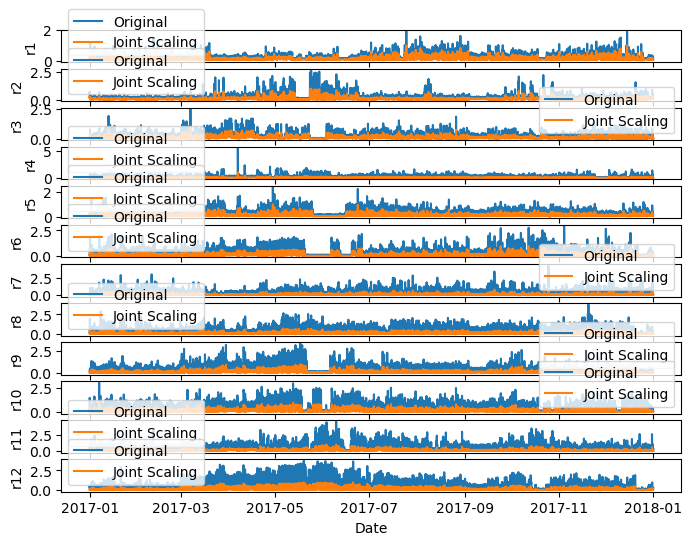

In [20]:
fig, axes = plt.subplots(len(time_series_cols), 1, figsize=(8, 6))
#comparison plot
for i, col in enumerate(time_series_cols):
    axes[i].plot(df['Time'], df_r[col], label='Original')
    #axes[i].plot(df['Time'], df_individual_scaled[col], label='Individual Scaling')
    axes[i].plot(df['Time'], df_joint_scaled[col], label='Joint Scaling')
    axes[i].set_ylabel(col)
    axes[i].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

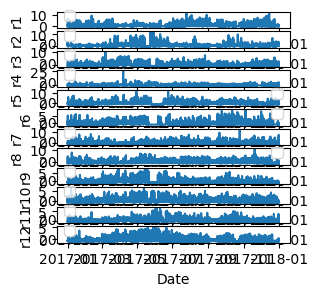

In [21]:
fig, axes = plt.subplots(len(time_series_cols), 1, figsize=(3, 3))
#individual scaling plot
for i, col in enumerate(time_series_cols):
    #axes[i].plot(df['Time'], df_r[col], label='Original')
    axes[i].plot(df['Time'], df_individual_scaled[col])#individual scaling
    #axes[i].plot(df['Time'], df_joint_scaled[col], label='Joint Scaling')
    axes[i].set_ylabel(col)
    axes[i].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

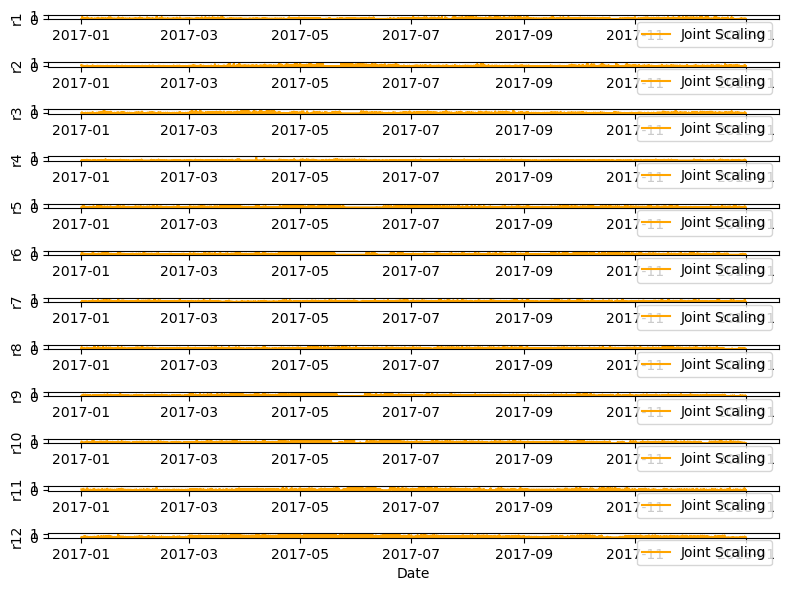

In [22]:
fig, axes = plt.subplots(len(time_series_cols), 1, figsize=(8, 6))
#joint scaling plot
for i, col in enumerate(time_series_cols):
    #axes[i].plot(df['Time'], df_r[col], label='Original')
    #axes[i].plot(df['Time'], df_individual_scaled[col], label='Individual Scaling')
    axes[i].plot(df['Time'], df_joint_scaled[col], label='Joint Scaling',color = 'orange')
    axes[i].set_ylabel(col)
    axes[i].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [23]:
df_monthly = df_r.resample('M').mean()
df_seasonal = df_r.resample('4M').mean()
df_hourly = df_r.resample('H').mean()
df_daily = df_r.resample('D').mean()

In [24]:
#GOING AHEAD WITH JOINT SCALING 

In [25]:
#SCALING ON DAILY,HOURLY, MONTHLY AND SEASONAL DATA
time_series_cols = df_r.columns
scaler = MinMaxScaler()
df_hourly[time_series_cols] = scaler.fit_transform(df_hourly[time_series_cols])
df_daily[time_series_cols] = scaler.fit_transform(df_daily[time_series_cols])
df_monthly[time_series_cols] = scaler.fit_transform(df_monthly[time_series_cols])
df_seasonal[time_series_cols] = scaler.fit_transform(df_seasonal[time_series_cols])
df_r[time_series_cols] = scaler.fit_transform(df_r[time_series_cols])



In [26]:
#SCALING ON DAILY,HOURLY, MONTHLY AND SEASONAL DATA
time_series_cols = df_r.columns
scaler = MinMaxScaler()
df_hourly[time_series_cols] = scaler.fit_transform(df_hourly[time_series_cols])
df_daily[time_series_cols] = scaler.fit_transform(df_daily[time_series_cols])
df_monthly[time_series_cols] = scaler.fit_transform(df_monthly[time_series_cols])
df_seasonal[time_series_cols] = scaler.fit_transform(df_seasonal[time_series_cols])




In [27]:
#CHECKING CORRELATION BETWEEN FEATURES
corr_df1= df.corr(method='spearman')
corr_df2= df.corr(method = 'pearson')
corr_df = df.corr()
corr_df1 ,corr_df2,corr_df

C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_12188\3434016129.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df1= df.corr(method='spearman')
C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_12188\3434016129.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df2= df.corr(method = 'pearson')
C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_12188\3434016129.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df.corr()


(          year  moy_date  doy_date    busday  dow_date      hour      temp  \
 year       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
 moy_date   NaN  1.000000  0.996517 -0.003418  0.012405  0.000000 -0.026994   
 doy_date   NaN  0.996517  1.000000 -0.003965  0.011799  0.000000 -0.024701   
 busday     NaN -0.003418 -0.003965  1.000000  0.009958  0.000000  0.022278   
 dow_date   NaN  0.012405  0.011799  0.009958  1.000000  0.000000 -0.001748   
 hour       NaN  0.000000  0.000000  0.000000  0.000000  1.000000 -0.181418   
 temp       NaN -0.026994 -0.024701  0.022278 -0.001748 -0.181418  1.000000   
 humid      NaN  0.193517  0.190438 -0.001273  0.006772  0.115634 -0.284272   
 r1         NaN  0.118497  0.113797 -0.024419 -0.006005 -0.352660  0.103123   
 r2         NaN  0.069876  0.066585  0.044314  0.026005  0.056236  0.133909   
 r3         NaN -0.099413 -0.103874  0.009901  0.003530 -0.188792  0.227132   
 r4         NaN -0.117655 -0.120223  0.001699 -0.033

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5]),
 [Text(0, 0.5, 'year'),
  Text(0, 1.5, 'moy_date'),
  Text(0, 2.5, 'doy_date'),
  Text(0, 3.5, 'busday'),
  Text(0, 4.5, 'dow_date'),
  Text(0, 5.5, 'hour'),
  Text(0, 6.5, 'temp'),
  Text(0, 7.5, 'humid'),
  Text(0, 8.5, 'r1'),
  Text(0, 9.5, 'r2'),
  Text(0, 10.5, 'r3'),
  Text(0, 11.5, 'r4'),
  Text(0, 12.5, 'r5'),
  Text(0, 13.5, 'r6'),
  Text(0, 14.5, 'r7'),
  Text(0, 15.5, 'r8'),
  Text(0, 16.5, 'r9'),
  Text(0, 17.5, 'r10'),
  Text(0, 18.5, 'r11'),
  Text(0, 19.5, 'r12')])

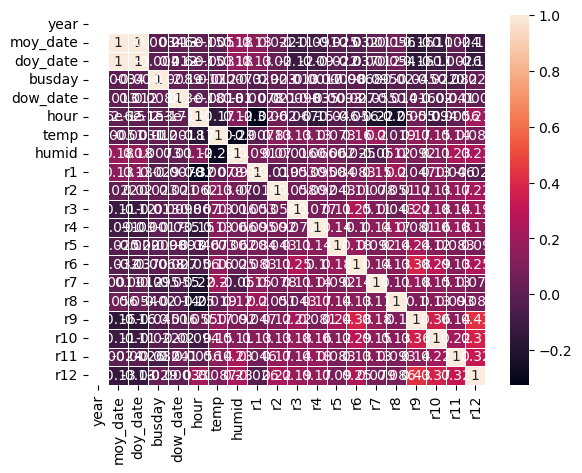

In [28]:
sns.heatmap(corr_df,
           annot=True,
           linewidths=0.4,
           annot_kws={'size': 10})

plt.xticks(rotation=90)
plt.yticks(rotation=0)

In [29]:
corr_df = df_r.corr(method='spearman')
corr_df

r1        r2        r3        r4        r5        r6        r7  \
r1   1.000000  0.020276  0.203566  0.242937  0.166368  0.270164  0.262406   
r2   0.020276  1.000000  0.088960  0.084301  0.062803  0.064104  0.091299   
r3   0.203566  0.088960  1.000000  0.275936  0.263197  0.381039  0.320989   
r4   0.242937  0.084301  0.275936  1.000000  0.233736  0.266369  0.372888   
r5   0.166368  0.062803  0.263197  0.233736  1.000000  0.294430  0.193527   
r6   0.270164  0.064104  0.381039  0.266369  0.294430  1.000000  0.279573   
r7   0.262406  0.091299  0.320989  0.372888  0.193527  0.279573  1.000000   
r8   0.318295  0.018638  0.199453  0.333043  0.262202  0.264802  0.263975   
r9   0.182206  0.066514  0.366380  0.216278  0.371469  0.376398  0.313600   
r10  0.274985  0.111256  0.305214  0.295383  0.234253  0.355579  0.306950   
r11  0.193267  0.169391  0.254476  0.294713  0.160801  0.227850  0.275091   
r12  0.084133  0.156624  0.202714  0.167494  0.203073  0.126941  0.154812   

           r8        r9       r10       r11       r12  
r1   0.318295  0.182206  0.274985  0.193267  0.084133  
r2   0.018638  0.066514  0.111256  0.169391  0.156624  
r3   0.199453  0.366380  0.305214  0.254476  0.202714  
r4   0.333043  0.216278  0.295383  0.294713  0.167494  
r5   0.262202  0.371469  0.234253  0.160801  0.203073  
r6   0.264802  0.376398  0.355579  0.227850  0.126941  
r7   0.263975  0.313600  0.306950  0.275091  0.154812  
r8   1.000000  0.206062  0.238498  0.217309  0.154095  
r9   0.206062  1.000000  0.359313  0.253298  0.331279  
r10  0.238498  0.359313  1.000000  0.266007  0.253201  
r11  0.217309  0.253298  0.266007  1.000000  0.286666  
r12  0.154095  0.331279  0.253201  0.286666  1.000000

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, 'r1'),
  Text(0, 1.5, 'r2'),
  Text(0, 2.5, 'r3'),
  Text(0, 3.5, 'r4'),
  Text(0, 4.5, 'r5'),
  Text(0, 5.5, 'r6'),
  Text(0, 6.5, 'r7'),
  Text(0, 7.5, 'r8'),
  Text(0, 8.5, 'r9'),
  Text(0, 9.5, 'r10'),
  Text(0, 10.5, 'r11'),
  Text(0, 11.5, 'r12')])

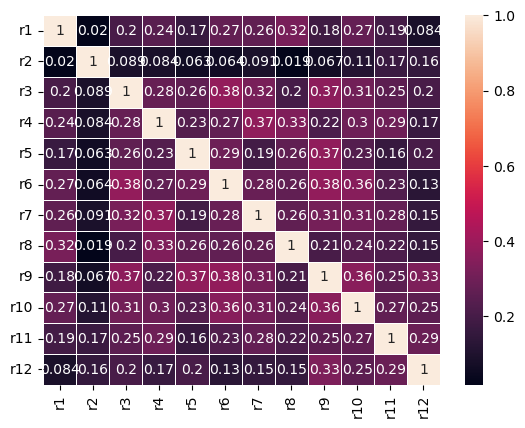

In [30]:
#heatmap
sns.heatmap(corr_df,
           annot=True,
           linewidths=0.4,
           annot_kws={'size': 10})

plt.xticks(rotation=90)
plt.yticks(rotation=0)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, 'r1'),
  Text(0, 1.5, 'r2'),
  Text(0, 2.5, 'r3'),
  Text(0, 3.5, 'r4'),
  Text(0, 4.5, 'r5'),
  Text(0, 5.5, 'r6'),
  Text(0, 6.5, 'r7'),
  Text(0, 7.5, 'r8'),
  Text(0, 8.5, 'r9'),
  Text(0, 9.5, 'r10'),
  Text(0, 10.5, 'r11'),
  Text(0, 11.5, 'r12')])

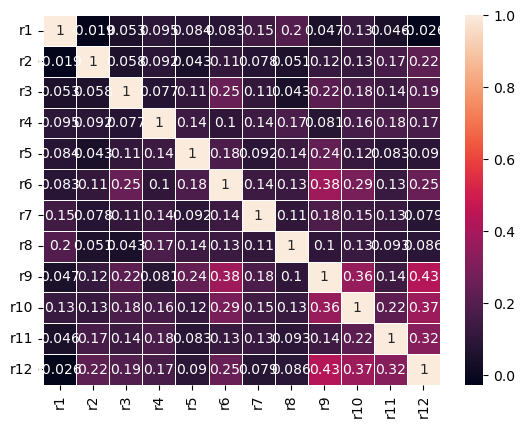

In [31]:
corr2_df = df_r.corr(method = 'pearson')

sns.heatmap(corr2_df,
           annot=True,
           linewidths=0.4,
           annot_kws={'size': 10})

plt.xticks(rotation=90)
plt.yticks(rotation=0)

In [32]:
###DATA VISUALIZATION of the meter readings for seasonal, monthly, daily, and hourly measurements

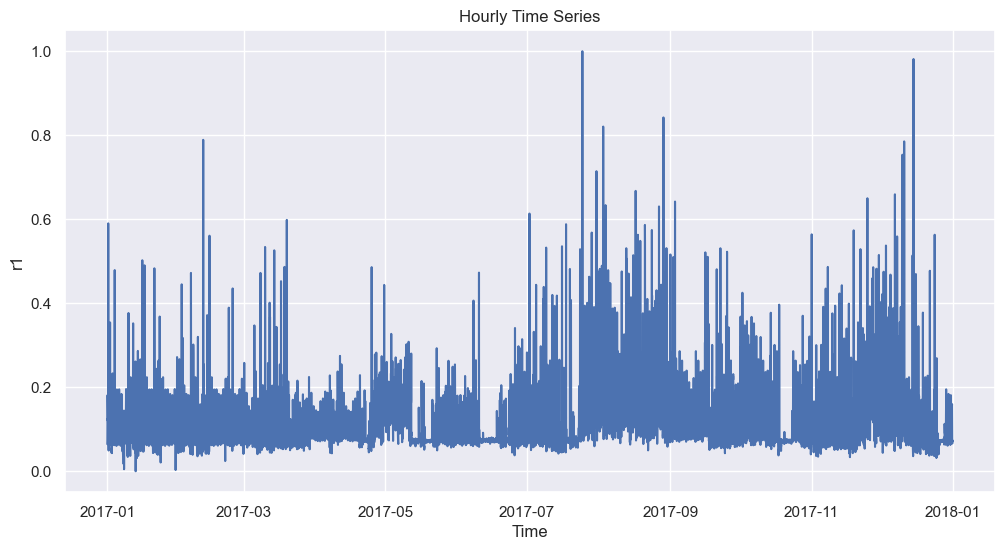

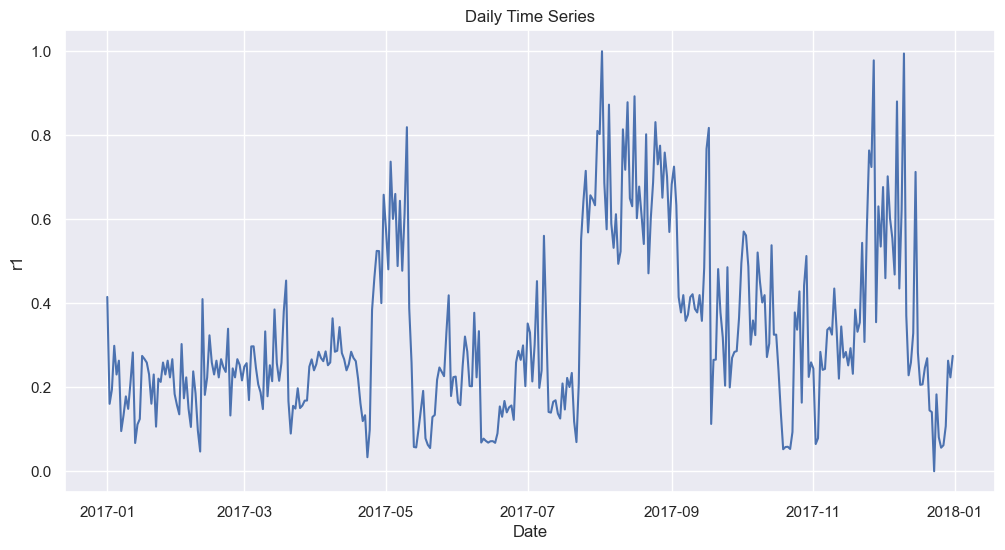

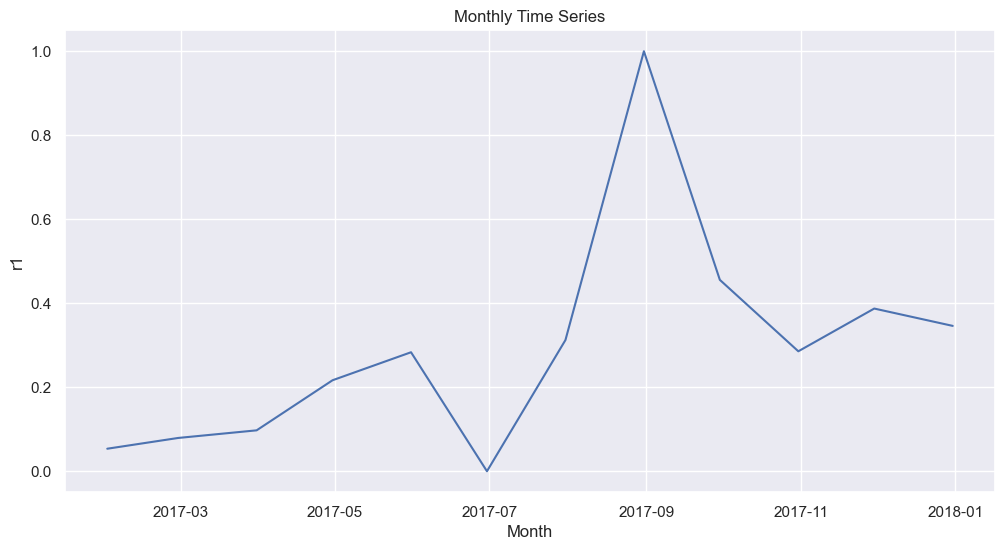

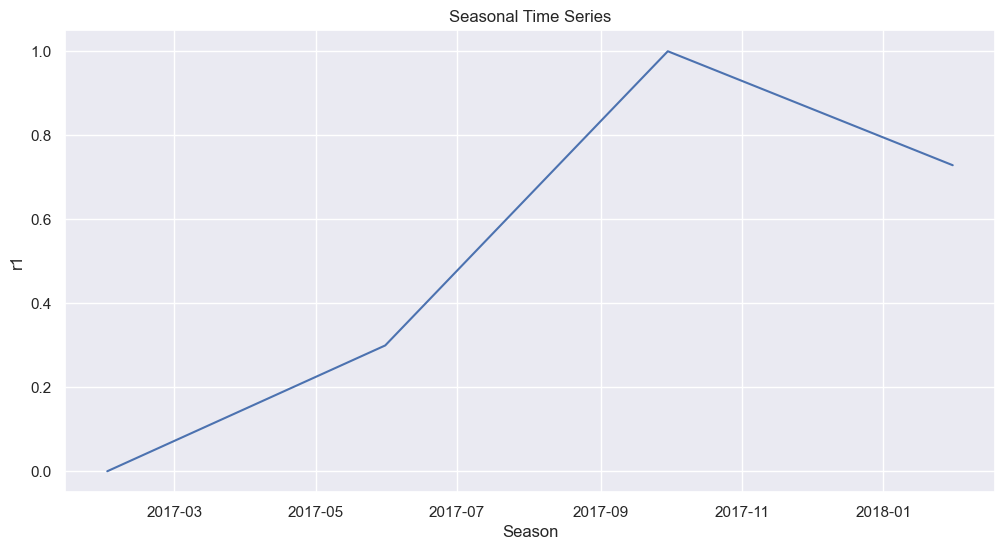

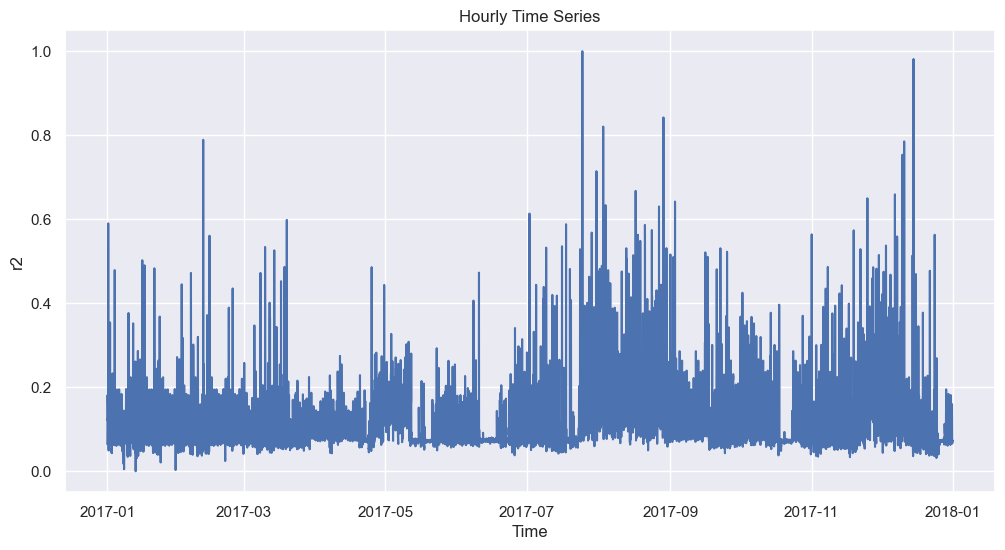

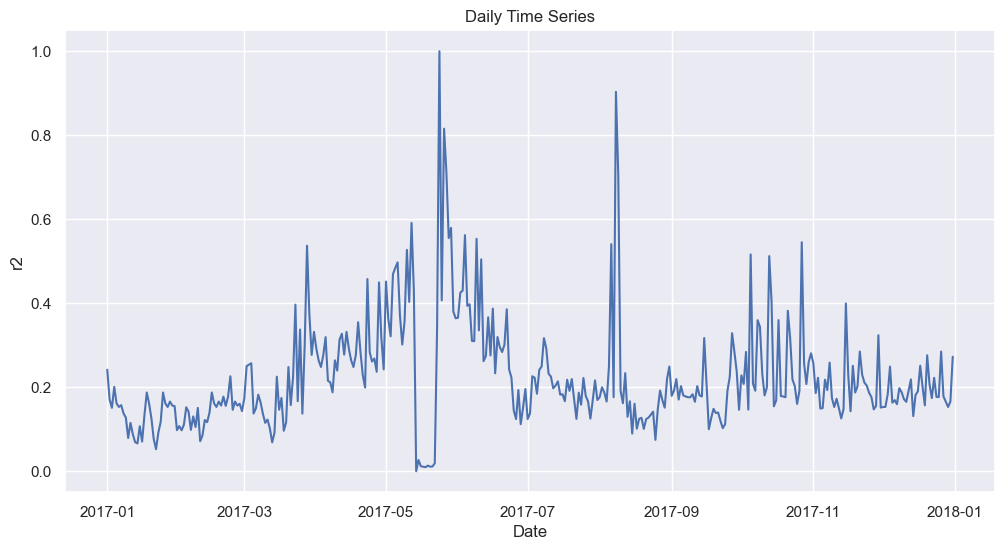

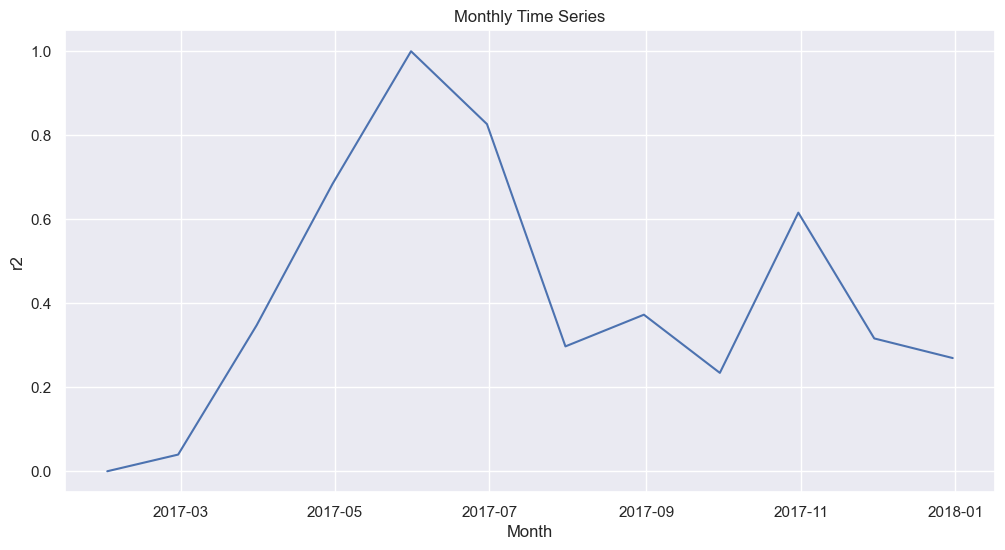

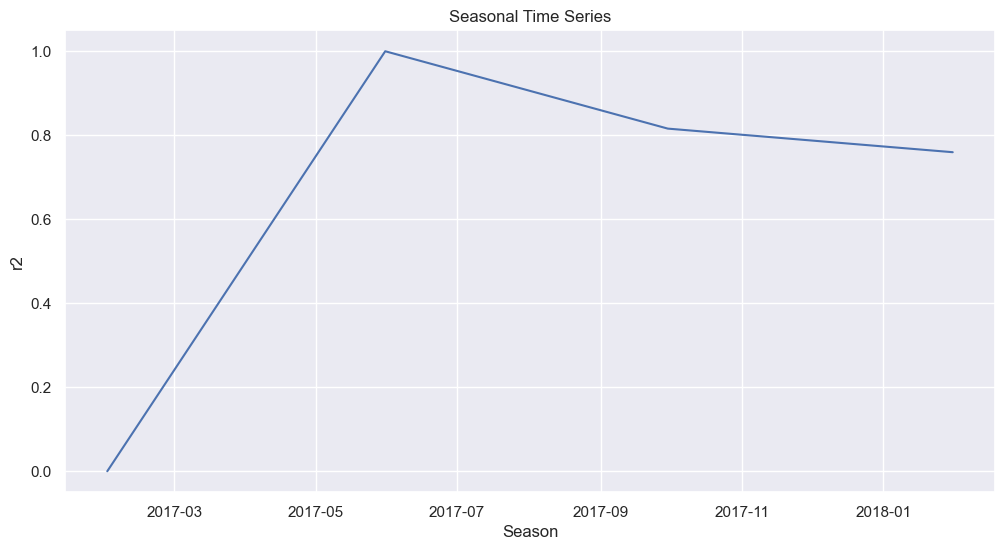

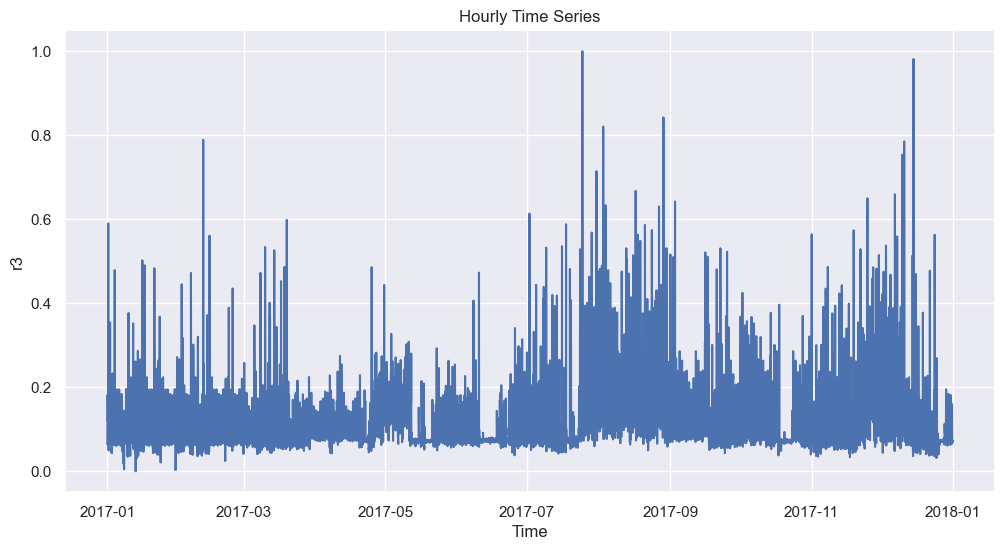

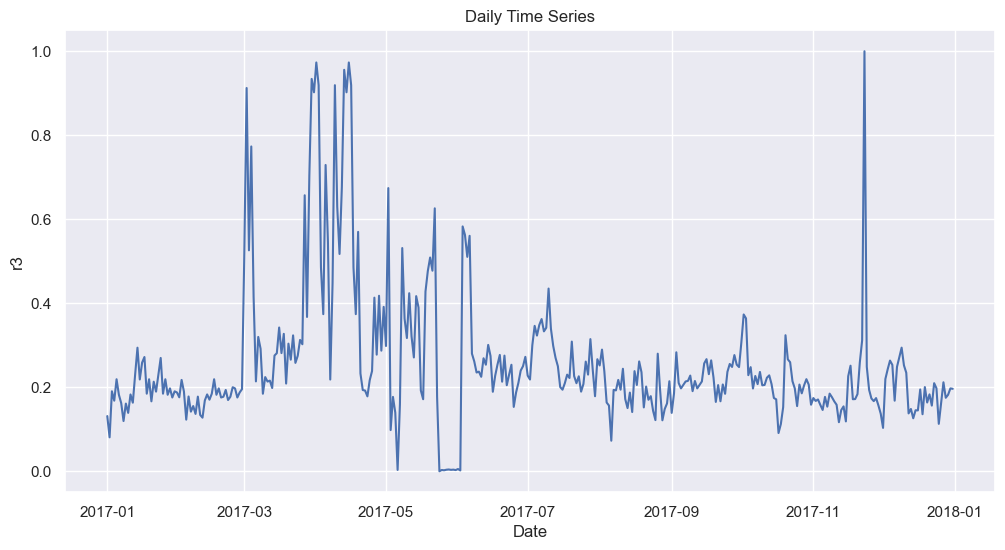

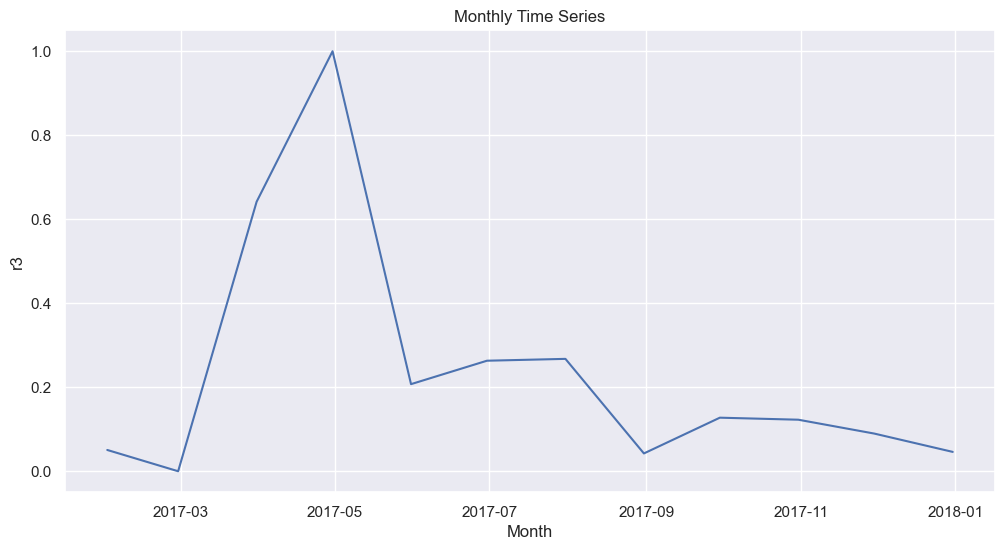

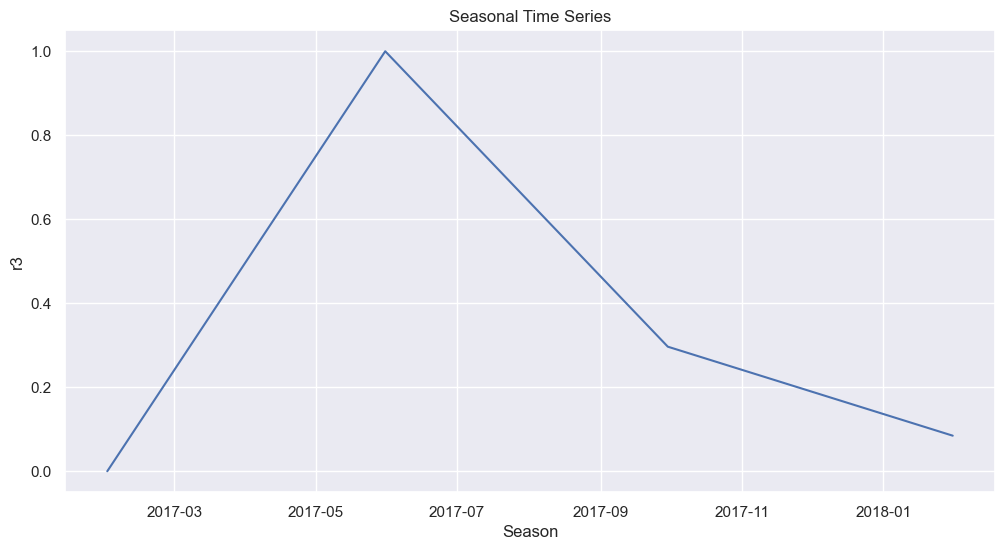

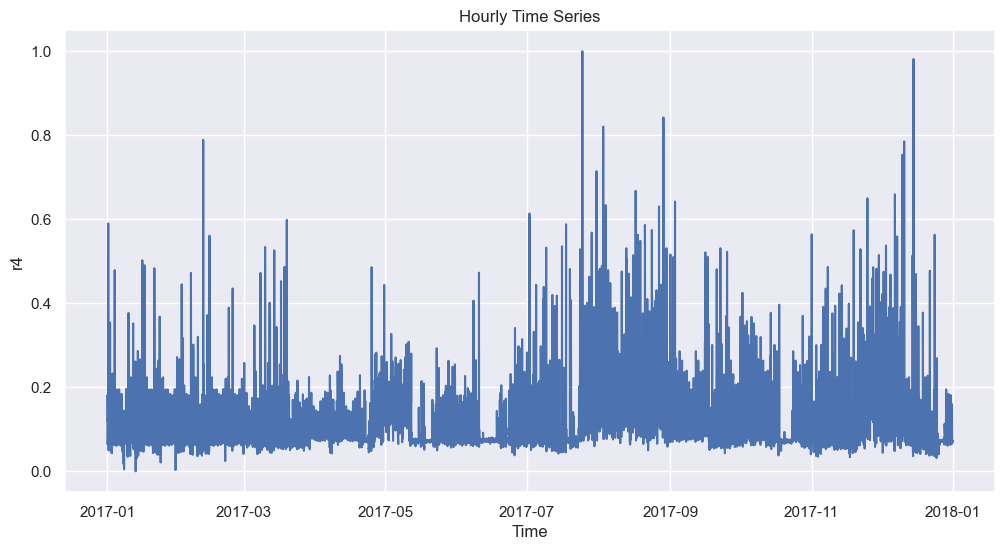

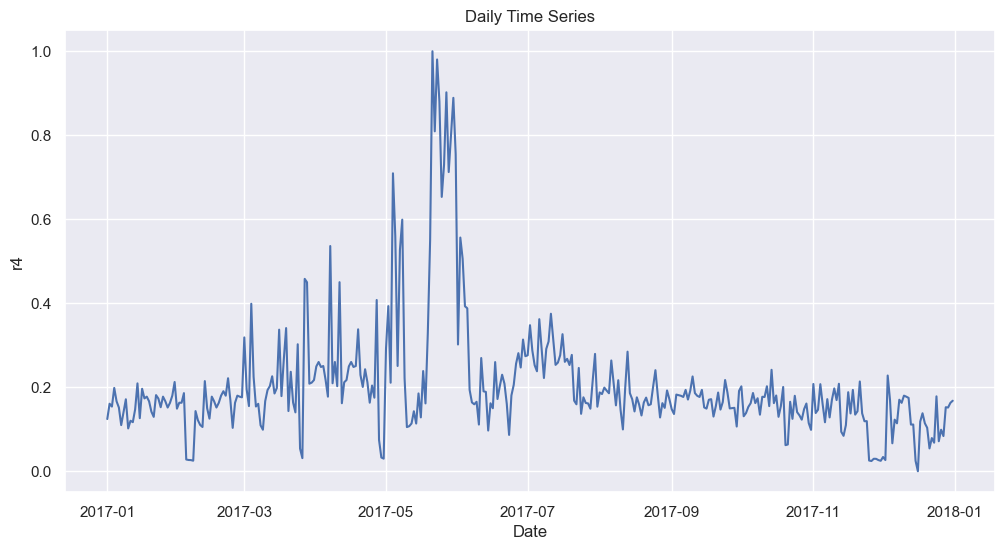

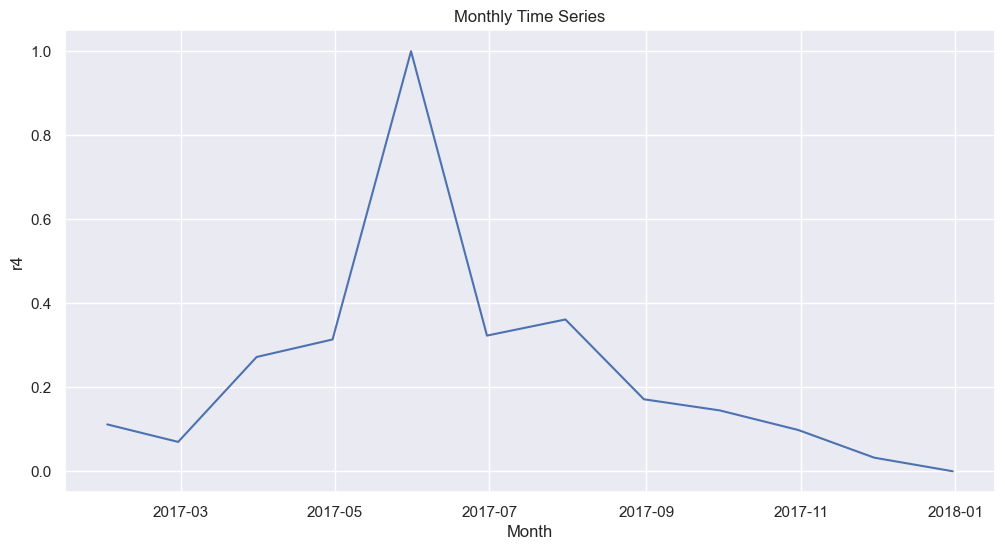

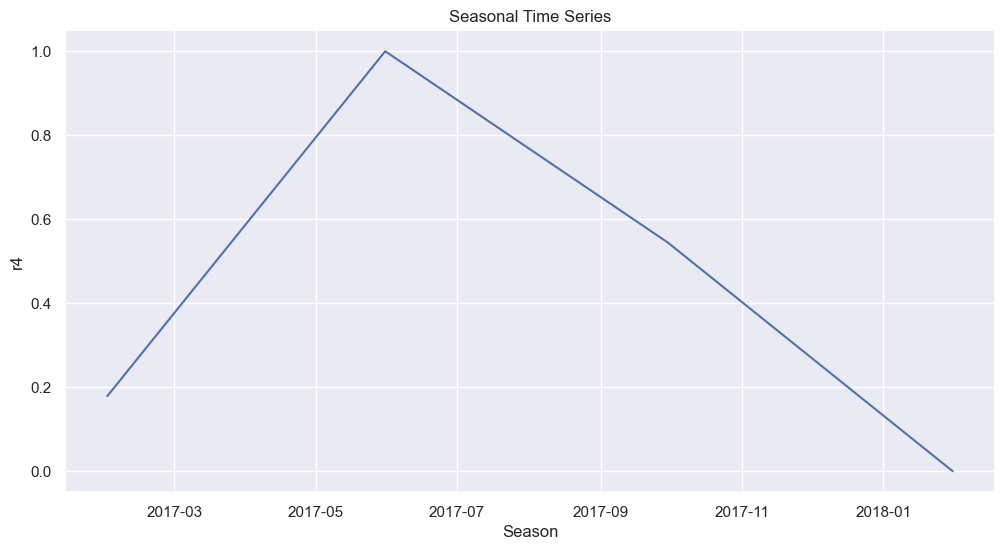

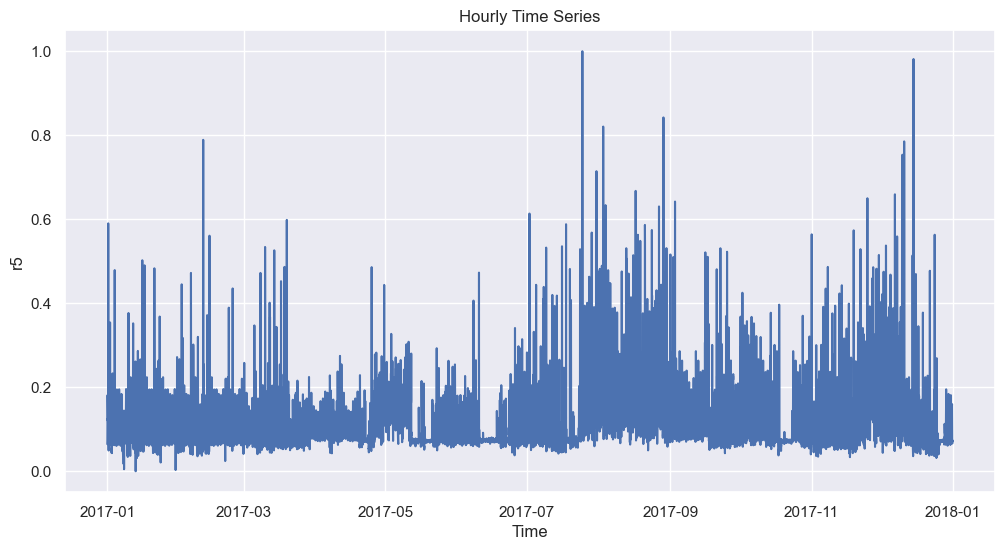

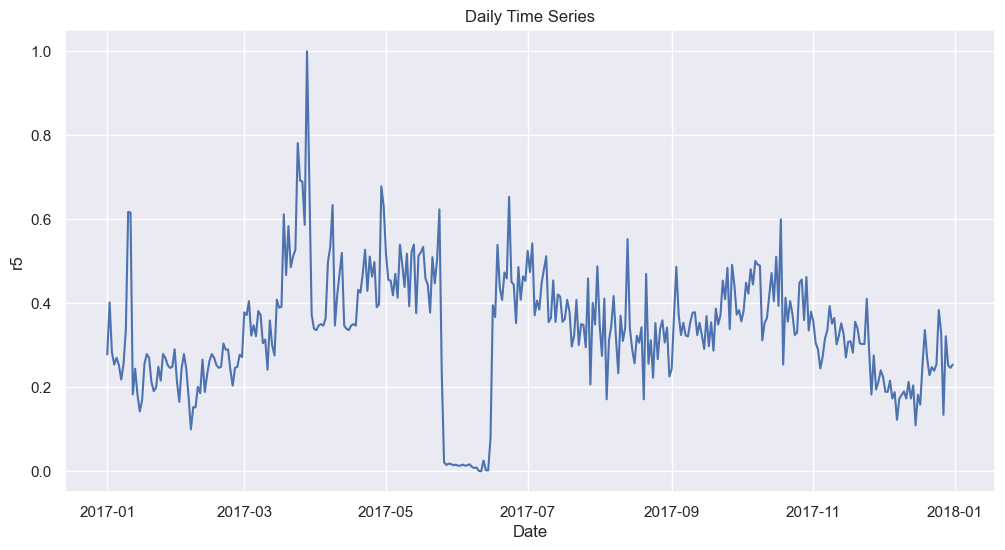

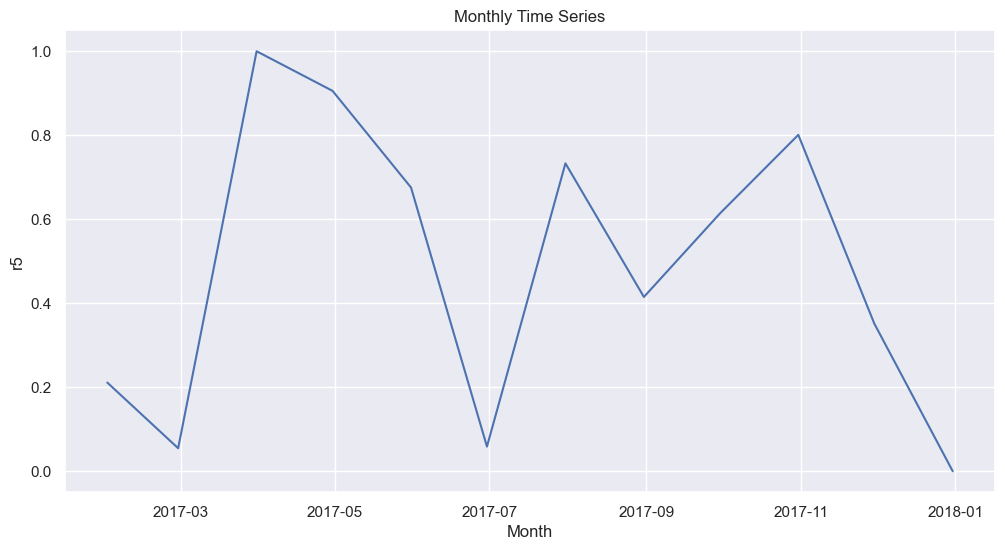

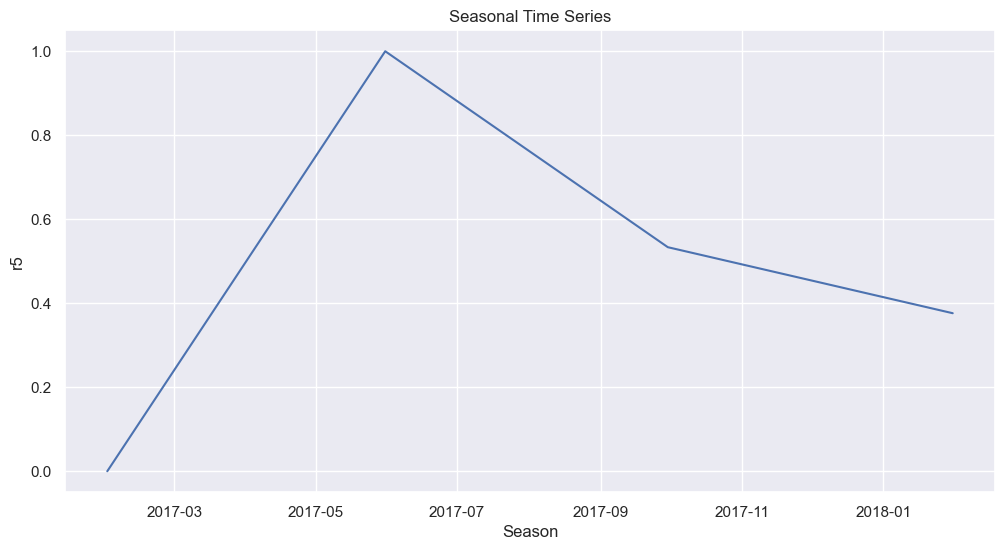

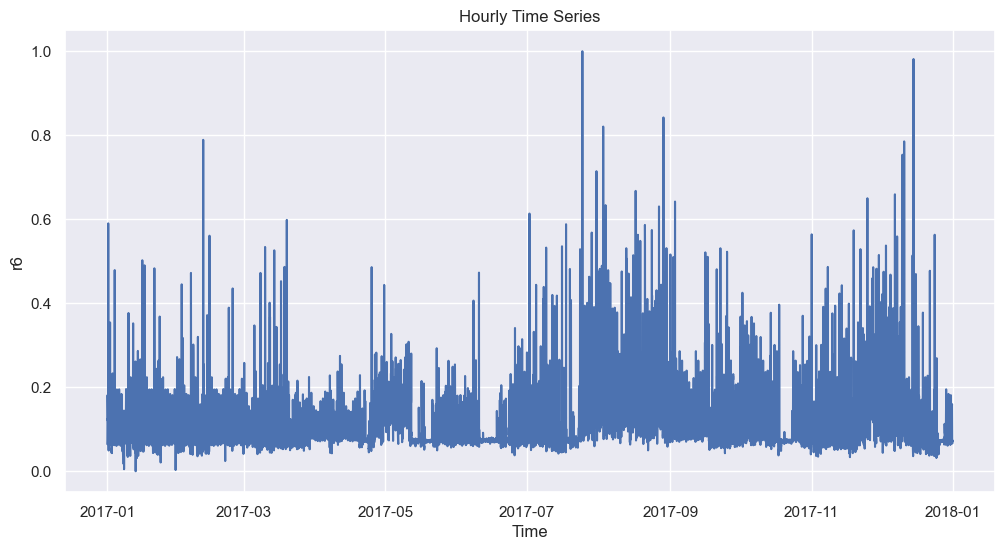

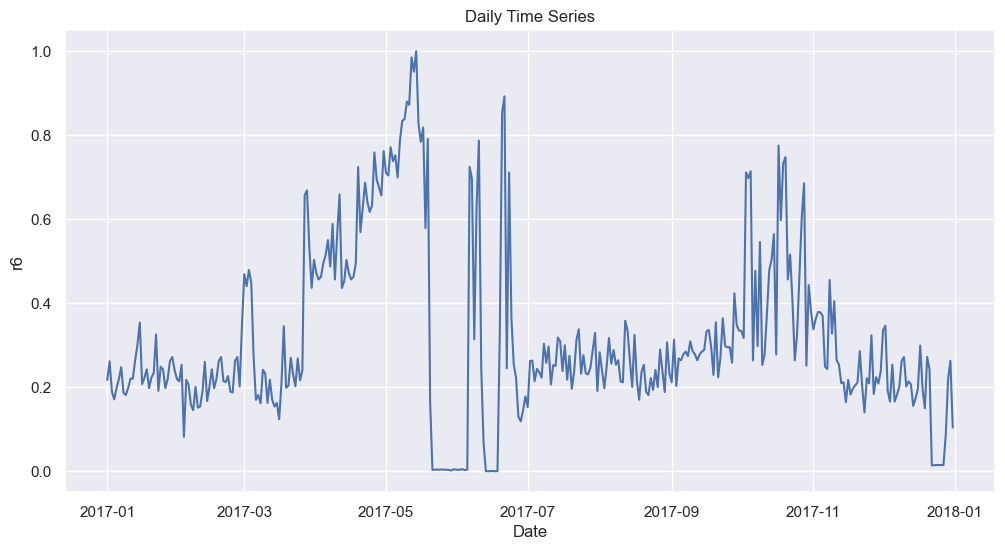

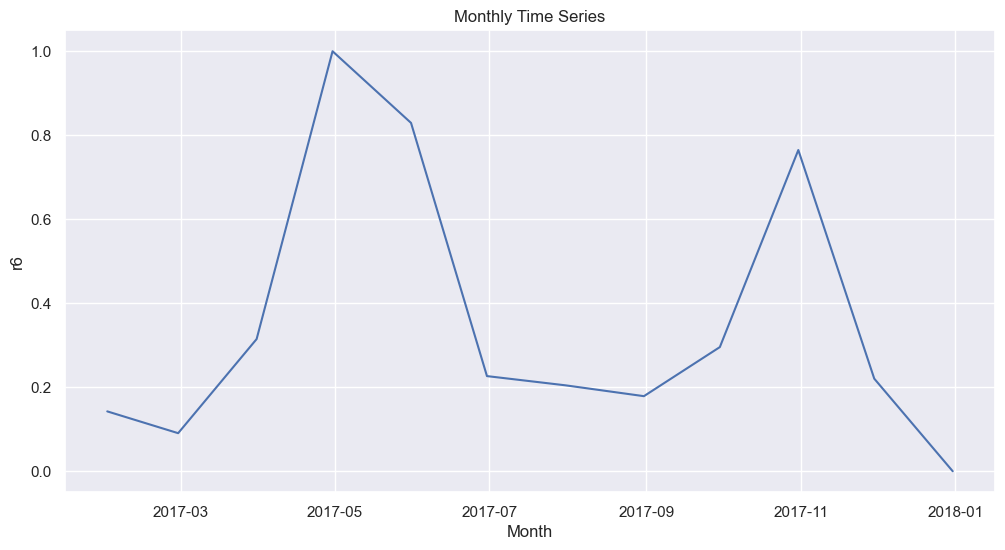

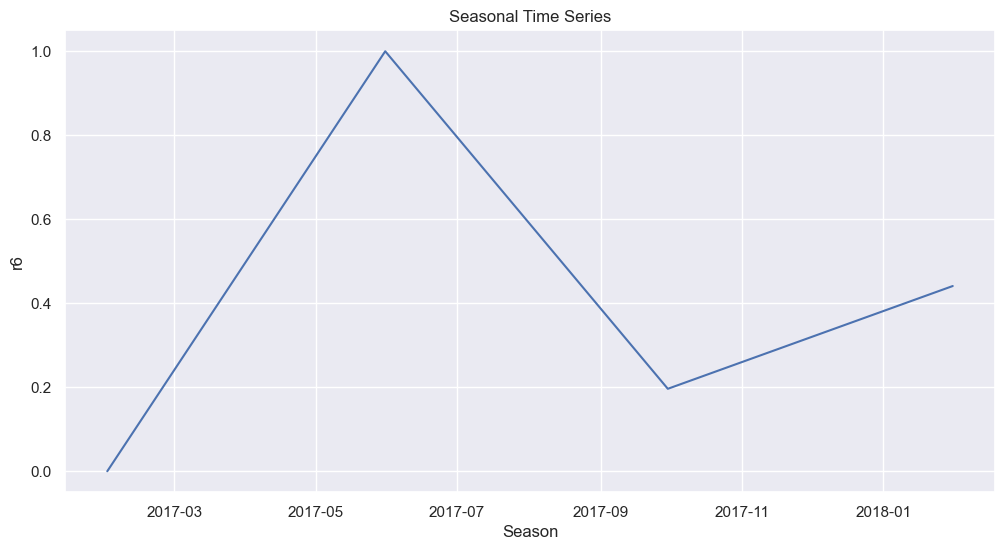

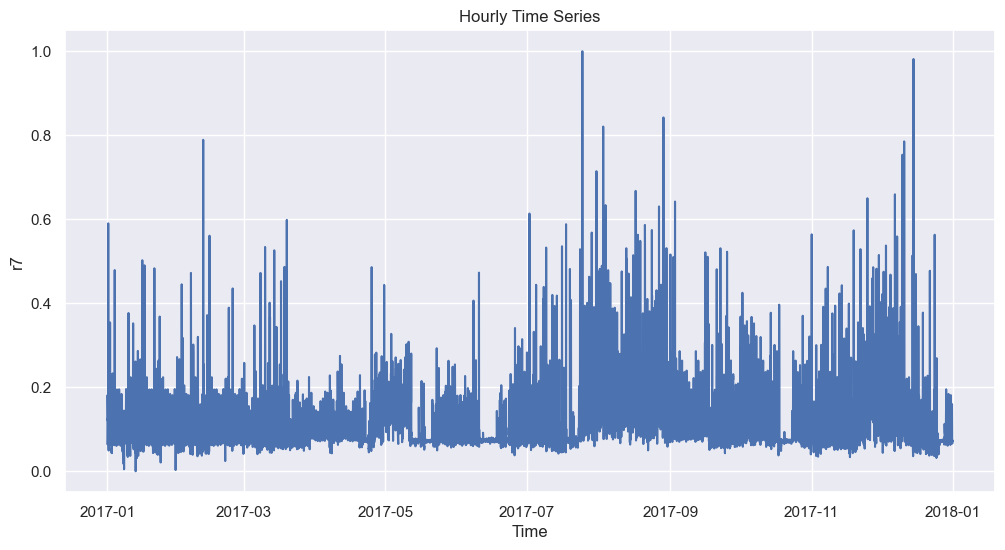

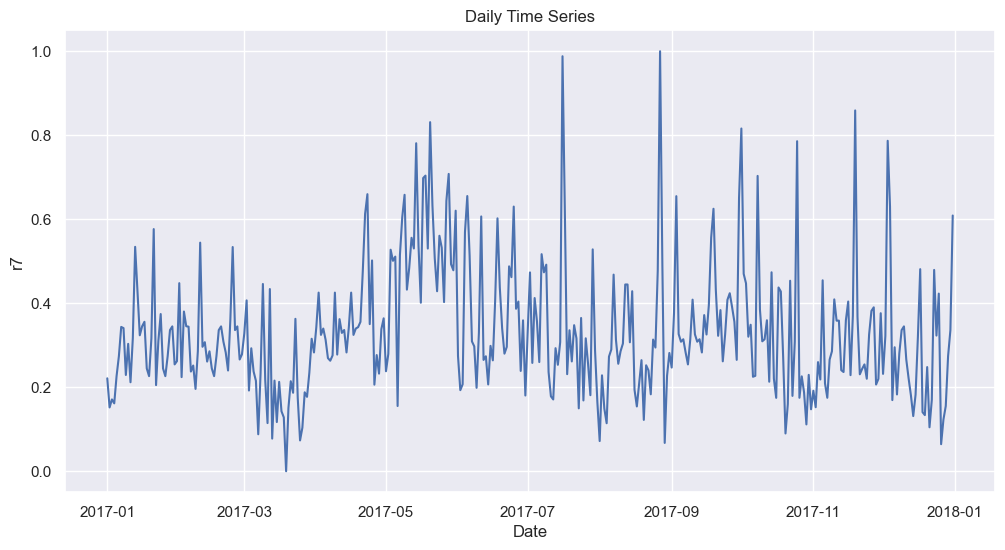

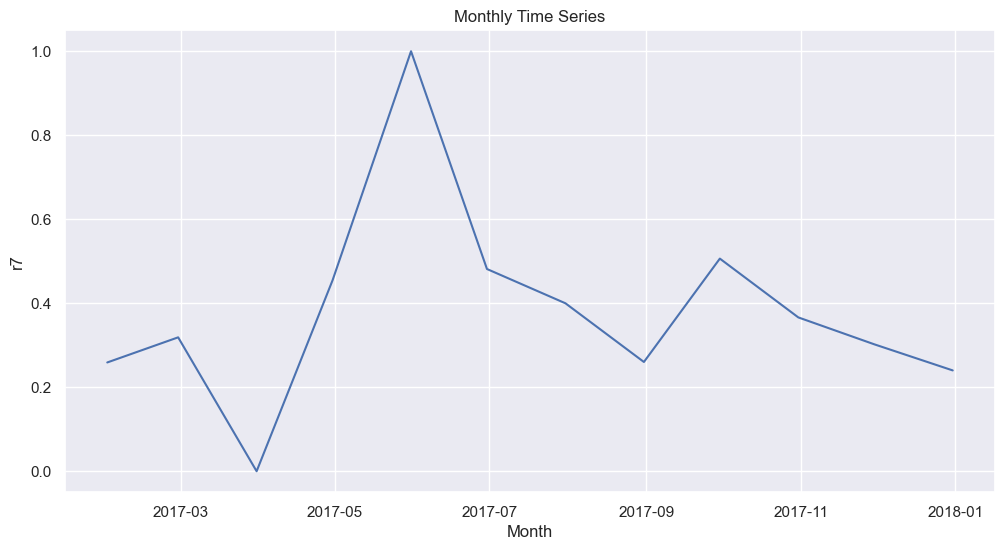

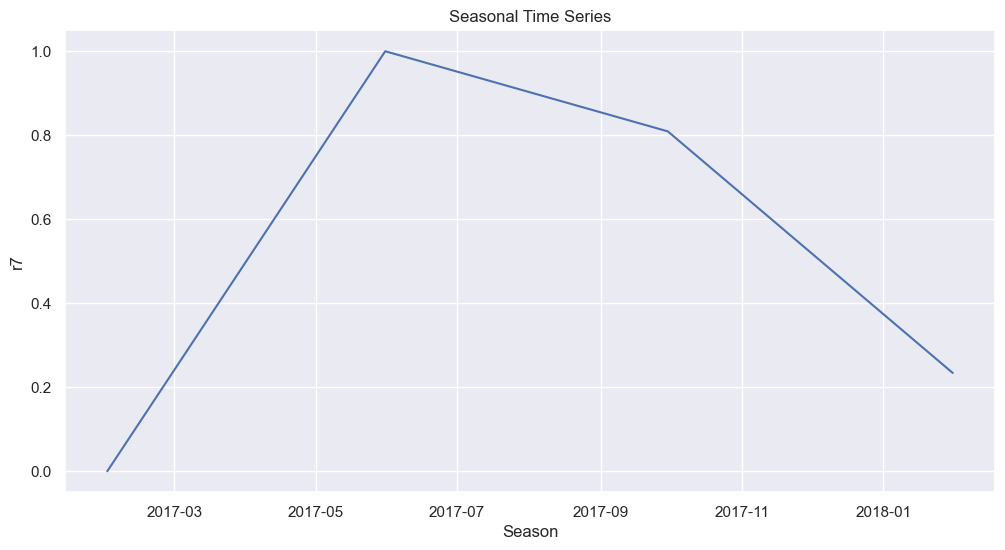

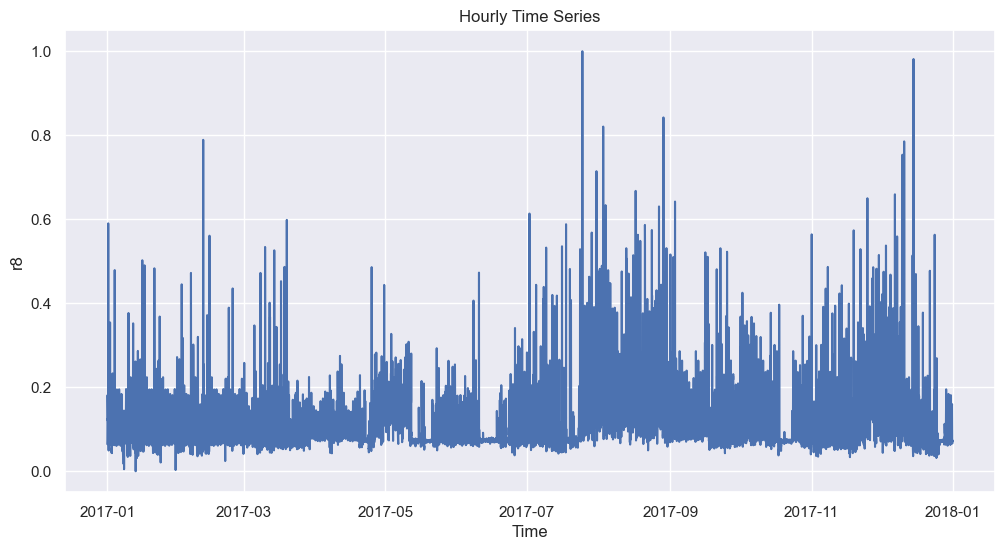

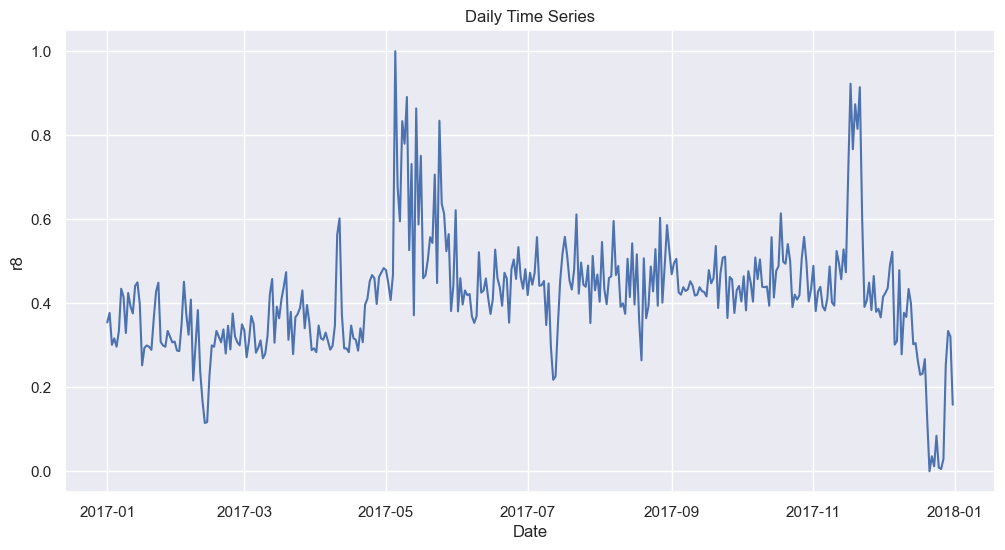

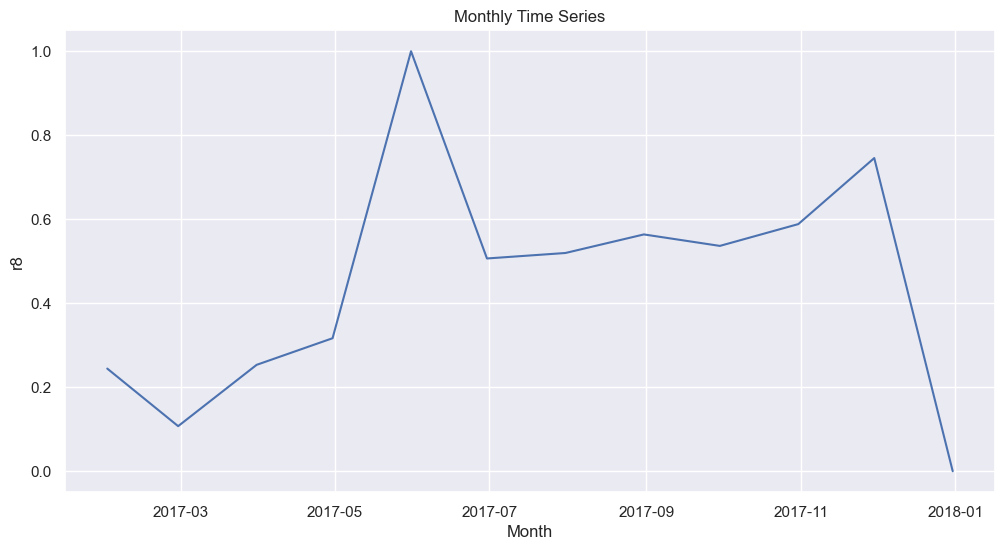

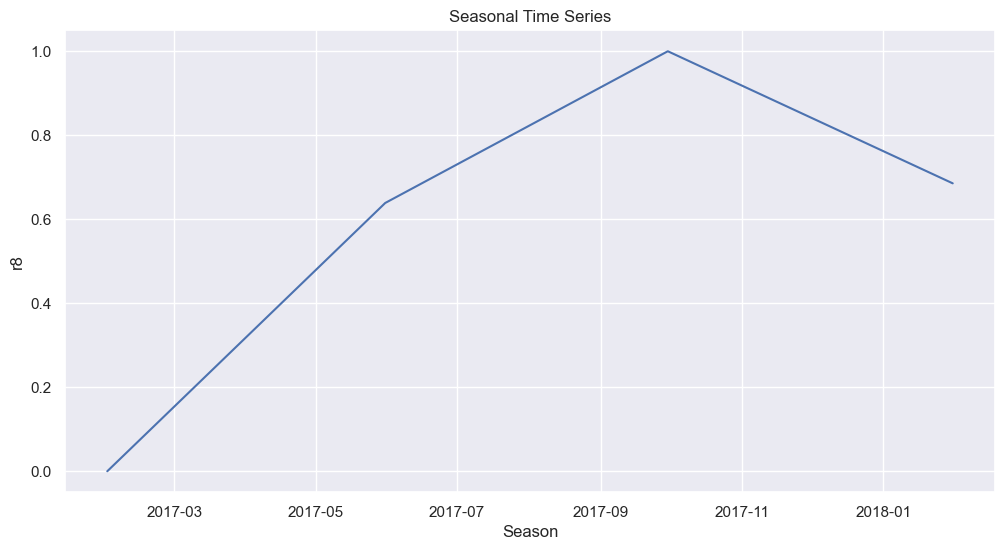

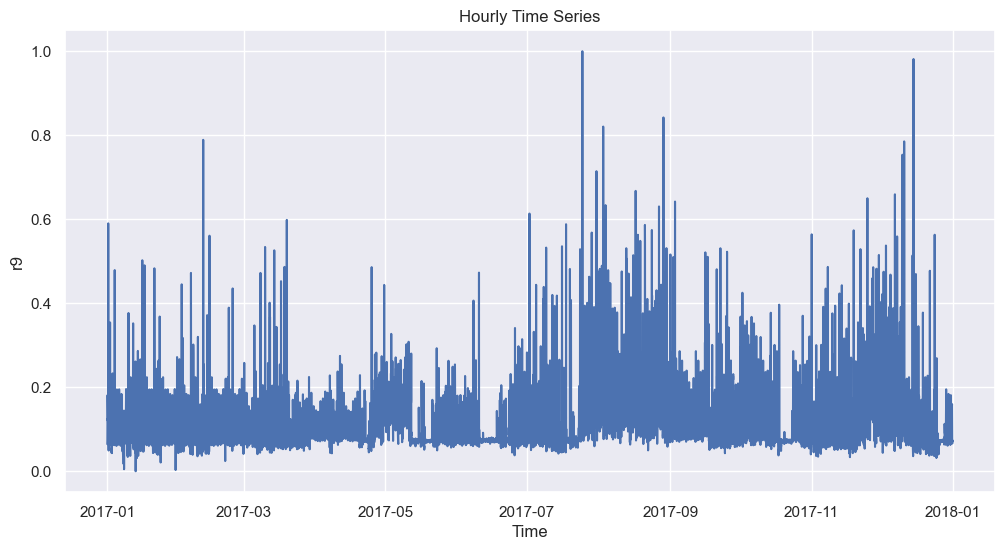

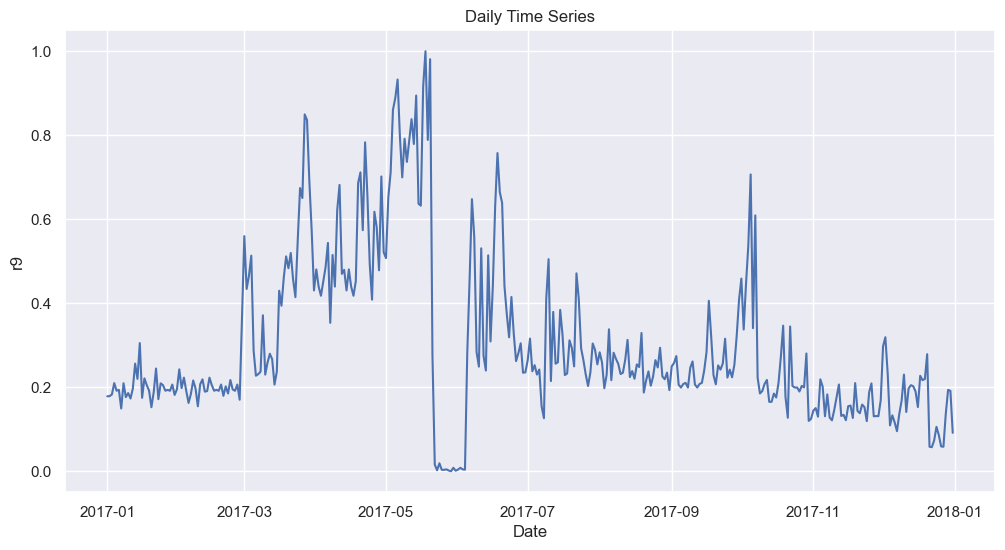

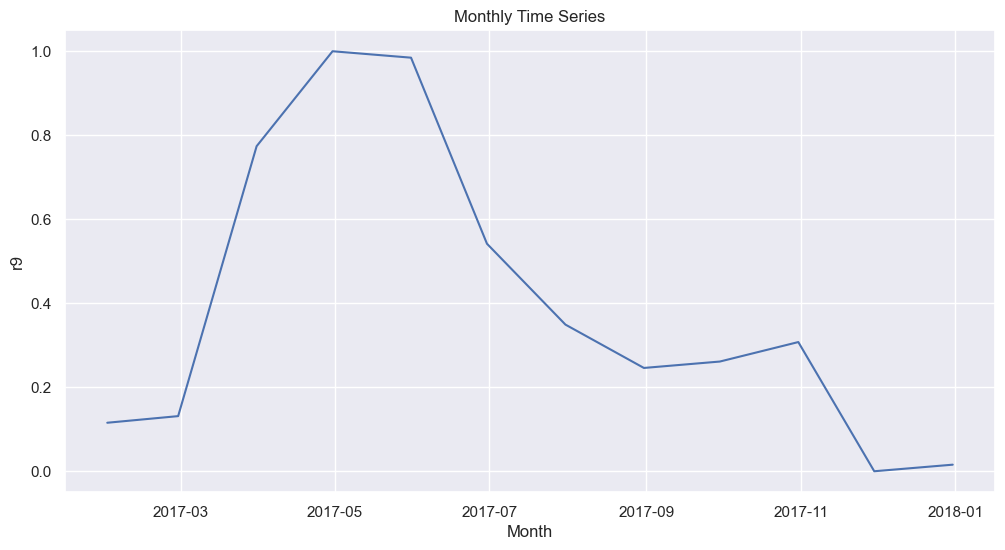

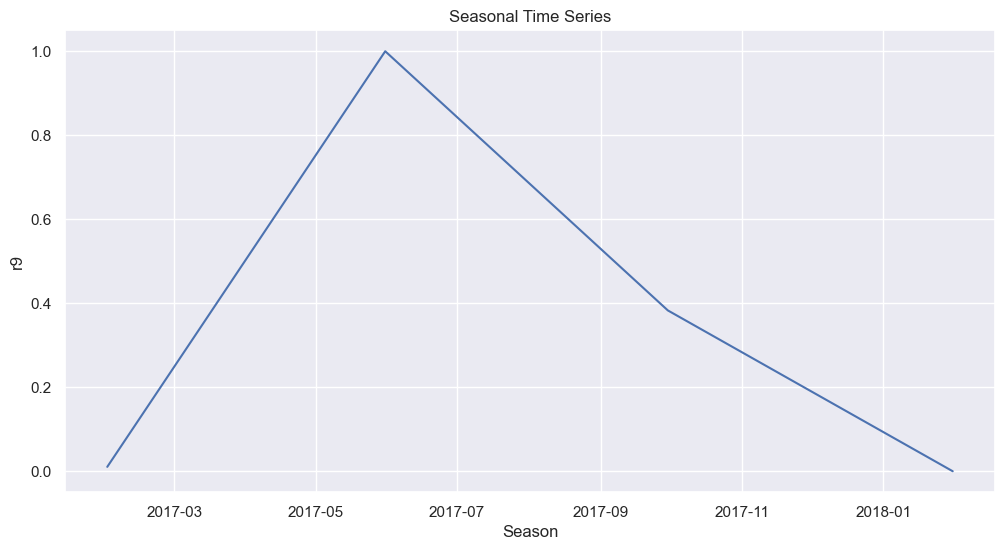

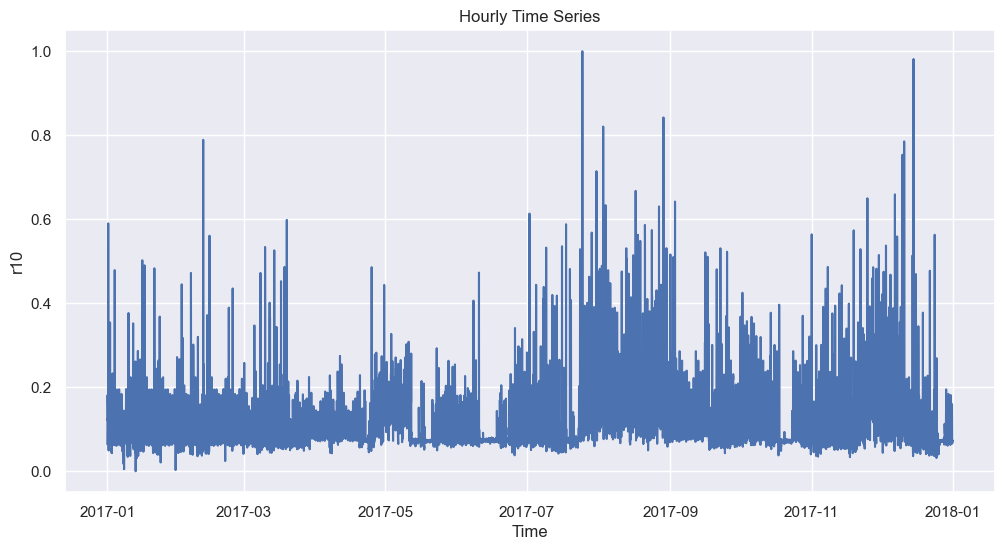

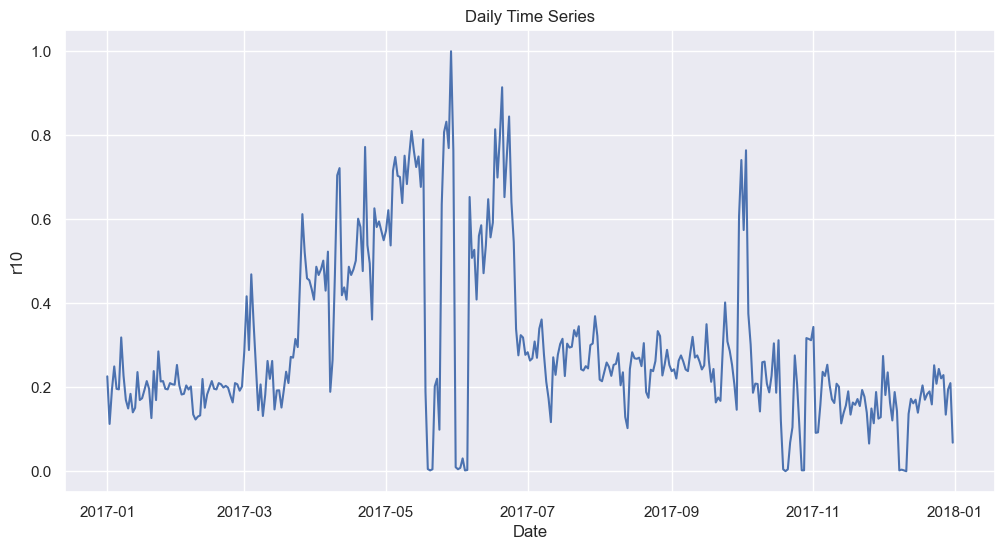

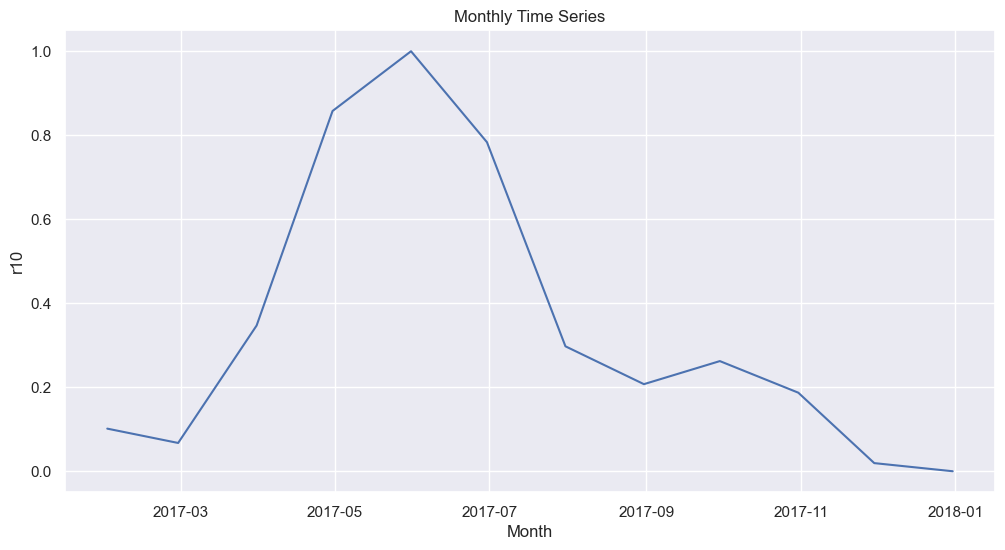

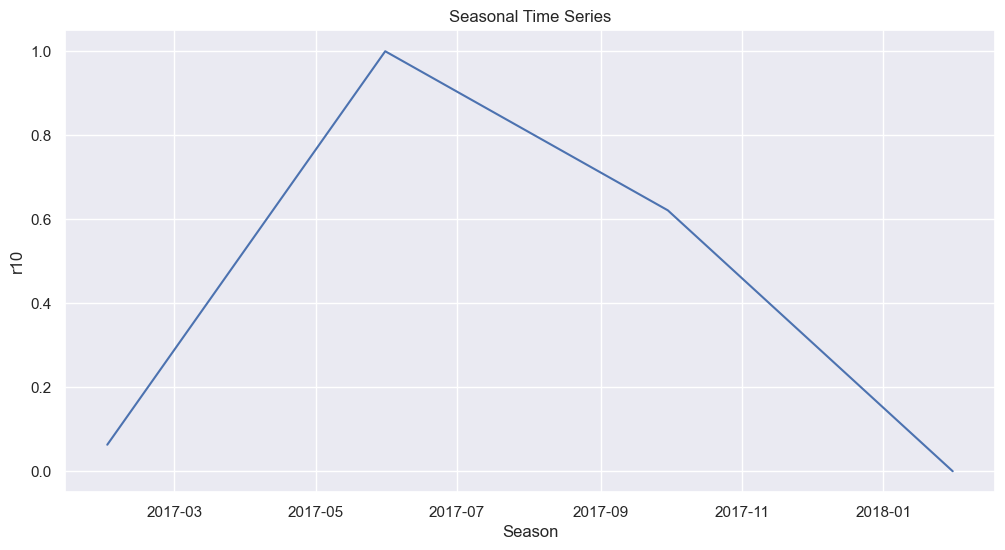

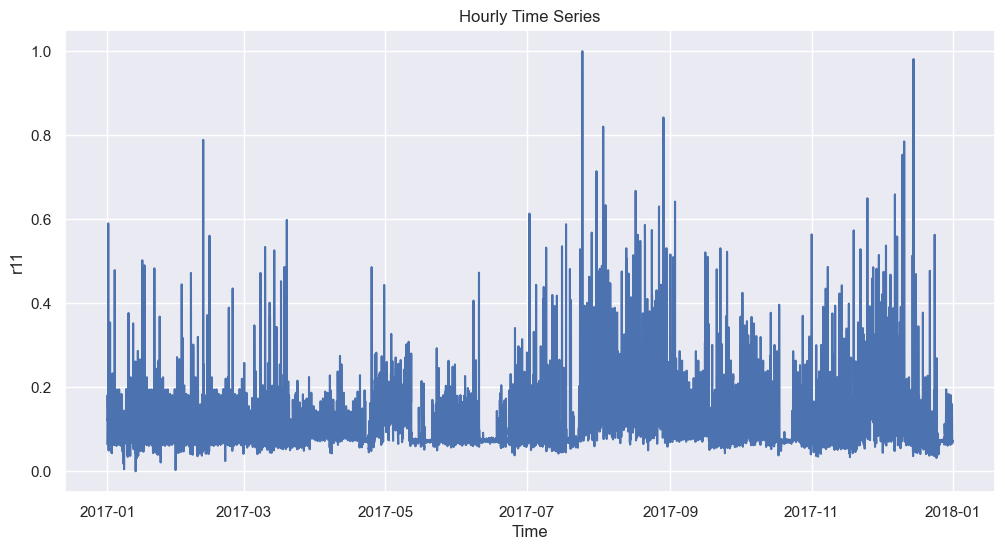

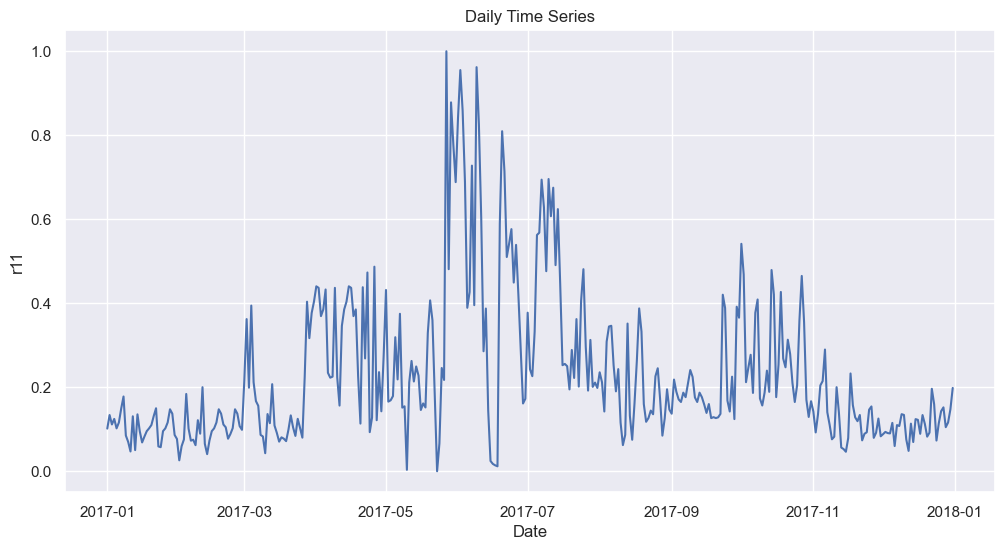

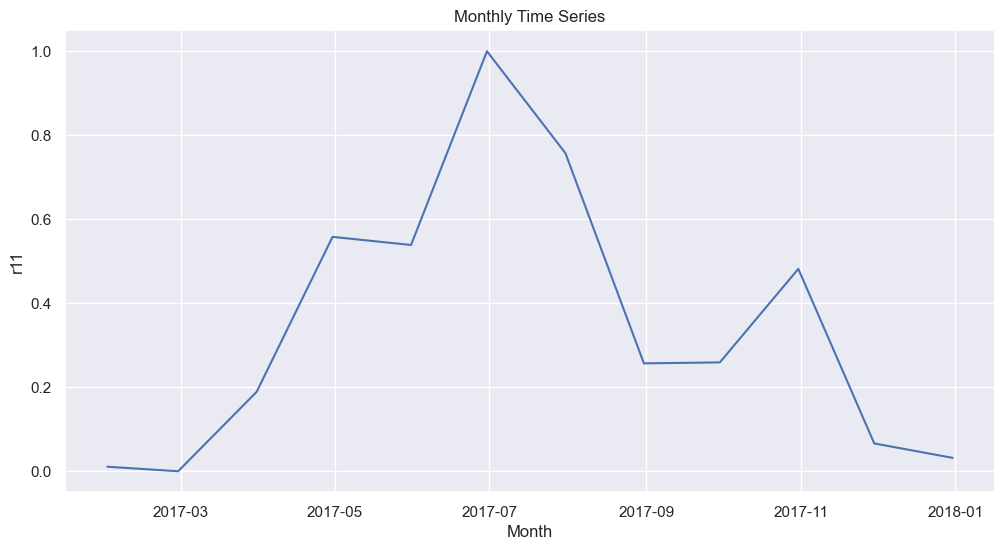

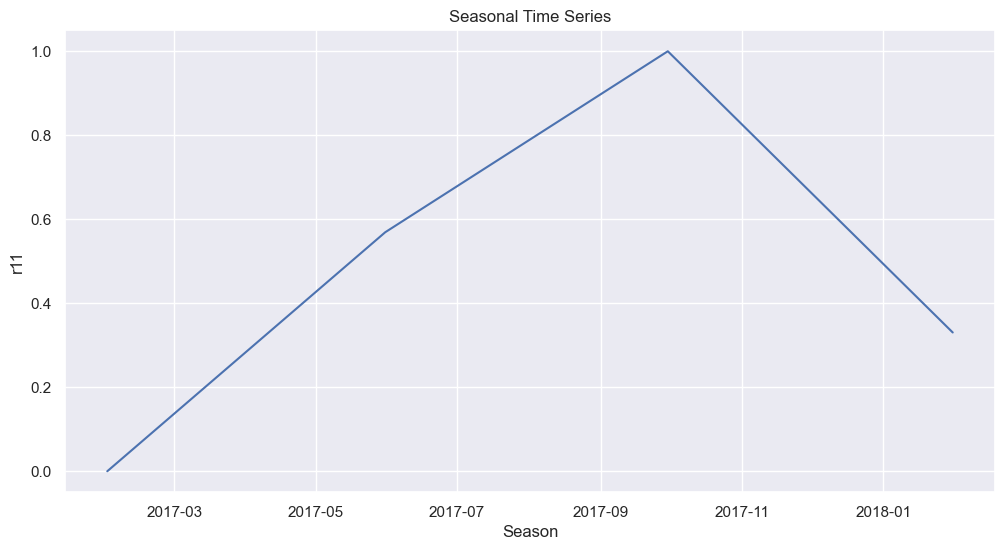

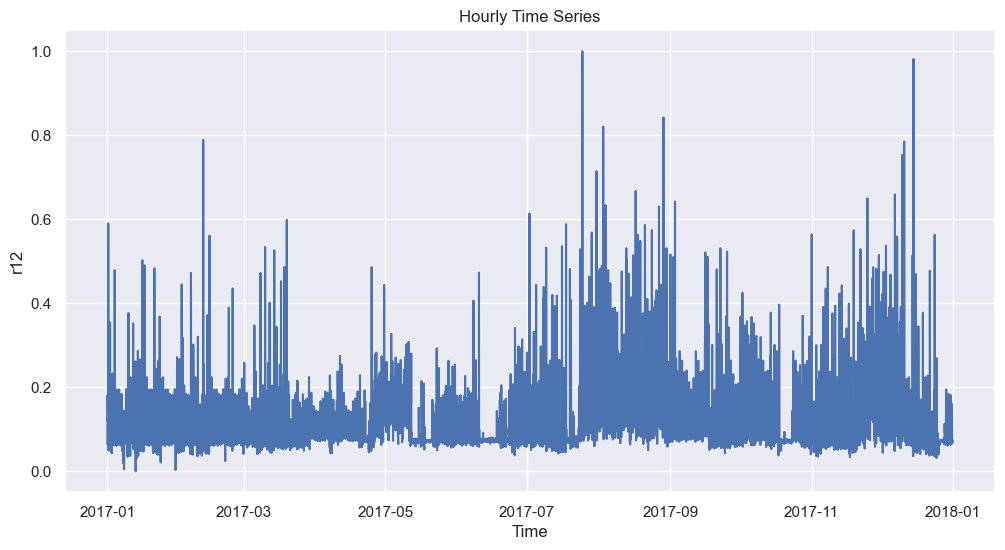

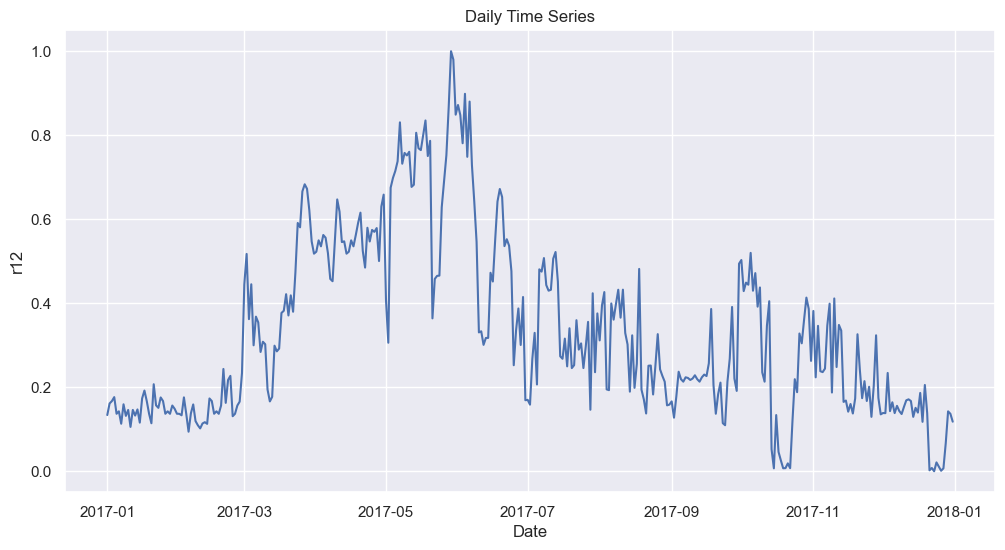

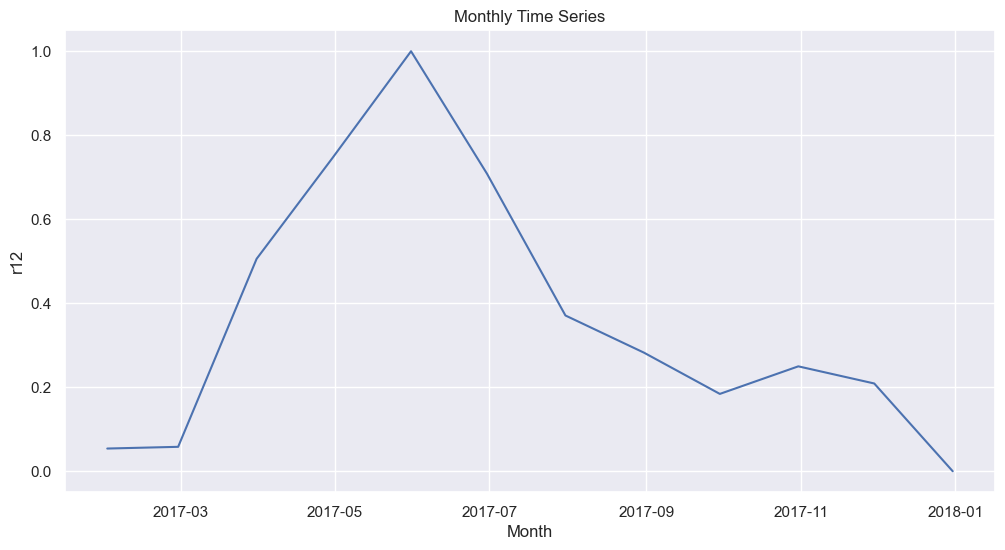

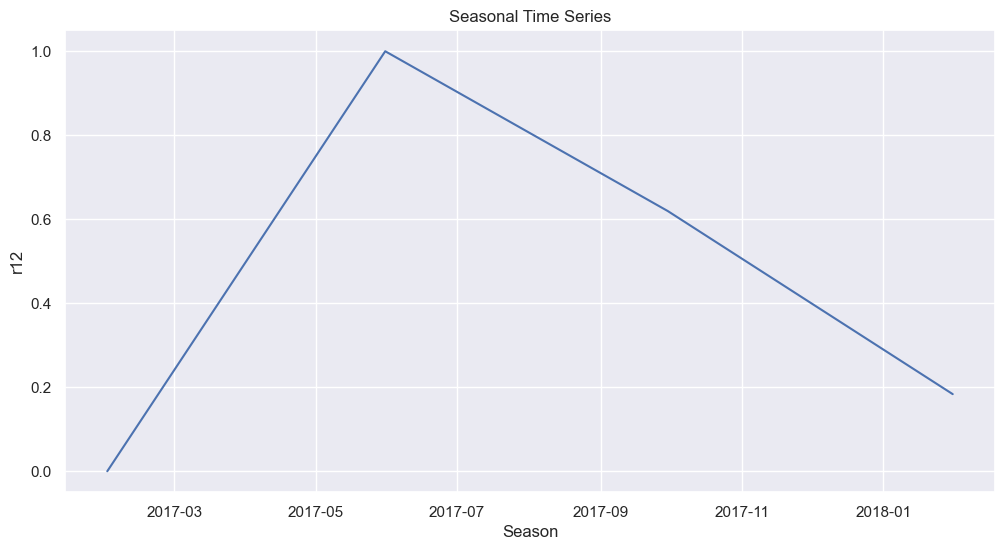

In [124]:

for i in range(1,13):
 

 #Resampling of data on hourly basis

 plt.figure(figsize=(12, 6))
 plt.plot(df_hourly.index, df_hourly['r1'])
 plt.xlabel('Time')
 plt.ylabel('r'+str(i))
 plt.title('Hourly Time Series')
 plt.show()
    
 
 #Resampling of data on daily basis
 plt.figure(figsize=(12, 6))
 plt.plot(df_daily.index, df_daily['r'+str(i)])
 plt.xlabel('Date')
 plt.ylabel('r'+str(i))
 plt.title('Daily Time Series')
 plt.show()
    
 #Resampling od data on montlhly basis   

 plt.figure(figsize=(12, 6))
 plt.plot(df_monthly.index, df_monthly['r'+str(i)])
 plt.xlabel('Month')
 plt.ylabel('r'+str(i))
 plt.title('Monthly Time Series')
 plt.show()

 #Resampling of data on seasonal basis

 plt.figure(figsize=(12, 6))
 plt.plot(df_seasonal.index, df_seasonal['r'+str(i)])
 plt.xlabel('Season')
 plt.ylabel('r'+str(i))
 plt.title('Seasonal Time Series')
 plt.show()


 

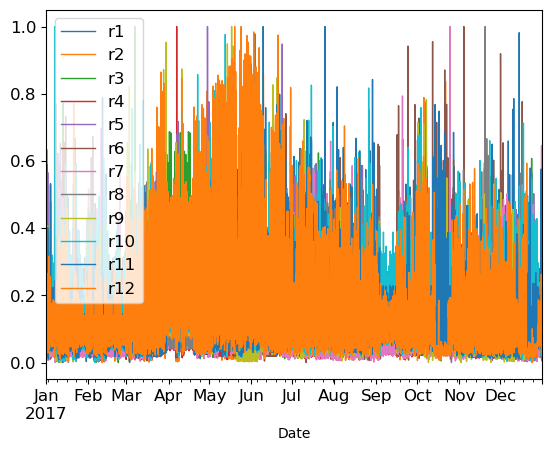

In [34]:
#plot_timeseries data
ax = df_r.plot(linewidth=1, fontsize=12)
ax.set_xlabel('Date')
ax.legend(fontsize=12)


In [35]:
df_r.max(),df_r.min()

(r1     1.0
 r2     1.0
 r3     1.0
 r4     1.0
 r5     1.0
 r6     1.0
 r7     1.0
 r8     1.0
 r9     1.0
 r10    1.0
 r11    1.0
 r12    1.0
 dtype: float64,
 r1     0.0
 r2     0.0
 r3     0.0
 r4     0.0
 r5     0.0
 r6     0.0
 r7     0.0
 r8     0.0
 r9     0.0
 r10    0.0
 r11    0.0
 r12    0.0
 dtype: float64)

In [36]:
min_new = 0.001
df_r1 = df_r * (1 - min_new) + min_new
#as seasonal decompose doesnt take values in zero

C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_12188\1719836536.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


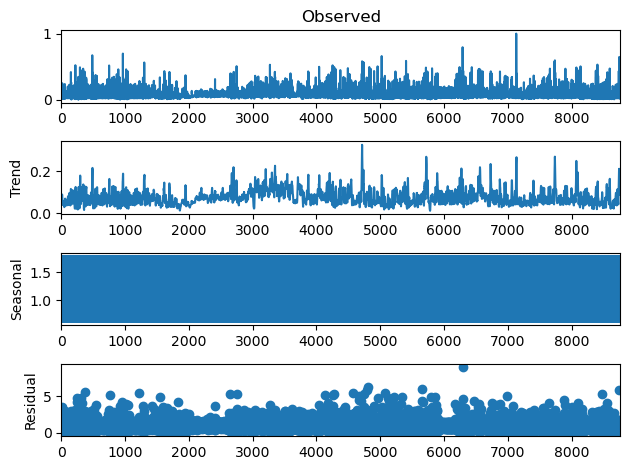

In [37]:
res = sm.tsa.seasonal_decompose(df_r1['r7'].values,period=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
fig.show()


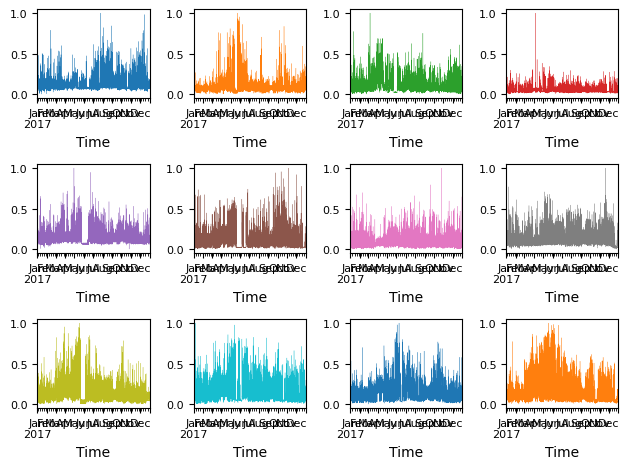

In [38]:
df_hourly.plot(subplots=True,
          layout=(3, 4),
          sharex=False,
          sharey=False,
         fontsize=8,
         legend=False,
         linewidth=0.2)
plt.tight_layout()

C:\Users\AVDEV03\AppData\Local\Temp\ipykernel_12188\3837702508.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(data=df, x = df['Time'].dt.month, y = df['r1'], palette='viridis',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


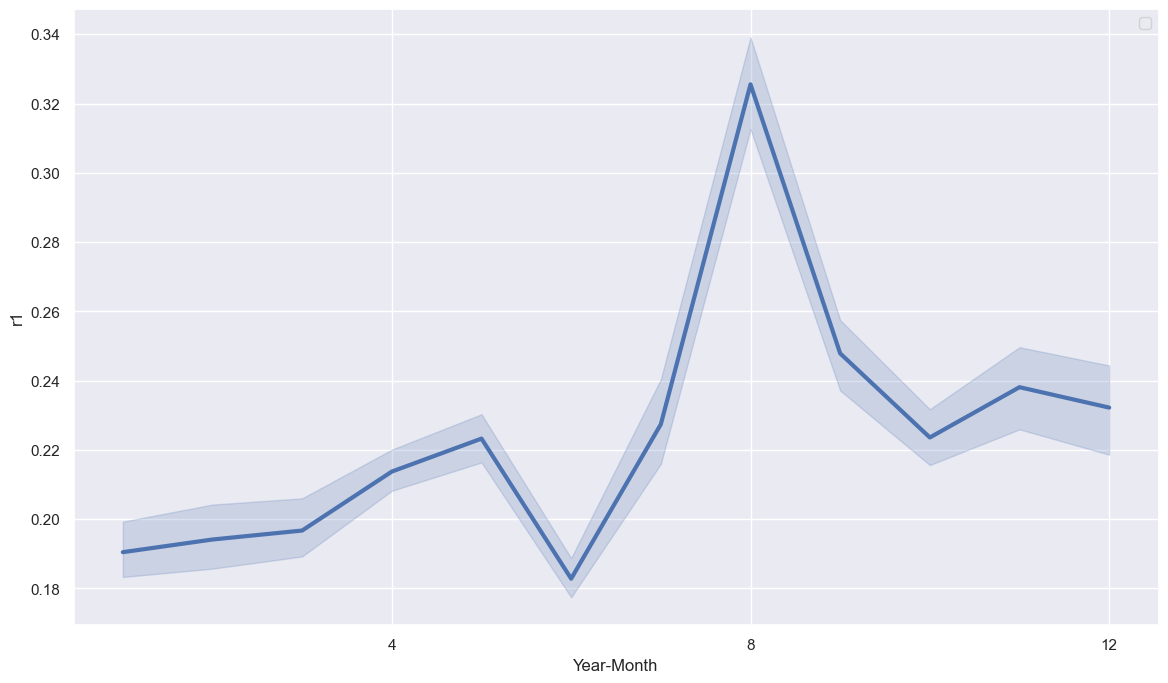

In [39]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=df, x = df['Time'].dt.month, y = df['r1'], palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('r1')
plt.xlabel('Year-Month')
plt.show()

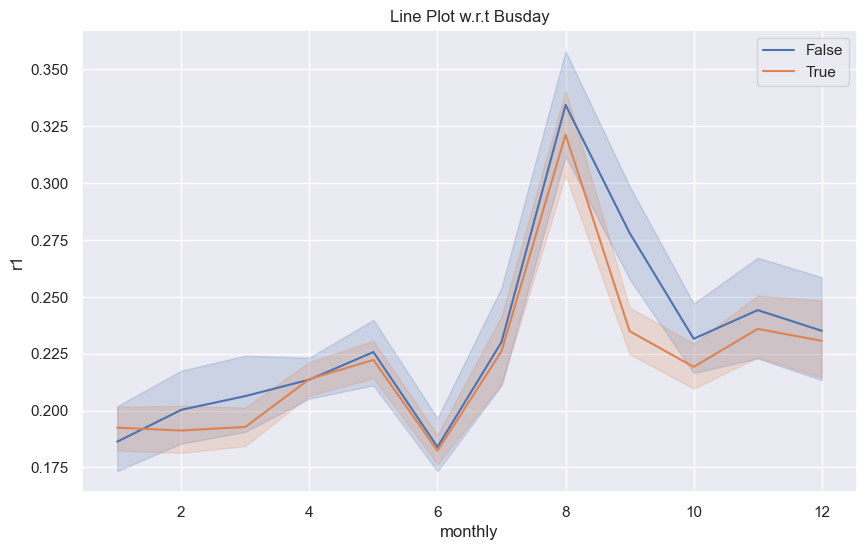

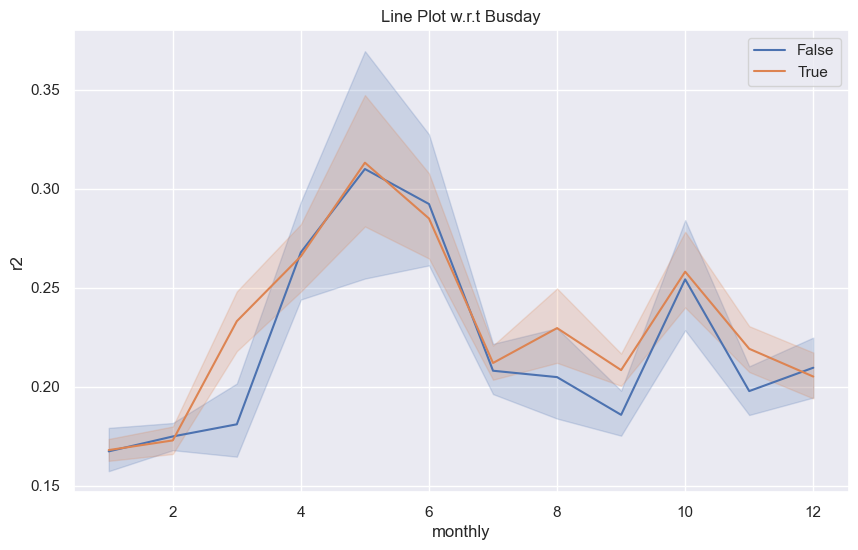

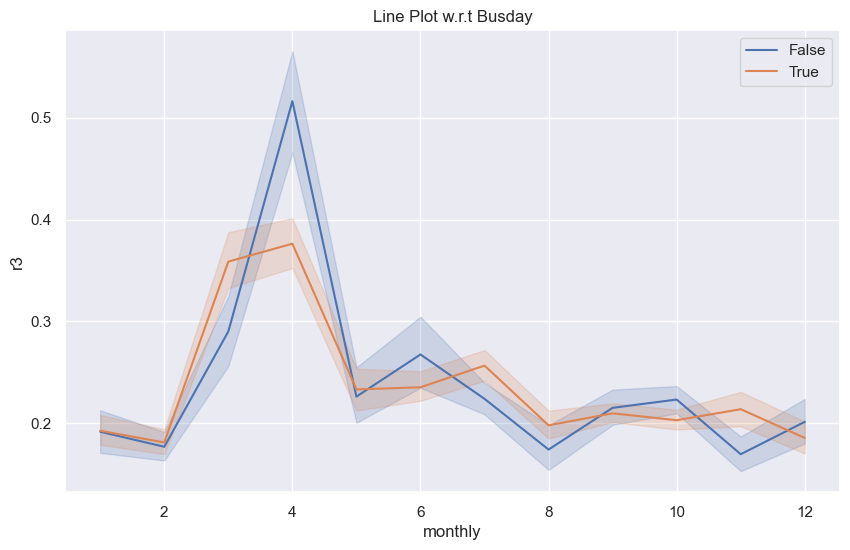

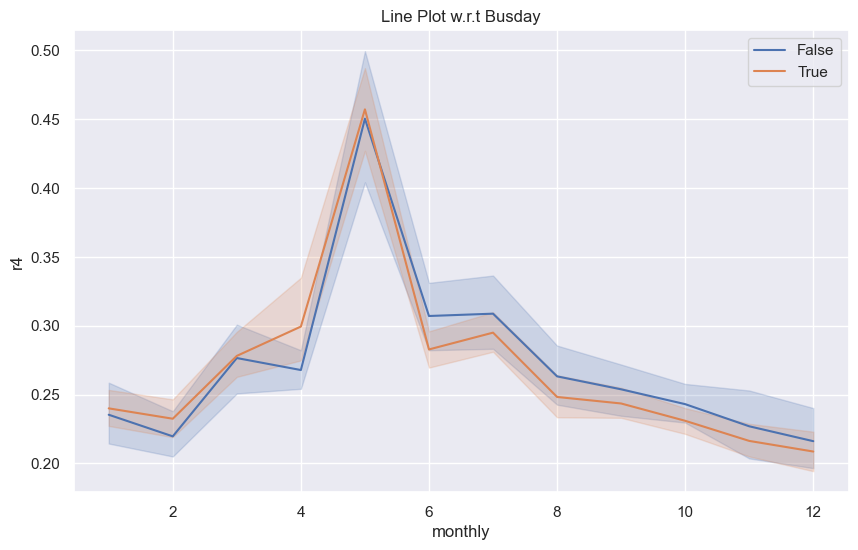

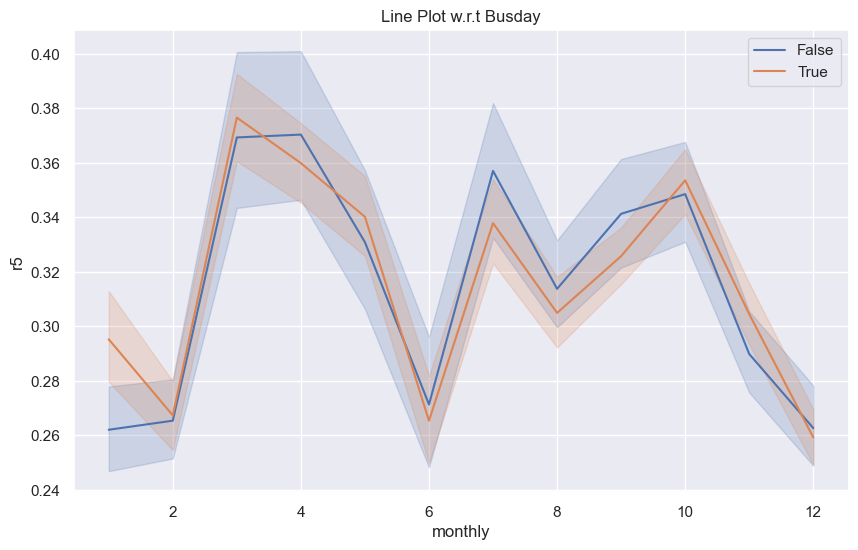

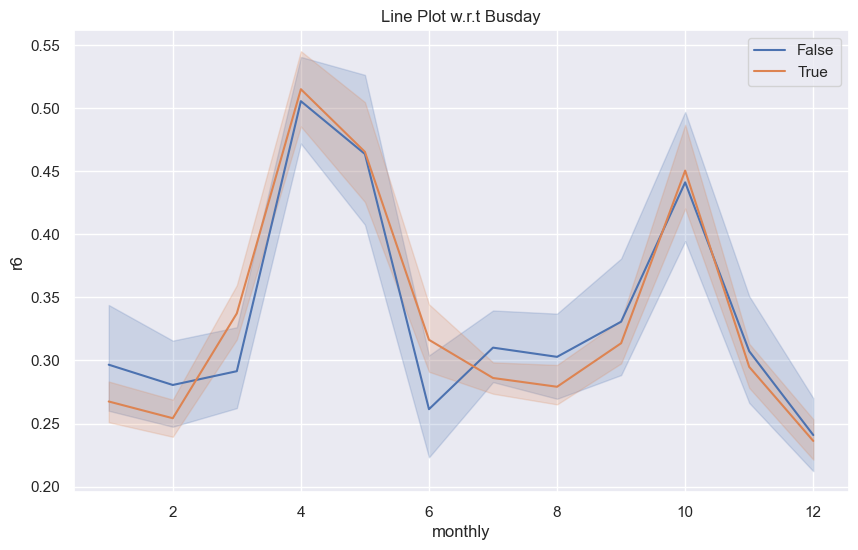

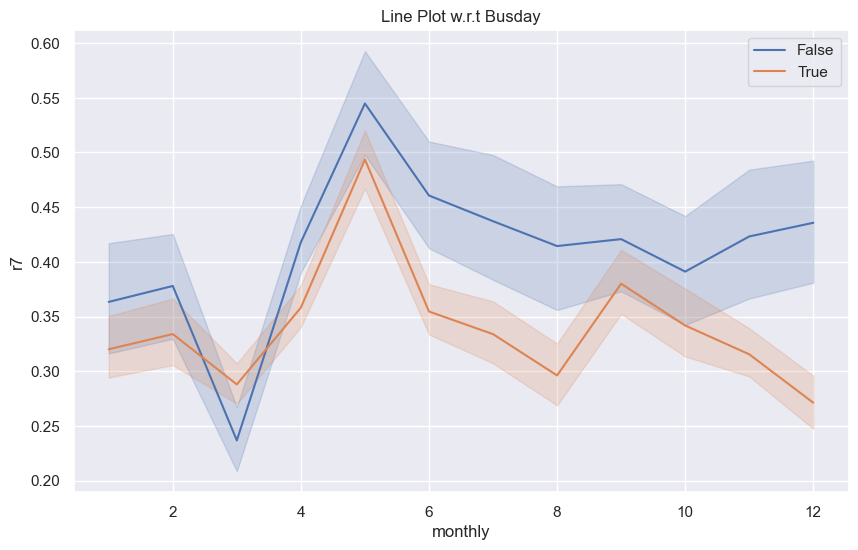

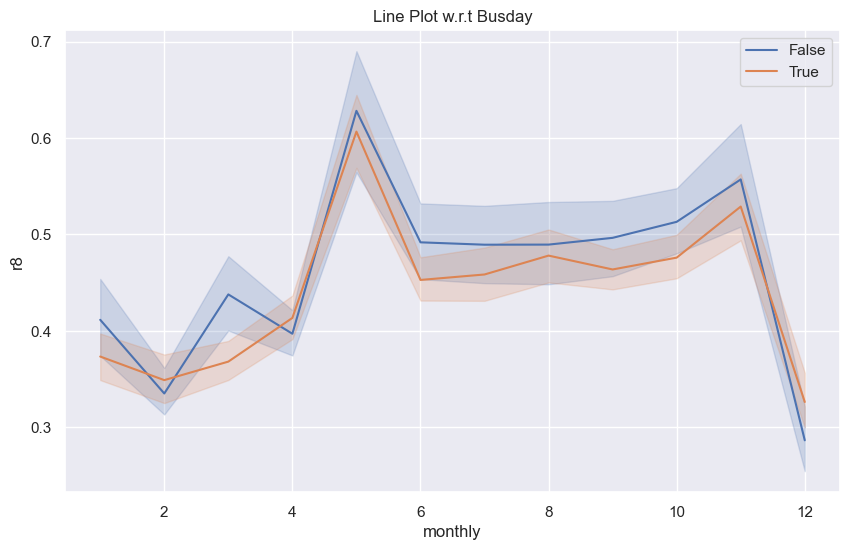

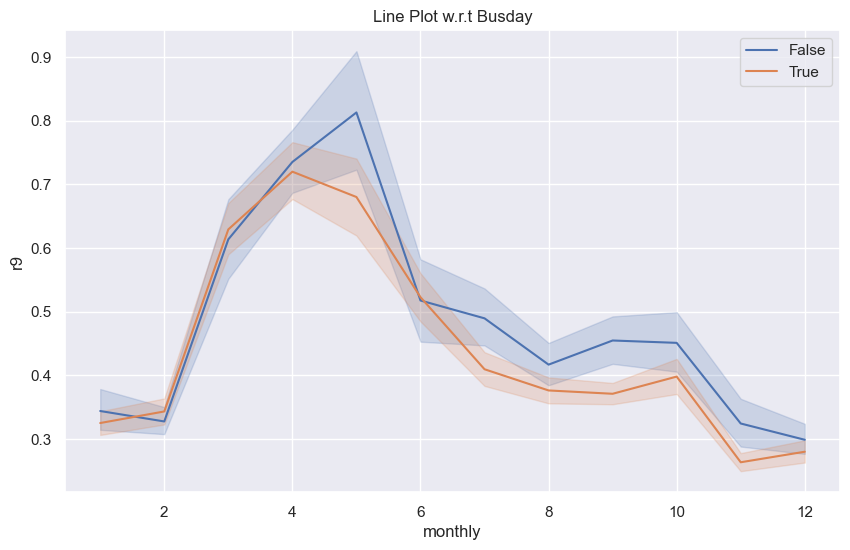

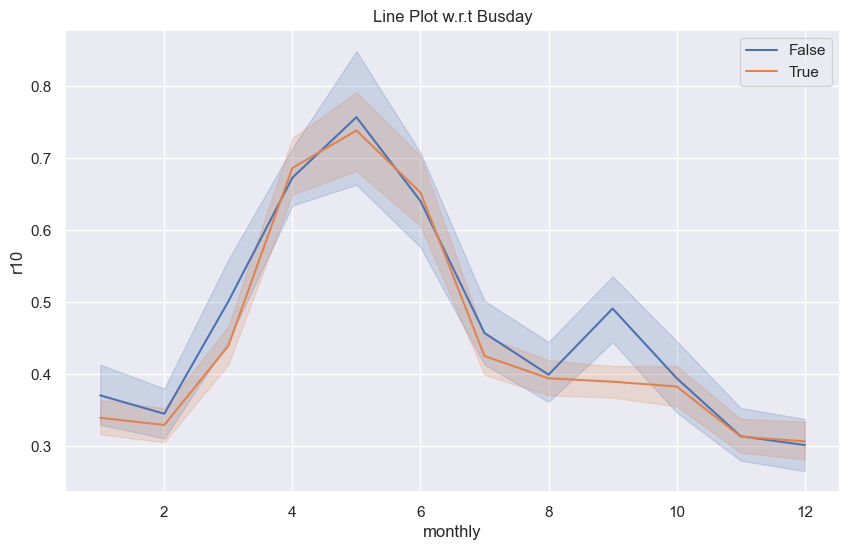

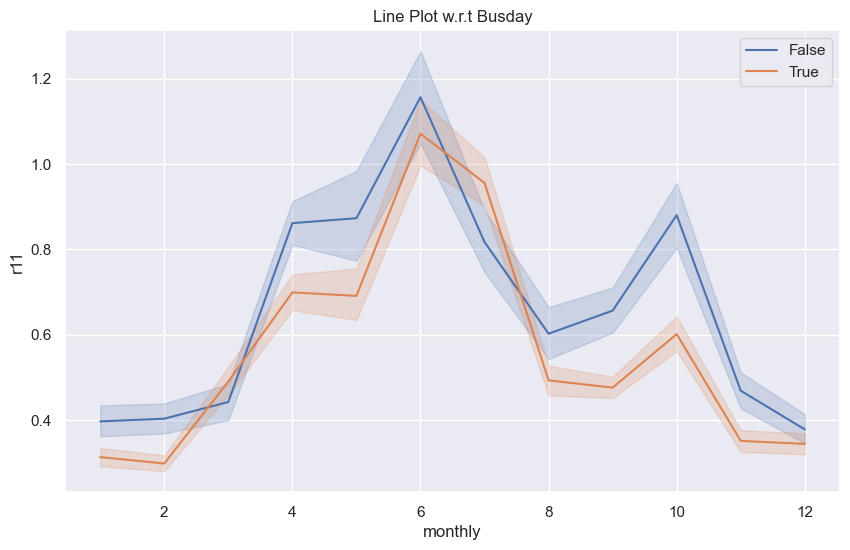

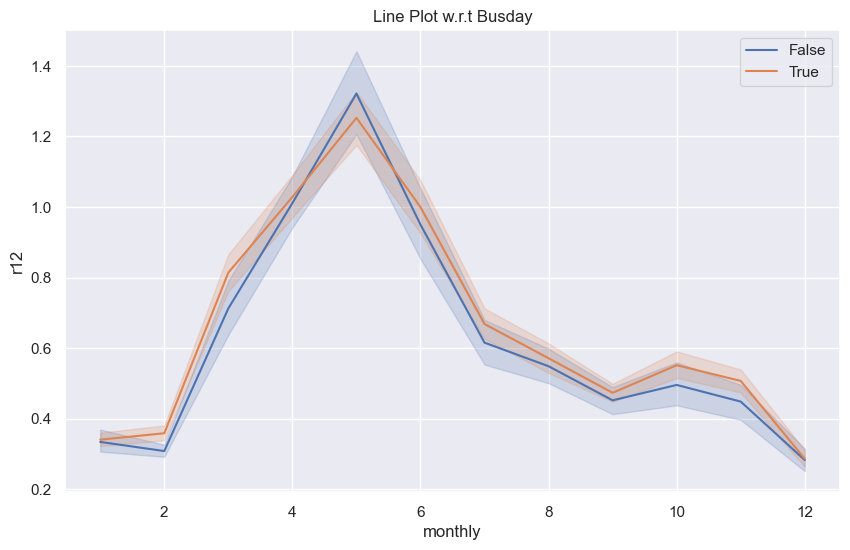

In [40]:
for i in range(1,13):
 sns.set_style('darkgrid')
 sns.set(rc={'figure.figsize': (10, 6)})

 # Create the line plot with multiple lines
 #sns.lineplot(data=df, x=df['Time'].dt.month, y=df['r1'], label='Line 1')
 #sns.lineplot(data=df, x=df['Time'].dt.month, y= df['r1'], hue=df['season'], label='Line 2')
 sns.lineplot(data=df, x=df['Time'].dt.month, y=df['r'+str(i)], hue=df['busday'], label='')

 plt.xlabel('monthly')
 plt.ylabel('r'+str(i))
 plt.title('Line Plot w.r.t Busday')

 plt.legend()
 plt.show()

In [41]:
category_mapping = {'Winter': 0, 'Summer': 1, 'Monsoon': 2}
df['Season'] = df['season']
df['Season'] = pd.factorize(df['season'])[0]
df['Season'] = df['Season'].replace(category_mapping)
#df['Season'][5000]
df

Time  year  moy_date  doy_date  busday  season  dow_date  \
0    2017-01-01 00:00:00  2017         1         1   False  Winter         1   
1    2017-01-01 01:00:00  2017         1         1   False  Winter         1   
2    2017-01-01 02:00:00  2017         1         1   False  Winter         1   
3    2017-01-01 03:00:00  2017         1         1   False  Winter         1   
4    2017-01-01 04:00:00  2017         1         1   False  Winter         1   
...                  ...   ...       ...       ...     ...     ...       ...   
8755 2017-12-31 19:00:00  2017        12       365   False  Winter         1   
8756 2017-12-31 20:00:00  2017        12       365   False  Winter         1   
8757 2017-12-31 21:00:00  2017        12       365   False  Winter         1   
8758 2017-12-31 22:00:00  2017        12       365   False  Winter         1   
8759 2017-12-31 23:00:00  2017        12       365   False  Winter         1   

      hour month_name  temp  ...      r4      r5      r6      r7      r8  \
0        0  January    22.0  ...  0.0667  0.2131  0.0854  0.1277  0.2173   
1        1  January    22.0  ...  0.1047  0.1719  0.0948  0.1112  0.2411   
2        2  January    22.0  ...  0.1001  0.1865  0.0978  0.1850  0.8316   
3        3  January    23.5  ...  0.1354  0.1882  0.1064  0.0970  0.6645   
4        4  January    27.0  ...  0.3508  0.2092  0.2456  0.1374  1.9451   
...    ...        ...   ...  ...     ...     ...     ...     ...     ...   
8755    19  December   23.5  ...  0.0896  0.1475  0.0889  0.1258  0.1211   
8756    20  December   24.0  ...  0.0584  0.1649  0.0883  0.1166  0.1056   
8757    21  December   23.0  ...  0.1000  0.1887  0.0977  0.0997  0.1052   
8758    22  December   22.0  ...  0.1067  0.1874  0.0950  0.1459  0.1232   
8759    23  December   22.0  ...  0.0600  0.1898  0.0885  0.1009  0.1025   

          r9     r10     r11     r12  Season  
0     0.1478  0.1568  1.1462  0.2553       0  
1     0.1597  0.4315  0.2193  0.5326       0  
2     0.2118  1.4843  0.1563  0.3818       0  
3     0.2361  1.3716  0.2327  0.3798       0  
4     0.3902  0.2105  0.2395  0.5176       0  
...      ...     ...     ...     ...     ...  
8755  0.1620  0.1375  0.5079  0.1471       0  
8756  0.1639  0.1367  0.1133  0.1921       0  
8757  0.1642  0.1791  0.1159  0.1581       0  
8758  0.1654  0.1425  0.4760  0.2320       0  
8759  0.1606  0.1343  0.1131  0.2954       0  

[8760 rows x 24 columns]

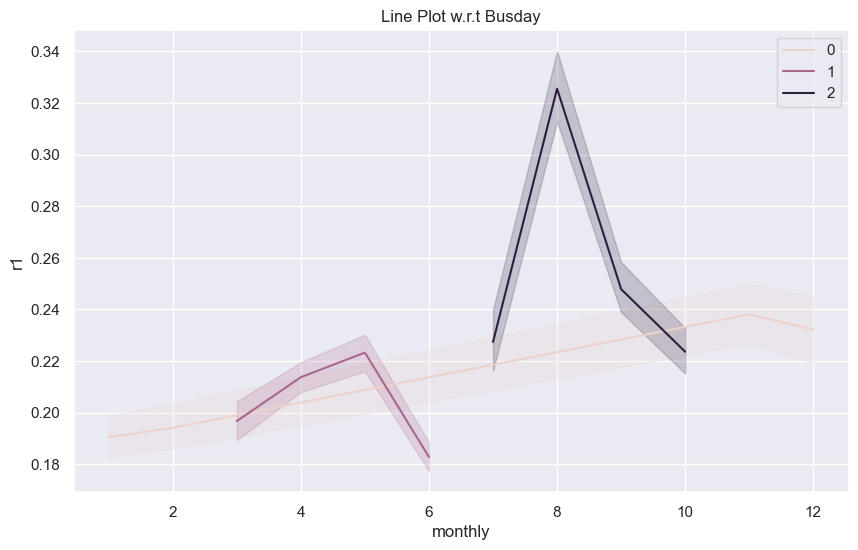

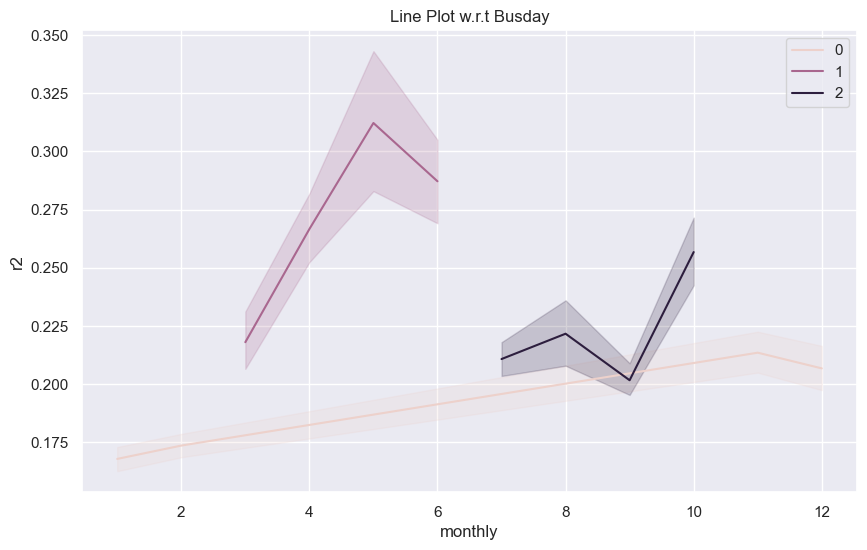

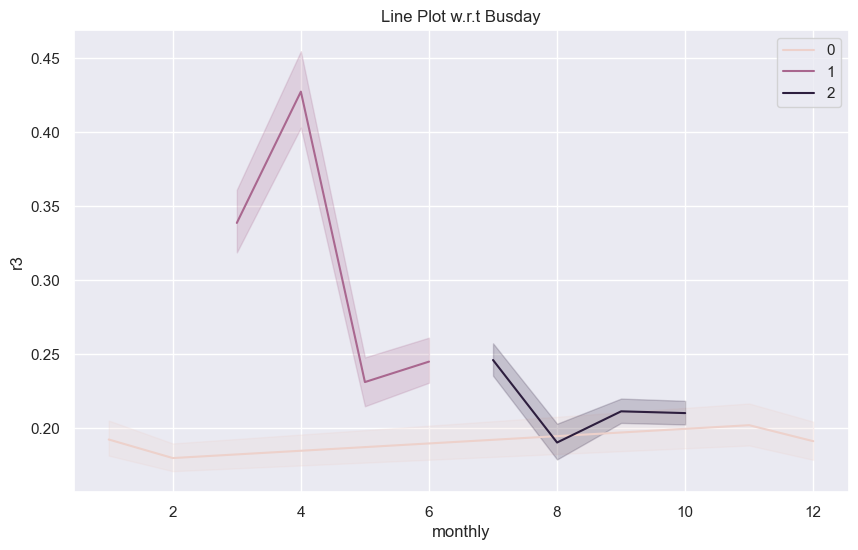

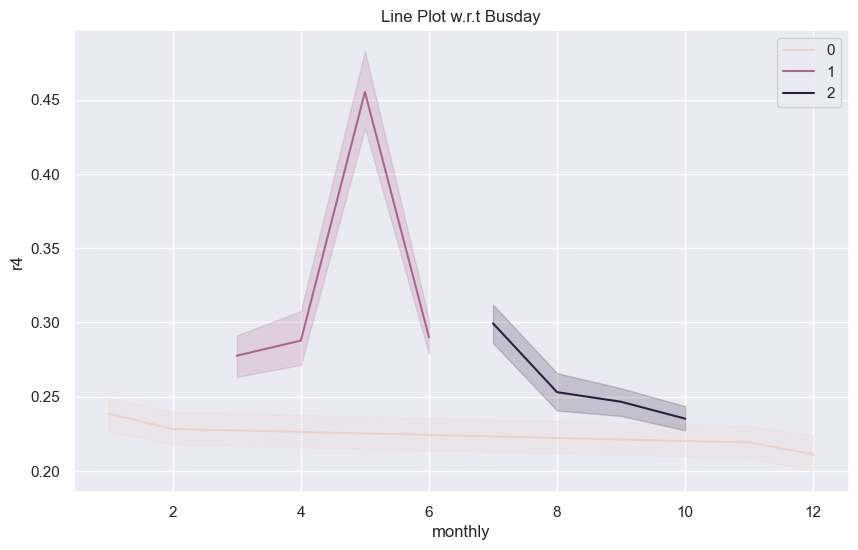

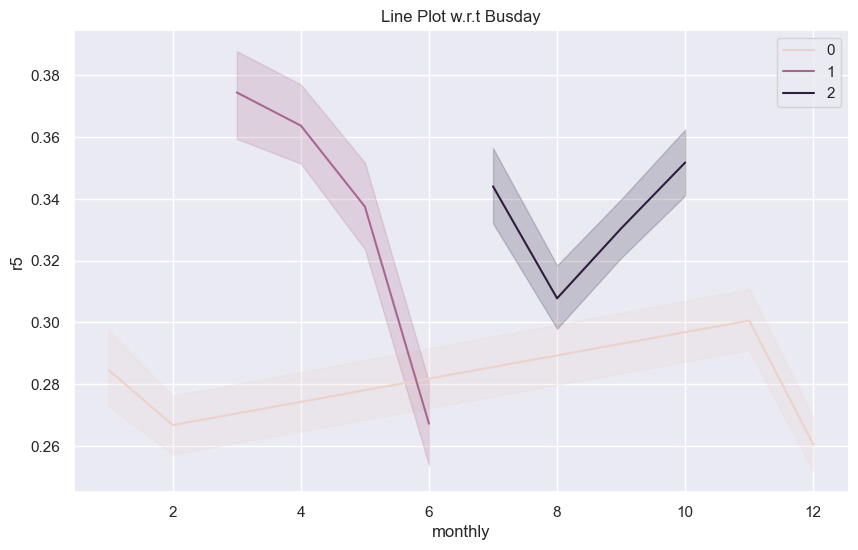

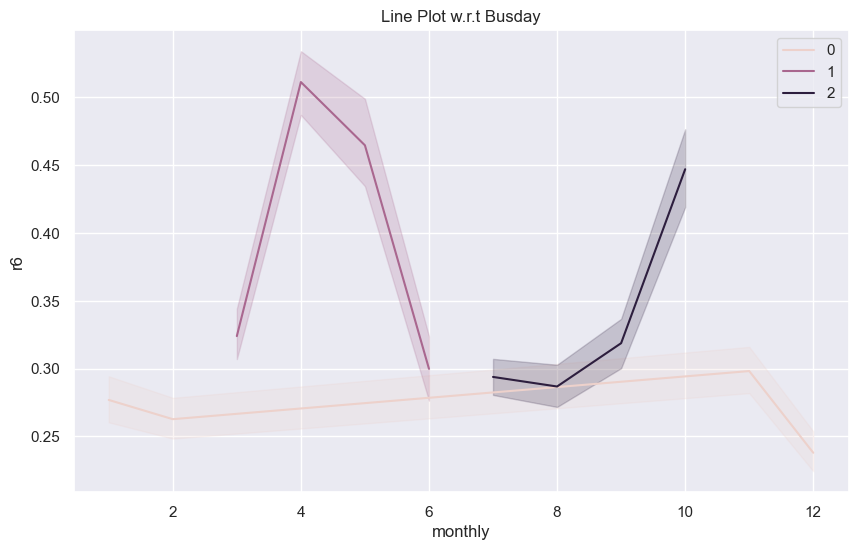

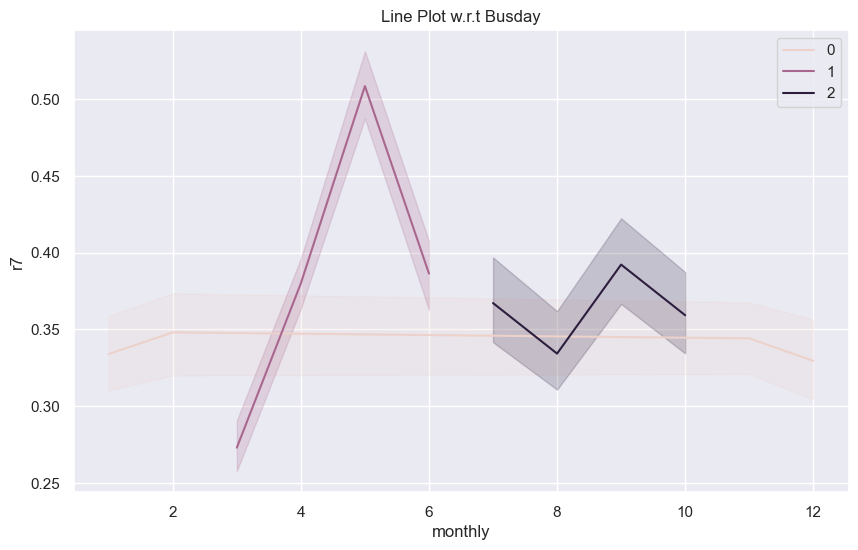

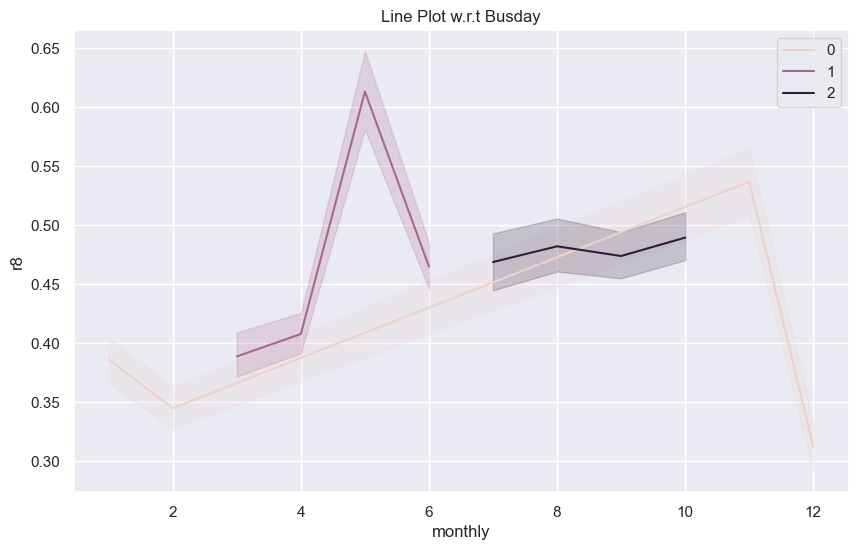

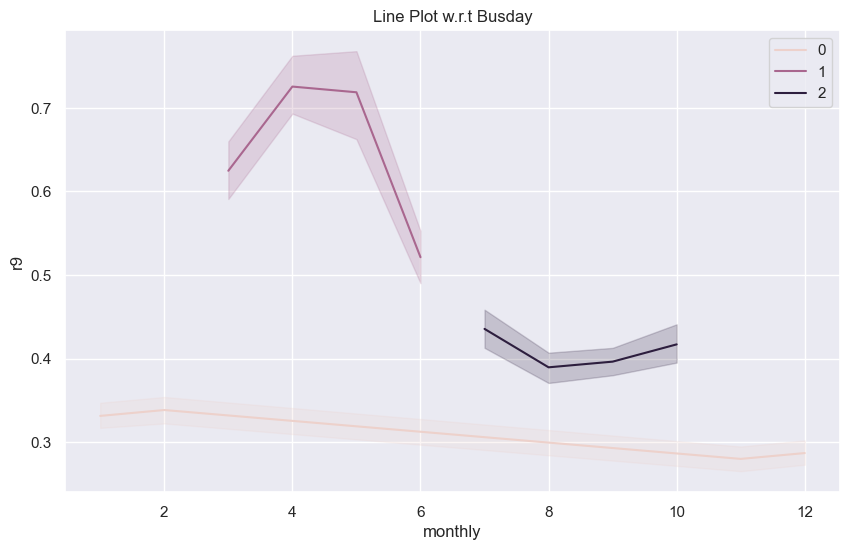

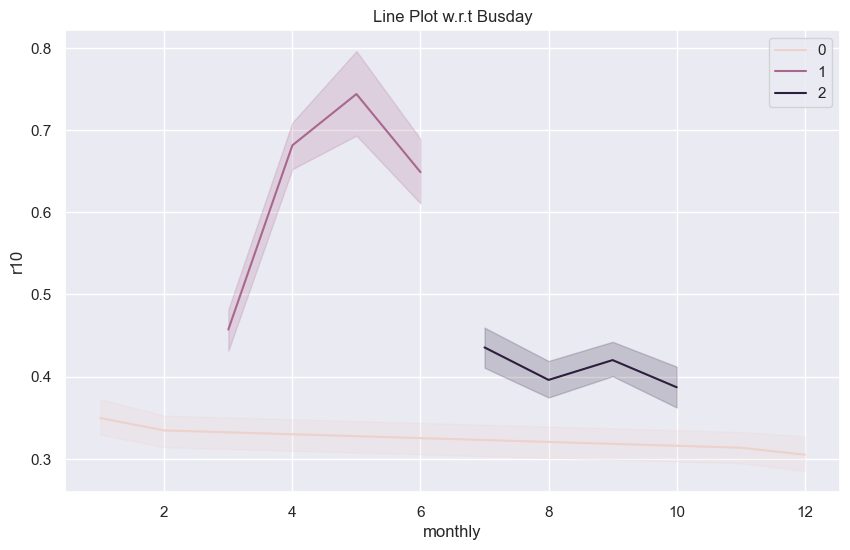

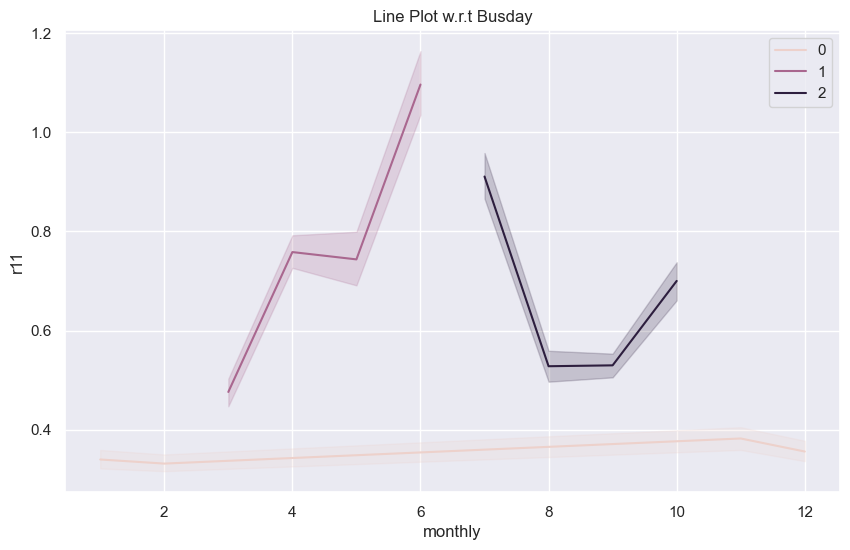

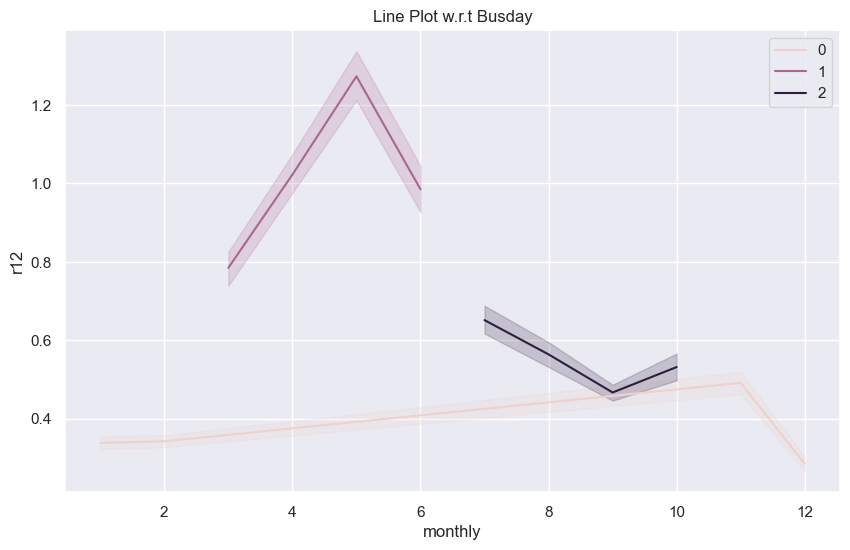

In [42]:
for i in range(1,13):
 sns.set_style('darkgrid')
 sns.set(rc={'figure.figsize': (10, 6)})

 # Create the line plot with multiple lines
 #sns.lineplot(data=df, x=df['Time'].dt.month, y=df['r1'], label='Line 1')
 #sns.lineplot(data=df, x=df['Time'].dt.month, y= df['r1'], hue=df['season'], label='Line 2')
 sns.lineplot(data=df, x=df['Time'].dt.month, y=df['r'+str(i)], hue=df['Season'], label='')

 plt.xlabel('monthly')
 plt.ylabel('r'+str(i))
 plt.title('Line Plot w.r.t Busday')

 plt.legend()
 plt.show()

In [43]:
#DTW CALCULATION 

In [44]:
columns = df_daily.columns

dtw_distances_hourly = []
dtw_distances_pairs_hourly = []

dtw_distances_daily = []
dtw_distances_pairs_daily = []

dtw_distances_monthly = []
dtw_distances_pairs_monthly = []

dtw_distances_seasonal = []
dtw_distances_pairs_seasonal = []


In [45]:
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        distance, _ = fastdtw(df_hourly[columns[i]], df_hourly[columns[j]])
        
        dtw_distances_hourly.append(distance)
        dtw_distances_pairs_hourly.append((i,j,distance))

In [46]:
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        distance, _ = fastdtw(df_daily[columns[i]], df_daily[columns[j]])
        
        dtw_distances_daily.append(distance)
        dtw_distances_pairs_daily.append((i,j,distance))

In [47]:
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
    
        distance, _ = fastdtw(df_monthly[columns[i]], df_monthly[columns[j]])
        dtw_distances_monthly.append(distance)
        dtw_distances_pairs_monthly.append((i,j,distance))
        
#dtw_distances_pairs_monthly

In [48]:
for i in range(len(columns)):
    for j in range(i+1, len(columns)):
        
        distance, _ = fastdtw(df_seasonal[columns[i]], df_seasonal[columns[j]])
        
        dtw_distances_seasonal.append(distance)
        dtw_distances_pairs_seasonal.append((i,j,distance))


In [49]:
dtw_distances_pairs_seasonal

[(0, 1, 0.4177131103228514),
 (0, 2, 1.3755448470196727),
 (0, 3, 1.2122570387953746),
 (0, 4, 0.8470667337504311),
 (0, 5, 1.1194825567383377),
 (0, 6, 0.8747266462260245),
 (0, 7, 0.38236138065204917),
 (0, 8, 1.3738261986070177),
 (0, 9, 1.1355549715961417),
 (0, 10, 0.6677442369295274),
 (0, 11, 0.9537123414172837),
 (1, 2, 1.1941738543179492),
 (1, 3, 1.2096797976448137),
 (1, 4, 0.6656957410487077),
 (1, 5, 0.9381115640366144),
 (1, 6, 0.5321551057267739),
 (1, 7, 0.565682330102089),
 (1, 8, 1.2029366211181924),
 (1, 9, 1.017340154340542),
 (1, 10, 1.0443713014220772),
 (1, 11, 0.7723413487155603),
 (2, 3, 0.5114381377308063),
 (2, 4, 0.5284781132692415),
 (2, 5, 0.456577355502285),
 (2, 6, 0.4026660144081096),
 (2, 7, 1.3509611288577614),
 (2, 8, 0.18155664158089818),
 (2, 9, 0.4725026288250001),
 (2, 10, 0.7104952057195733),
 (2, 11, 0.4218325056023889),
 (3, 4, 0.5661329588386527),
 (3, 5, 0.9680154932330912),
 (3, 6, 0.6775246919180399),
 (3, 7, 1.366467072184626),
 (3, 8, 0.

In [50]:
dtw_distances_seasonal = np.array(dtw_distances_seasonal)
dtw_distances_seasonal.shape

(66,)

In [51]:
dtw_distances_hourly = np.array(dtw_distances_hourly)
dtw_distances_daily = np.array(dtw_distances_daily)
dtw_distances_monthly = np.array(dtw_distances_monthly)
dtw_distances_seasonal = np.array(dtw_distances_seasonal)


dtw_distances_hourly = dtw_distances_hourly.reshape(-1, 1)
dtw_distances_daily = dtw_distances_daily.reshape(-1, 1)
dtw_distances_monthly = dtw_distances_monthly.reshape(-1, 1)
dtw_distances_seasonal = dtw_distances_seasonal.reshape(-1, 1)


In [52]:
dtw_distances_hourly.shape,dtw_distances_daily.shape,dtw_distances_monthly.shape,dtw_distances_seasonal.shape


((66, 1), (66, 1), (66, 1), (66, 1))

In [53]:
dtw_distances_hourly,dtw_distances_daily,dtw_distances_monthly,dtw_distances_seasonal

(array([[ 484.03762699],
        [ 509.05388173],
        [ 498.96446044],
        [ 462.30637555],
        [ 602.94055624],
        [ 570.54783638],
        [ 443.87025215],
        [ 594.87989475],
        [ 664.49403391],
        [ 577.47739307],
        [ 835.93551202],
        [ 413.64033215],
        [ 375.28985406],
        [ 559.52814097],
        [ 529.1622753 ],
        [ 415.10565799],
        [ 575.21889586],
        [ 610.84614035],
        [ 728.99936883],
        [ 581.16253125],
        [ 931.37755335],
        [ 430.73594271],
        [ 554.55571901],
        [ 446.71471425],
        [ 383.63872406],
        [ 550.76199559],
        [ 562.11292707],
        [ 687.82273912],
        [ 564.83576086],
        [ 852.93361557],
        [ 594.24342871],
        [ 538.52203882],
        [ 415.3726694 ],
        [ 559.63726991],
        [ 658.5368869 ],
        [ 739.01525675],
        [ 625.03183484],
        [ 921.45921929],
        [ 632.0253624 ],
        [ 645.09070881],


C:\Users\AVDEV03\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


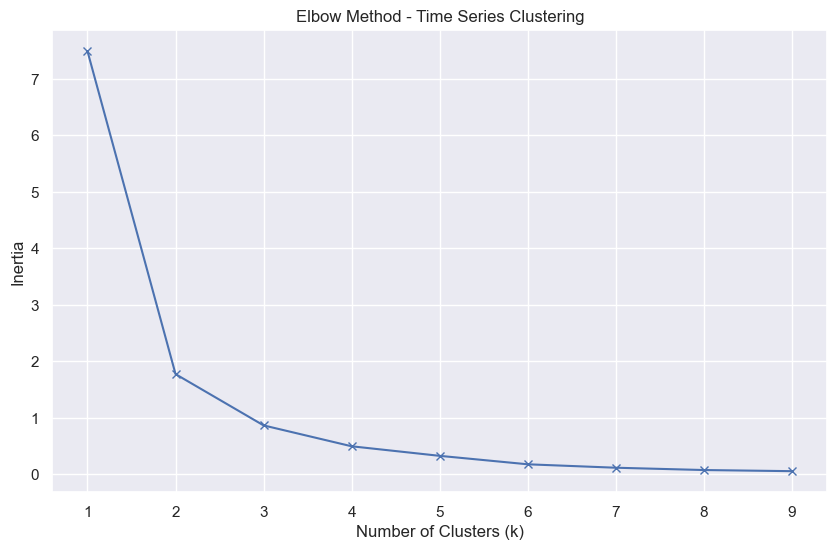

In [54]:
#elbow method for deciding no of clusters
inertia_values = []
k_values = range(1, 10)

for k in k_values:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(dtw_distances_seasonal)
  inertia_values.append(kmeans.inertia_)
  
inertia_values
plt.plot(k_values, inertia_values, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method - Time Series Clustering')
plt.show()

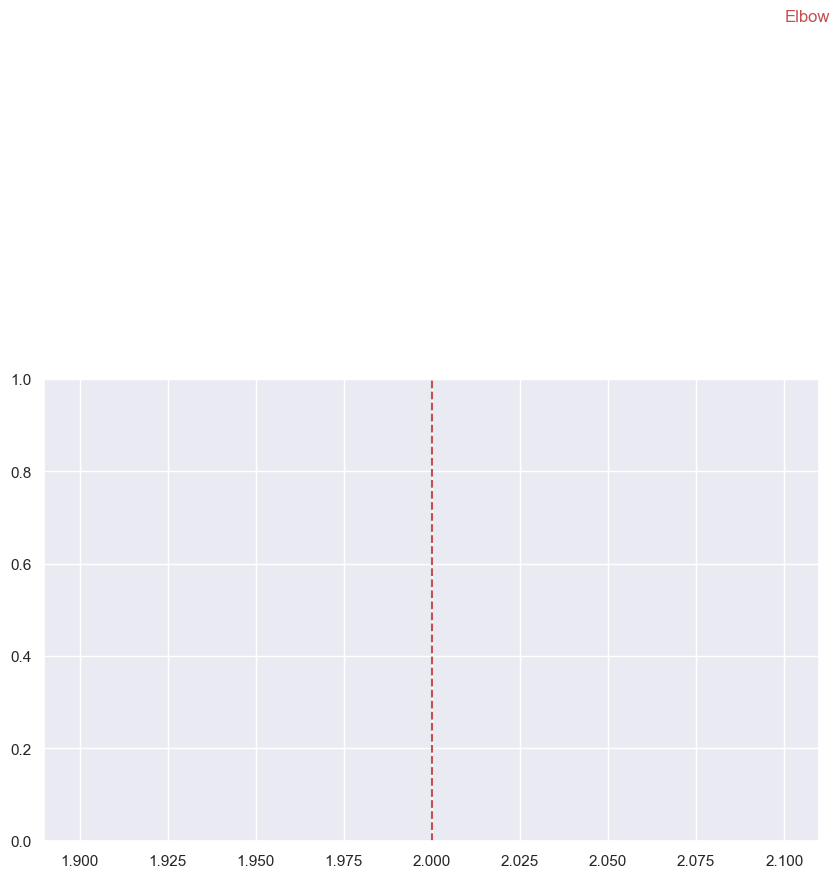

In [55]:
delta_inertia = [inertia_values[i] - inertia_values[i+1] for i in range(len(inertia_values)-1)]
acceleration = [delta_inertia[i] - delta_inertia[i+1] for i in range(len(delta_inertia)-1)]
elbow_index = acceleration.index(max(acceleration)) + 1
elbow_k = k_values[elbow_index]

# Mark the elbow point on the plot
plt.axvline(x=elbow_k, color='r', linestyle='--')
plt.text(elbow_k+0.1, inertia_values[elbow_index], 'Elbow', color='r')
plt.show()


In [56]:
#KMEANS CLUSTERING on DTW Distances - APPROACH 1
#COMPARING THE R1 to R12 with each other and finding out similarities between them.

In [57]:
# Apply a clustering algorithm -KMEANS on hourly,daily,seasonal,monthly data
kmeans_hourly = KMeans(n_clusters=2)
kmeans_daily = KMeans(n_clusters=2)
kmeans_monthly = KMeans(n_clusters=2)
kmeans_seasonal = KMeans(n_clusters=2)


kmeans_hourly.fit(dtw_distances_hourly)
kmeans_daily.fit(dtw_distances_daily)
kmeans_monthly.fit(dtw_distances_monthly)
kmeans_seasonal.fit(dtw_distances_seasonal)

KMeans(n_clusters=2)

In [58]:
cluster_labels_hourly = kmeans_hourly.labels_

cluster_labels_daily = kmeans_daily.labels_
cluster_labels_monthly = kmeans_monthly.labels_
cluster_labels_seasonal = kmeans_seasonal.labels_



In [59]:
#serving the same purpose
cluster_labels_hourly
labels = kmeans_hourly.predict(dtw_distances_hourly)
cluster_labels_hourly, labels

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]))

In [60]:
score_hourly = silhouette_score(dtw_distances_hourly, cluster_labels_hourly)
print("Silhouette Score:", score_hourly)


Silhouette Score: 0.5700979206086397


In [61]:
score_daily = silhouette_score(dtw_distances_daily, cluster_labels_daily)
print("Silhouette Score:", score_daily)

Silhouette Score: 0.5699257222946519


In [62]:
score_monthly = silhouette_score(dtw_distances_monthly, cluster_labels_monthly)
print("Silhouette Score:", score_monthly)

Silhouette Score: 0.5836772340021447


In [63]:
score_seasonal = silhouette_score(dtw_distances_seasonal, cluster_labels_seasonal)
print("Silhouette Score:", score_seasonal)

Silhouette Score: 0.6481431644106106


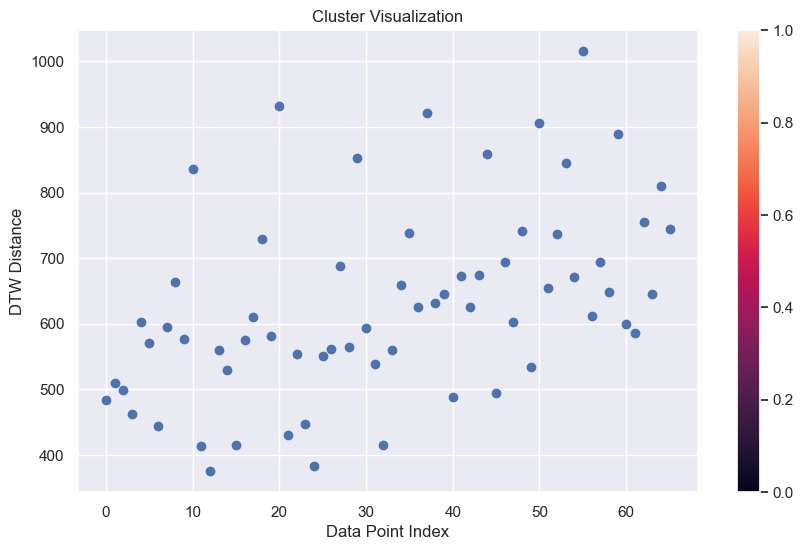

In [64]:
plt.scatter(range(len(dtw_distances_hourly)), dtw_distances_hourly)
plt.title('Cluster Visualization')
plt.xlabel('Data Point Index')
plt.ylabel('DTW Distance')
plt.colorbar()
plt.show()

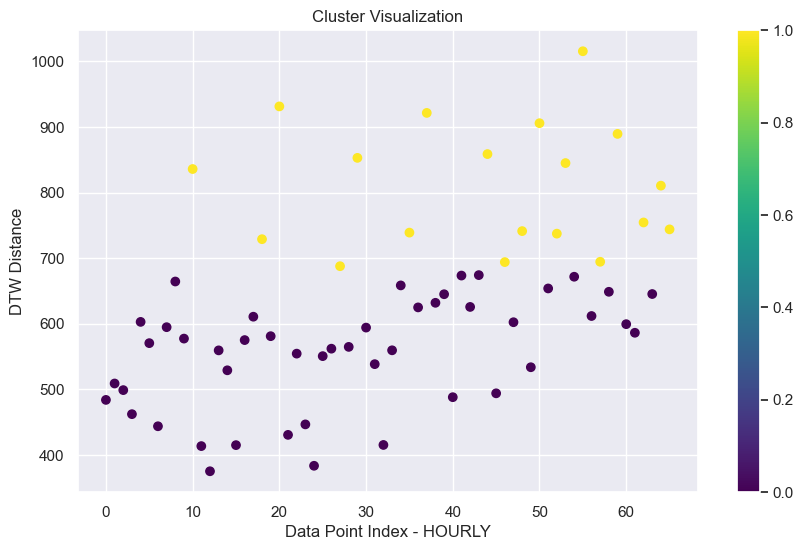

In [103]:
plt.scatter(range(len(dtw_distances_hourly)), dtw_distances_hourly, c=cluster_labels_hourly, cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Data Point Index - HOURLY')
plt.ylabel('DTW Distance')
plt.colorbar()
plt.show()

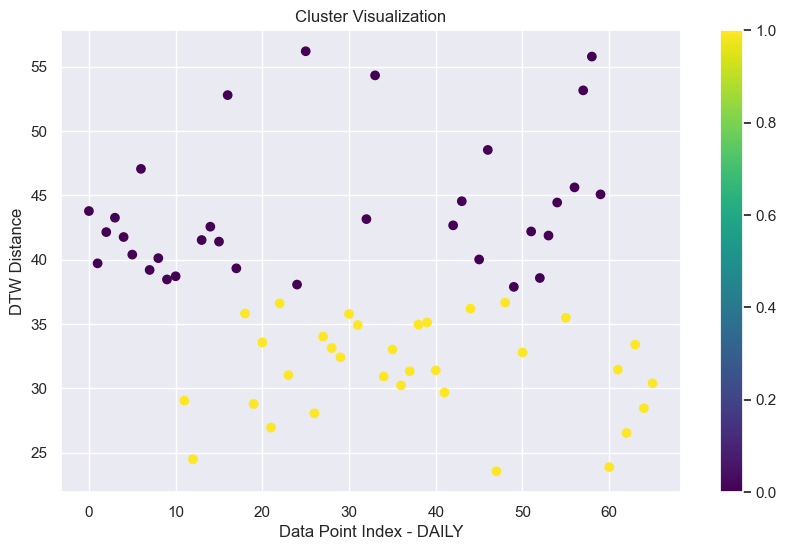

In [104]:
plt.scatter(range(len(dtw_distances_daily)), dtw_distances_daily, c=cluster_labels_daily, cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Data Point Index - DAILY')
plt.ylabel('DTW Distance')
plt.colorbar()
plt.show()

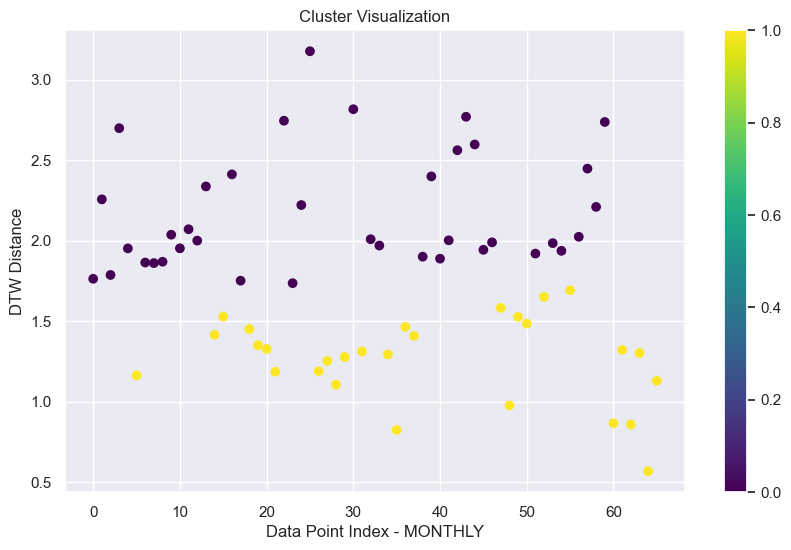

In [105]:
plt.scatter(range(len(dtw_distances_monthly)), dtw_distances_monthly, c=cluster_labels_monthly, cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Data Point Index - MONTHLY')
plt.ylabel('DTW Distance')
plt.colorbar()
plt.show()

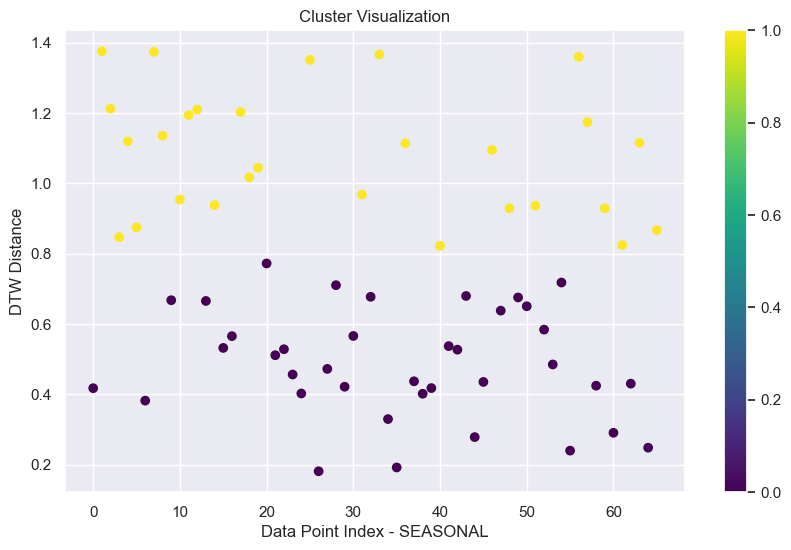

In [106]:
plt.scatter(range(len(dtw_distances_seasonal)), dtw_distances_seasonal, c=cluster_labels_seasonal, cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Data Point Index - SEASONAL')
plt.ylabel('DTW Distance')
plt.colorbar()
plt.show()

In [107]:
category_mapping = {'Winter': 0, 'Summer': 1, 'Monsoon': 2}
df['Season'] = df['season']
df['Season'] = pd.factorize(df['season'])[0]
df['Season'] = df['Season'].replace(category_mapping)
#df['Season'][5000]

In [108]:
#wrong methon as c argument has 8760 elements, which is inconsistent with 'x' and 'y' with size 66.
'''plt.scatter(range(len(dtw_distances_seasonal)), dtw_distances_seasonal, c=df['Season'], cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Data Point Index')
plt.ylabel('DTW Distance')
plt.colorbar()
plt.show()'''

"plt.scatter(range(len(dtw_distances_seasonal)), dtw_distances_seasonal, c=df['Season'], cmap='viridis')\nplt.title('Cluster Visualization')\nplt.xlabel('Data Point Index')\nplt.ylabel('DTW Distance')\nplt.colorbar()\nplt.show()"

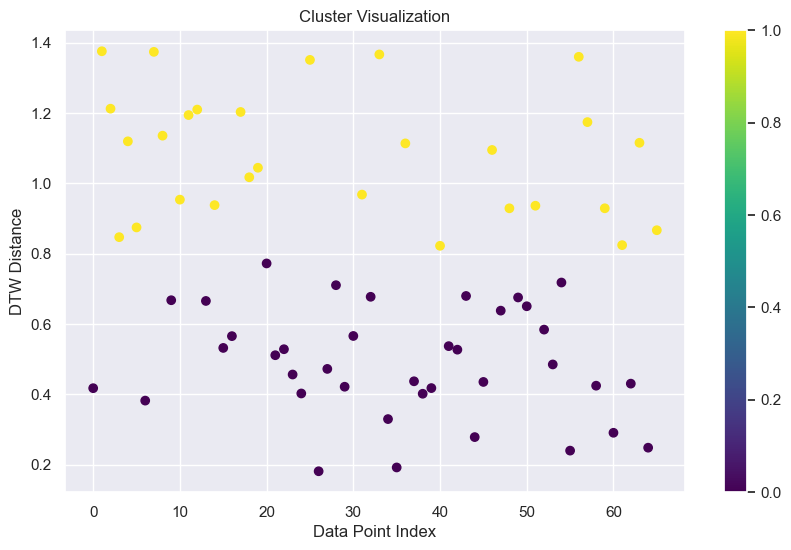

In [109]:
plt.scatter(range(len(dtw_distances_seasonal)), dtw_distances_seasonal, c=cluster_labels_seasonal, cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Data Point Index')
plt.ylabel('DTW Distance')
plt.colorbar()
plt.show()

In [110]:
#1
clust_lab_hourly = pd.DataFrame(cluster_labels_hourly)
clust_lab_hourly.value_counts()

0    47
1    19
dtype: int64

In [73]:
#KMEANS Clustering Algorithm on Timseries data from r1 to r12 - APPROACH 2


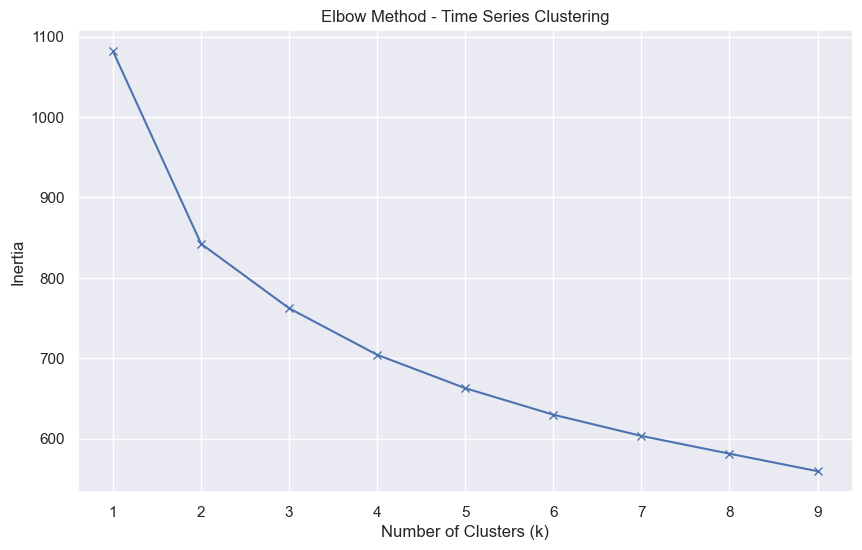

In [74]:
values = []
for k in k_values:
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_r)

    # Append the inertia value (sum of squared distances to the nearest centroid) to the list
    values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, values, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method - Time Series Clustering')
plt.show()

In [111]:
k = 2 
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_r)
#cluster_labels = kmeans.fit_predict(df_r)
df['cluster_label'] = kmeans.labels_

colors = ['blue', 'red']
df.cluster_label

0       0
1       0
2       0
3       0
4       0
       ..
8755    0
8756    0
8757    0
8758    0
8759    0
Name: cluster_label, Length: 8760, dtype: int32

In [112]:
cluster_data = df[df['cluster_label'] == 1]
cluster_data.value_counts()

Time                 year  moy_date  doy_date  busday  season  dow_date  hour  month_name  temp  humid   r1      r2      r3      r4      r5      r6      r7      r8      r9      r10     r11     r12     Season  cluster_label
2017-01-03 04:00:00  2017  1         3         True    Winter  3         4     January     27.5  28.280  0.1700  0.2539  0.2895  0.1558  0.2431  0.1426  0.2641  0.4173  1.2877  0.4907  0.8478  0.8594  0       1                1
2017-06-10 10:00:00  2017  6         161       False   Summer  7         10    June        29.0  79.040  0.2204  0.2097  0.1500  0.2424  0.1463  0.2943  0.2111  0.2557  0.5645  0.7451  2.5743  0.6370  1       1                1
2017-06-14 03:00:00  2017  6         165       True    Summer  4         3     June        29.5  81.530  0.1462  0.4557  0.1994  0.1918  0.2388  0.1188  0.2206  0.8291  1.1962  2.1948  0.7855  0.3267  1       1                1
2017-06-13 18:00:00  2017  6         164       True    Summer  3         18    June        29

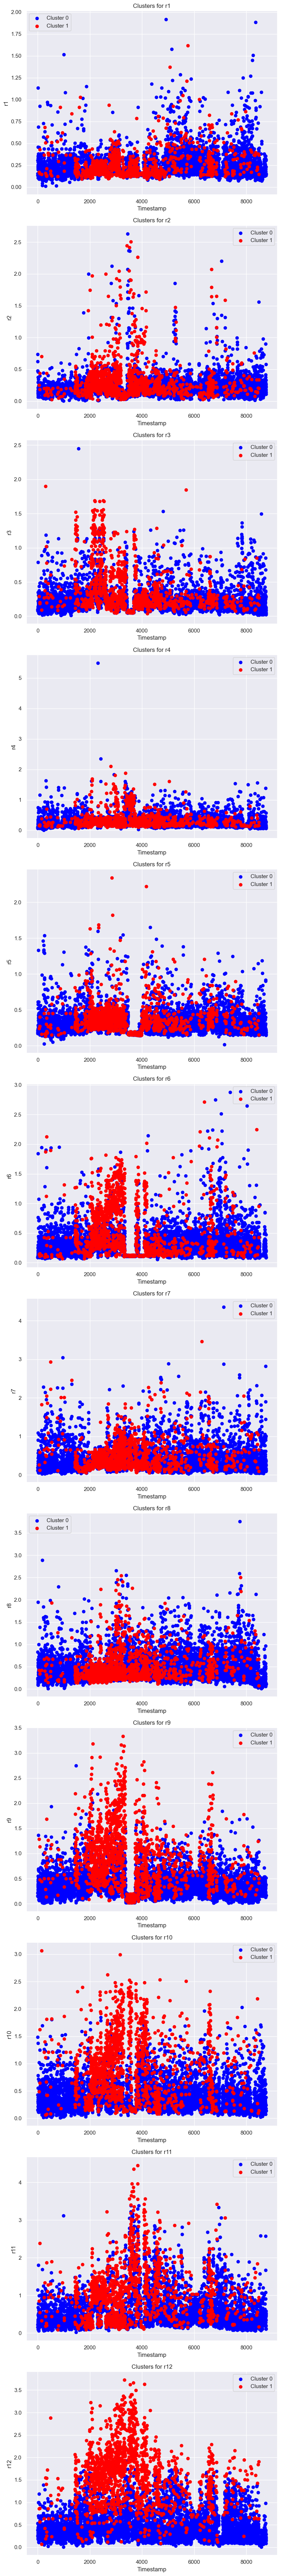

In [113]:
fig, axes = plt.subplots(nrows=len(df_r.columns), figsize=(8, 6*len(df_r.columns)))
for i, variable in enumerate(df_r.columns):
    ax = axes[i]
    for j in range(k):
         cluster_data = df[df['cluster_label'] == j]
         ax.scatter(cluster_data.index, cluster_data[variable],color=colors[j], label=f'Cluster {j}') 
        
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(variable)
    ax.set_title(f'Clusters for {variable}')
    ax.legend()

plt.tight_layout()
plt.show()

In [114]:
#POST CLUSTERING ANALYSIS
df['cluster_label'].value_counts()

0    7199
1    1561
Name: cluster_label, dtype: int64

In [115]:
d_f = df.copy()
d_f.groupby('cluster_label')
for cluster_label, cluster_data in d_f.groupby('cluster_label'):
    print(cluster_label,"cluster_label")
    print(cluster_data,"cluster_data")


0 cluster_label
                    Time  year  moy_date  doy_date  busday  season  dow_date  \
0    2017-01-01 00:00:00  2017         1         1   False  Winter         1   
1    2017-01-01 01:00:00  2017         1         1   False  Winter         1   
2    2017-01-01 02:00:00  2017         1         1   False  Winter         1   
3    2017-01-01 03:00:00  2017         1         1   False  Winter         1   
4    2017-01-01 04:00:00  2017         1         1   False  Winter         1   
...                  ...   ...       ...       ...     ...     ...       ...   
8755 2017-12-31 19:00:00  2017        12       365   False  Winter         1   
8756 2017-12-31 20:00:00  2017        12       365   False  Winter         1   
8757 2017-12-31 21:00:00  2017        12       365   False  Winter         1   
8758 2017-12-31 22:00:00  2017        12       365   False  Winter         1   
8759 2017-12-31 23:00:00  2017        12       365   False  Winter         1   

      hour month_name  

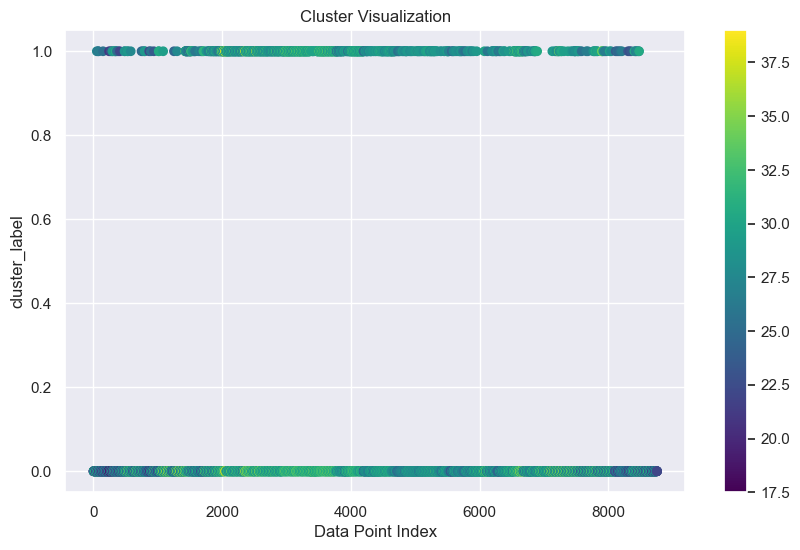

In [116]:
plt.scatter(range(len(df['cluster_label'])), df['cluster_label'], c=df['temp'], cmap='viridis')
plt.title('Cluster Visualization')
plt.xlabel('Data Point Index')
plt.ylabel('cluster_label')
plt.colorbar()
plt.show()

In [117]:
time_labels = d_f.columns[11:23]
len(time_labels),time_labels

(12,
 Index(['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r10', 'r11',
        'r12'],
       dtype='object'))

In [118]:
d_f['busday'] = d_f['busday'].astype(int)
d_f

Time  year  moy_date  doy_date  busday  season  dow_date  \
0    2017-01-01 00:00:00  2017         1         1       0  Winter         1   
1    2017-01-01 01:00:00  2017         1         1       0  Winter         1   
2    2017-01-01 02:00:00  2017         1         1       0  Winter         1   
3    2017-01-01 03:00:00  2017         1         1       0  Winter         1   
4    2017-01-01 04:00:00  2017         1         1       0  Winter         1   
...                  ...   ...       ...       ...     ...     ...       ...   
8755 2017-12-31 19:00:00  2017        12       365       0  Winter         1   
8756 2017-12-31 20:00:00  2017        12       365       0  Winter         1   
8757 2017-12-31 21:00:00  2017        12       365       0  Winter         1   
8758 2017-12-31 22:00:00  2017        12       365       0  Winter         1   
8759 2017-12-31 23:00:00  2017        12       365       0  Winter         1   

      hour month_name  temp  ...      r5      r6      r7      r8      r9  \
0        0  January    22.0  ...  0.2131  0.0854  0.1277  0.2173  0.1478   
1        1  January    22.0  ...  0.1719  0.0948  0.1112  0.2411  0.1597   
2        2  January    22.0  ...  0.1865  0.0978  0.1850  0.8316  0.2118   
3        3  January    23.5  ...  0.1882  0.1064  0.0970  0.6645  0.2361   
4        4  January    27.0  ...  0.2092  0.2456  0.1374  1.9451  0.3902   
...    ...        ...   ...  ...     ...     ...     ...     ...     ...   
8755    19  December   23.5  ...  0.1475  0.0889  0.1258  0.1211  0.1620   
8756    20  December   24.0  ...  0.1649  0.0883  0.1166  0.1056  0.1639   
8757    21  December   23.0  ...  0.1887  0.0977  0.0997  0.1052  0.1642   
8758    22  December   22.0  ...  0.1874  0.0950  0.1459  0.1232  0.1654   
8759    23  December   22.0  ...  0.1898  0.0885  0.1009  0.1025  0.1606   

         r10     r11     r12  Season  cluster_label  
0     0.1568  1.1462  0.2553       0              0  
1     0.4315  0.2193  0.5326       0              0  
2     1.4843  0.1563  0.3818       0              0  
3     1.3716  0.2327  0.3798       0              0  
4     0.2105  0.2395  0.5176       0              0  
...      ...     ...     ...     ...            ...  
8755  0.1375  0.5079  0.1471       0              0  
8756  0.1367  0.1133  0.1921       0              0  
8757  0.1791  0.1159  0.1581       0              0  
8758  0.1425  0.4760  0.2320       0              0  
8759  0.1343  0.1131  0.2954       0              0  

[8760 rows x 25 columns]

Time


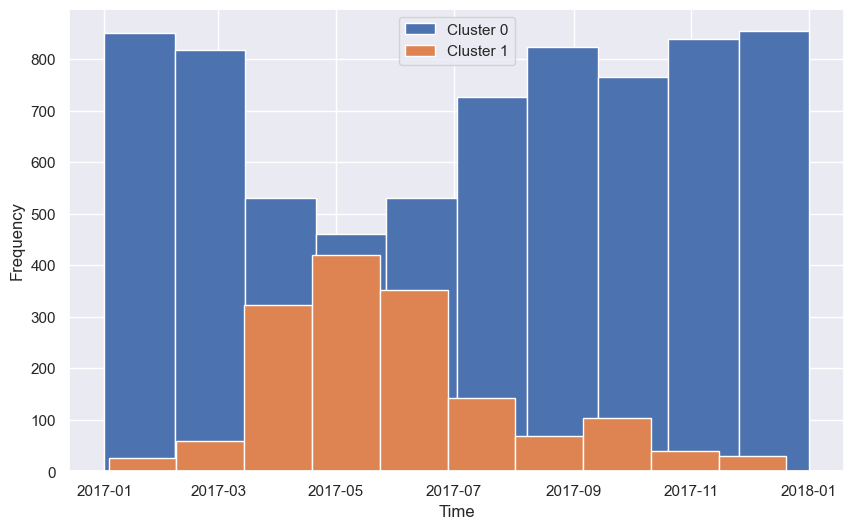

year


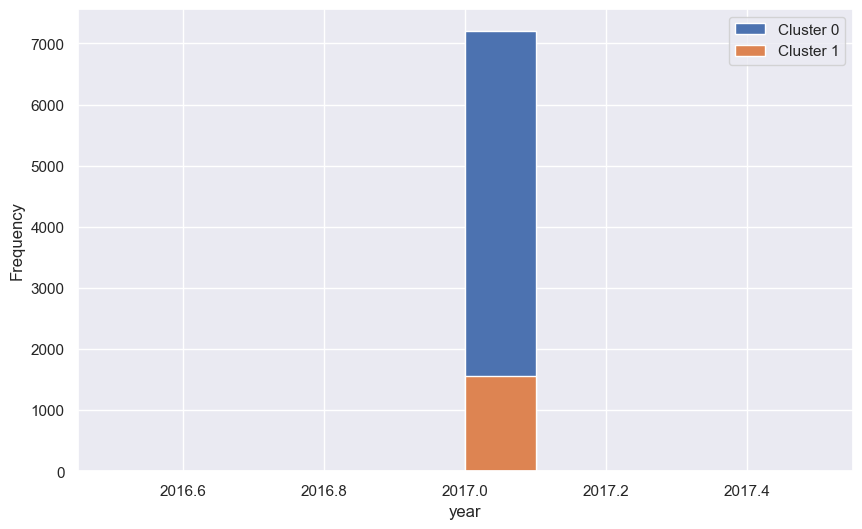

moy_date


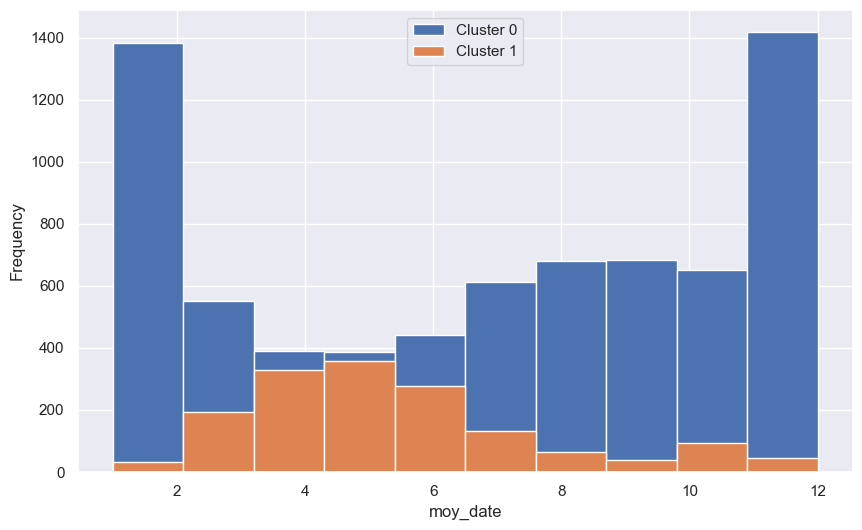

doy_date


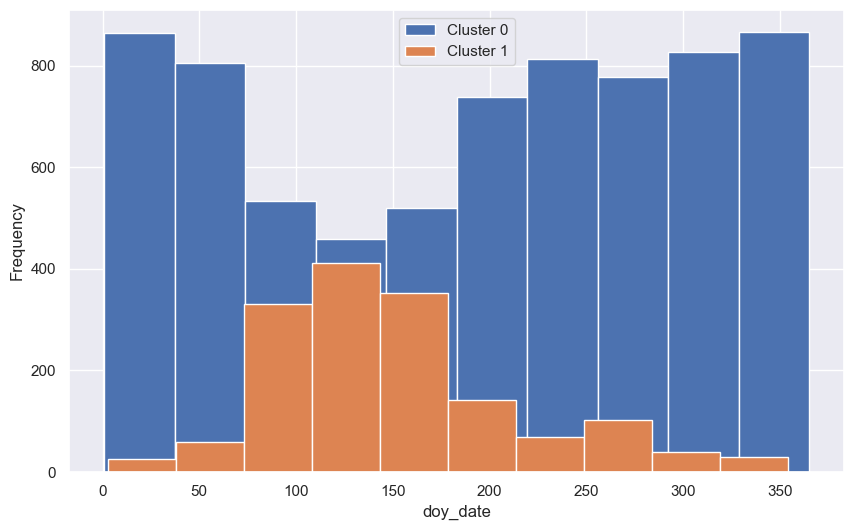

busday


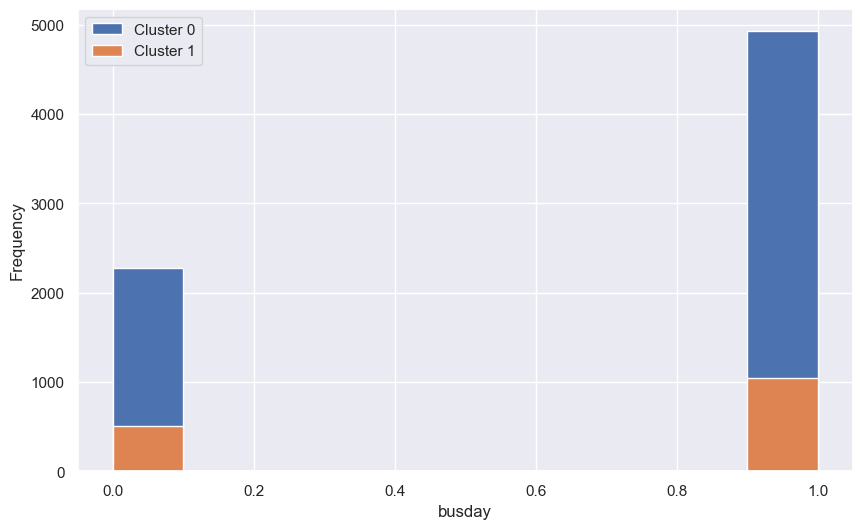

season


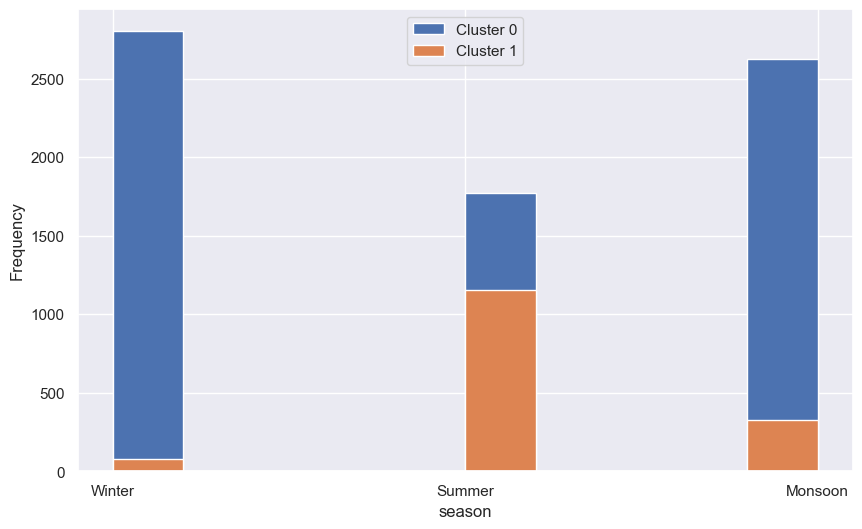

dow_date


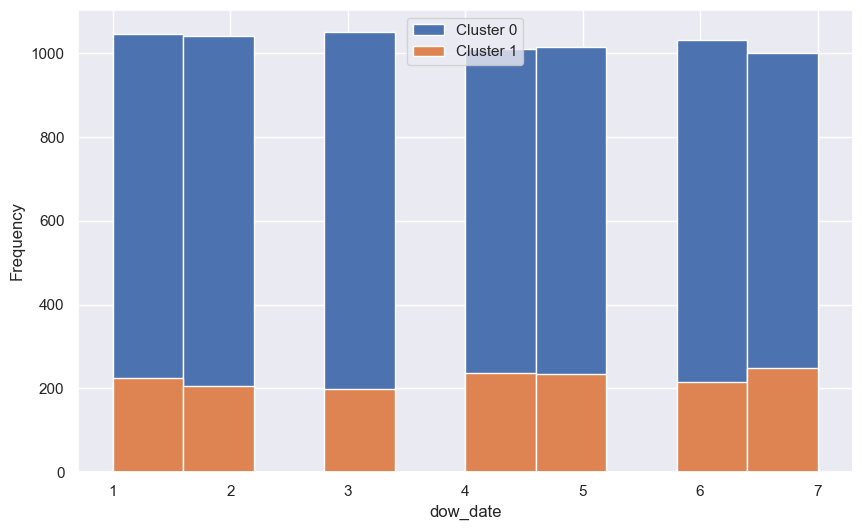

hour


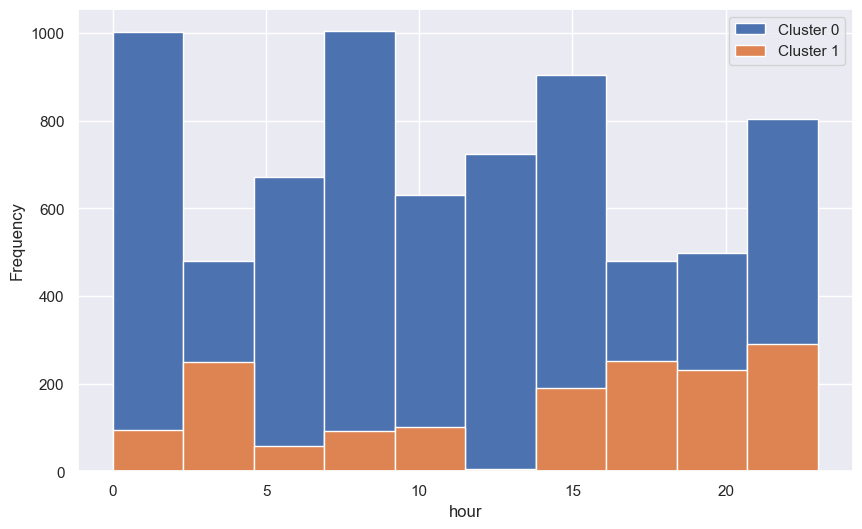

month_name


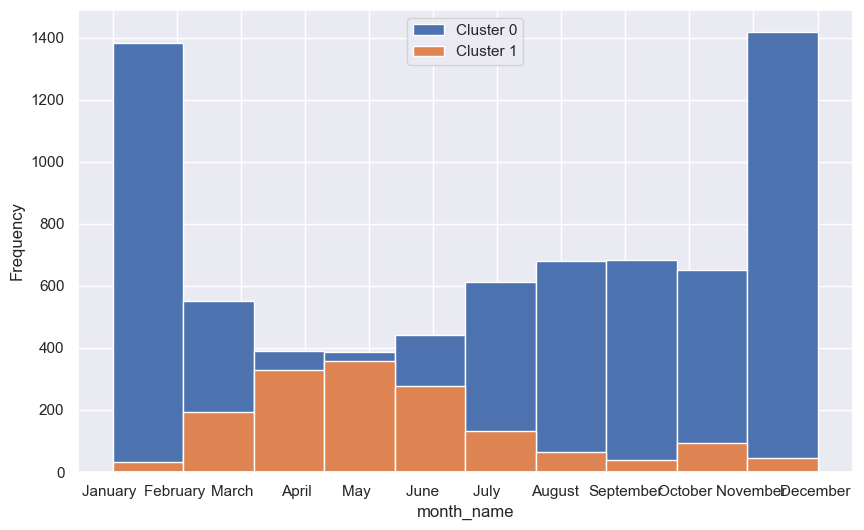

temp


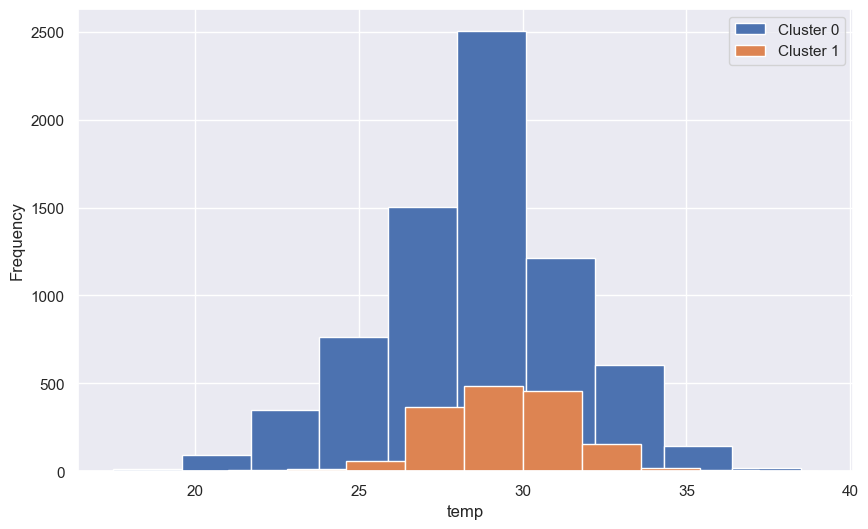

humid


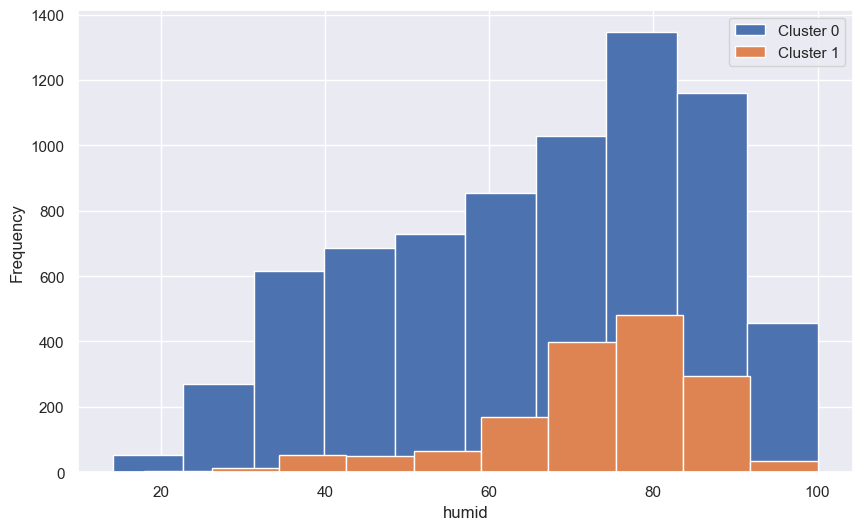

r1


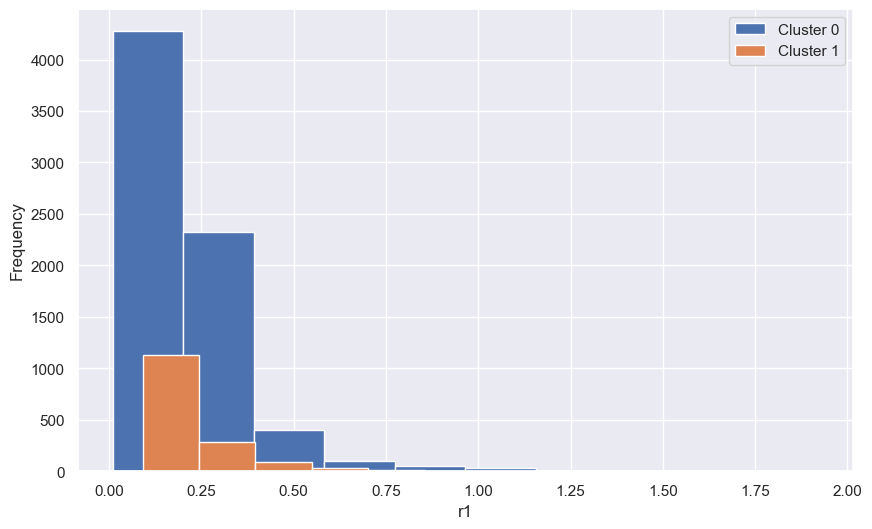

r2


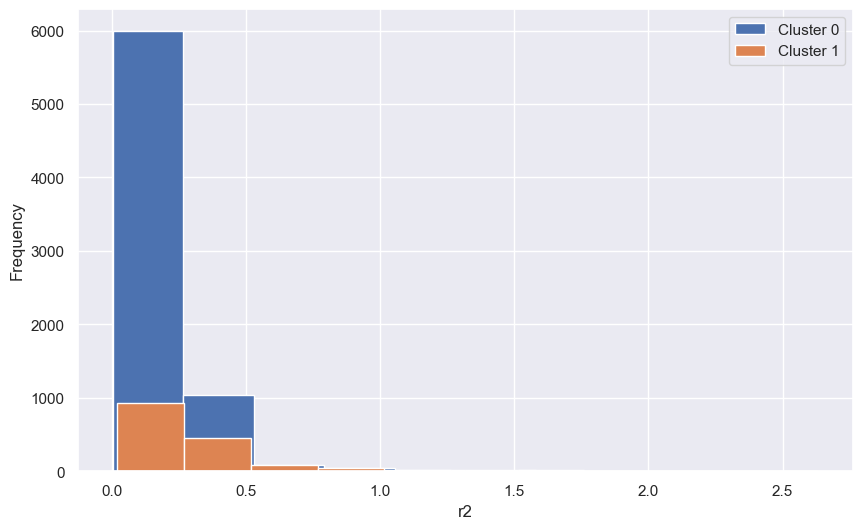

r3


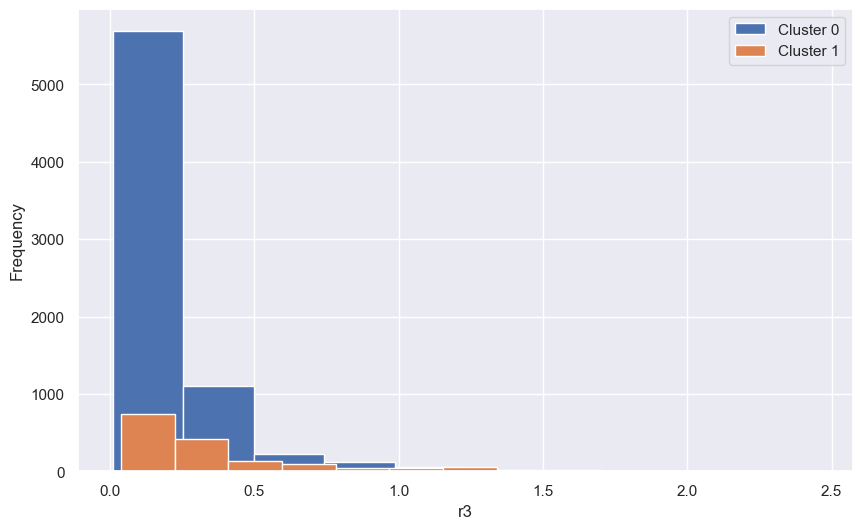

r4


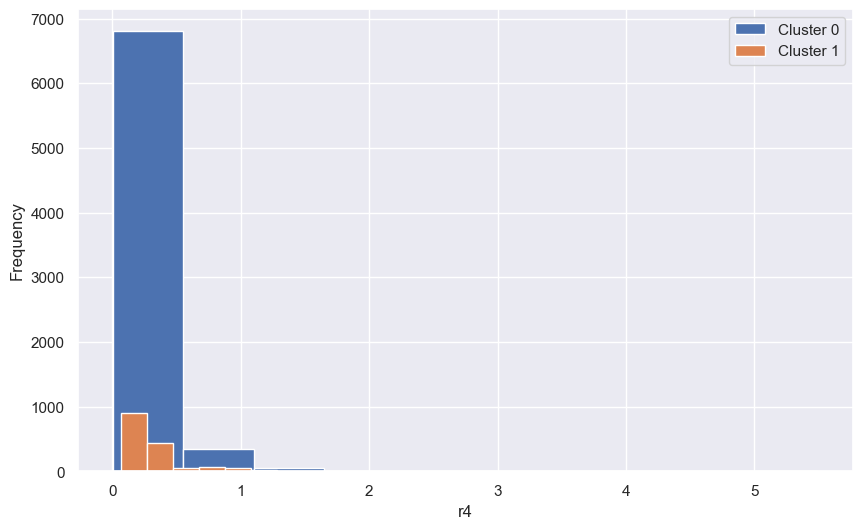

r5


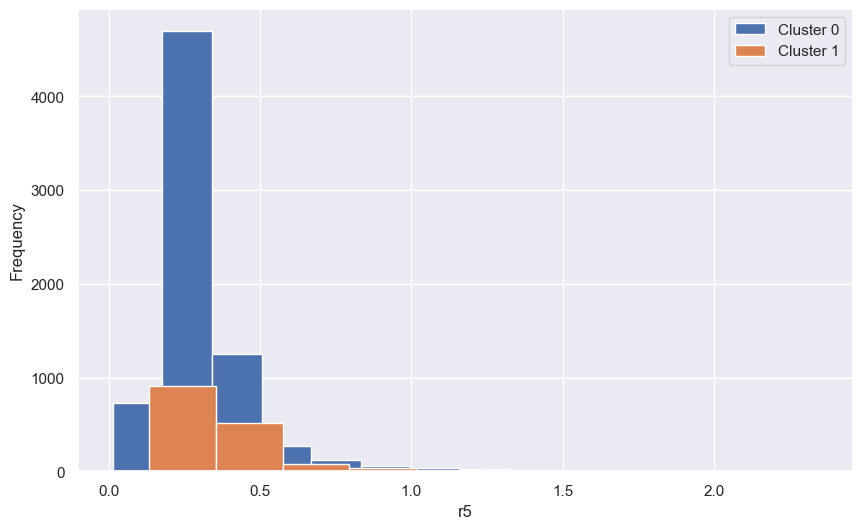

r6


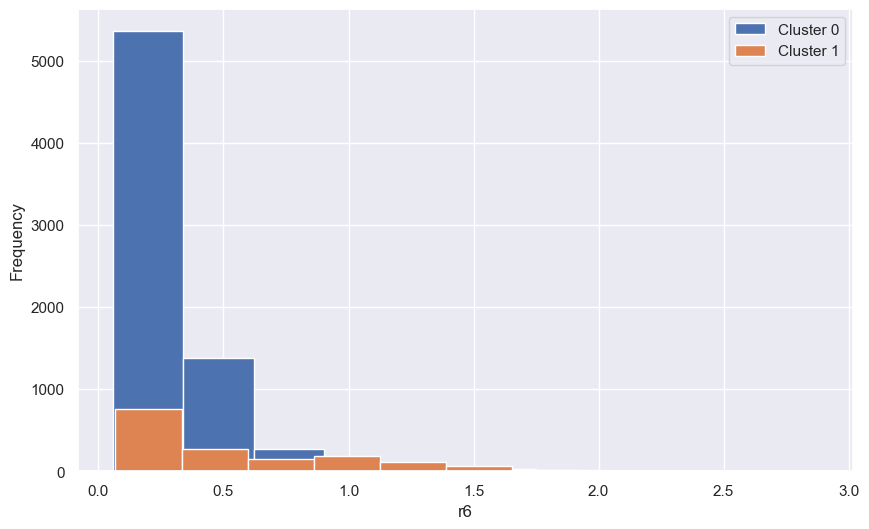

r7


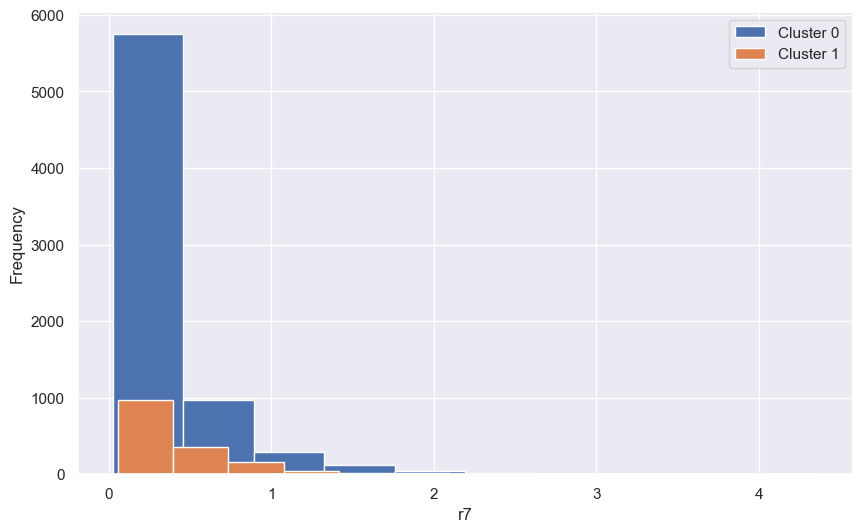

r8


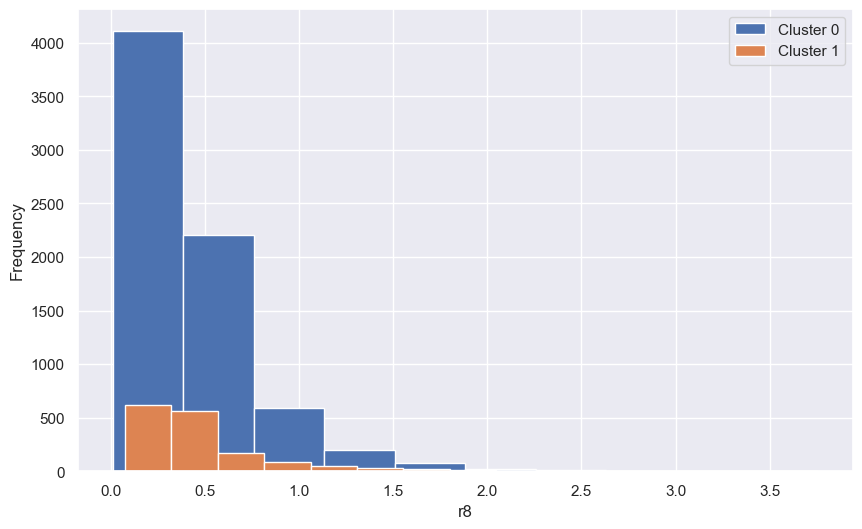

r9


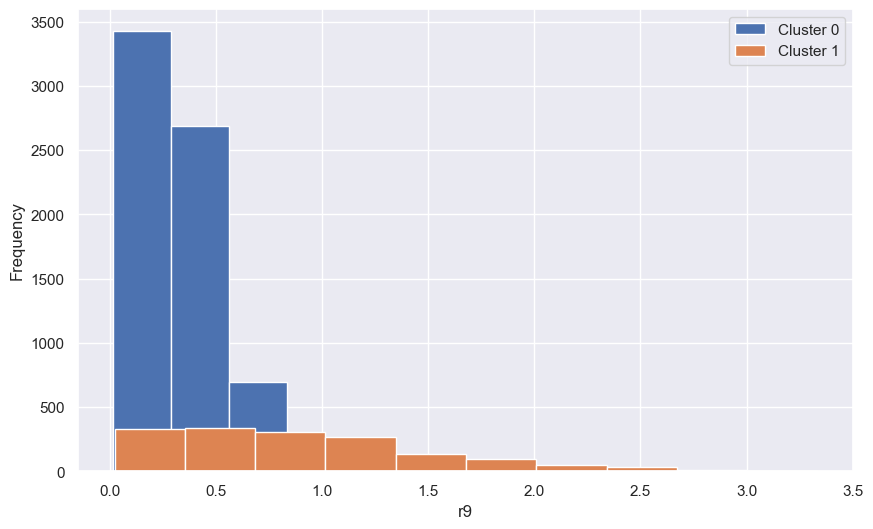

r10


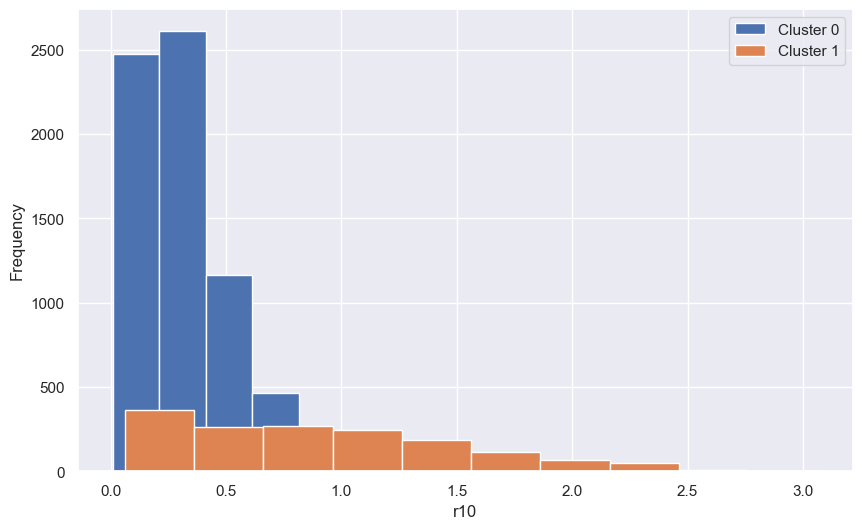

r11


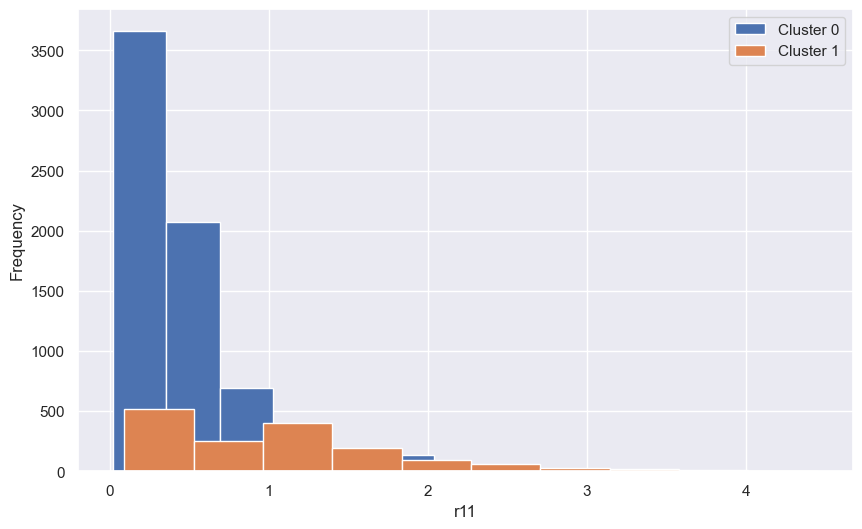

r12


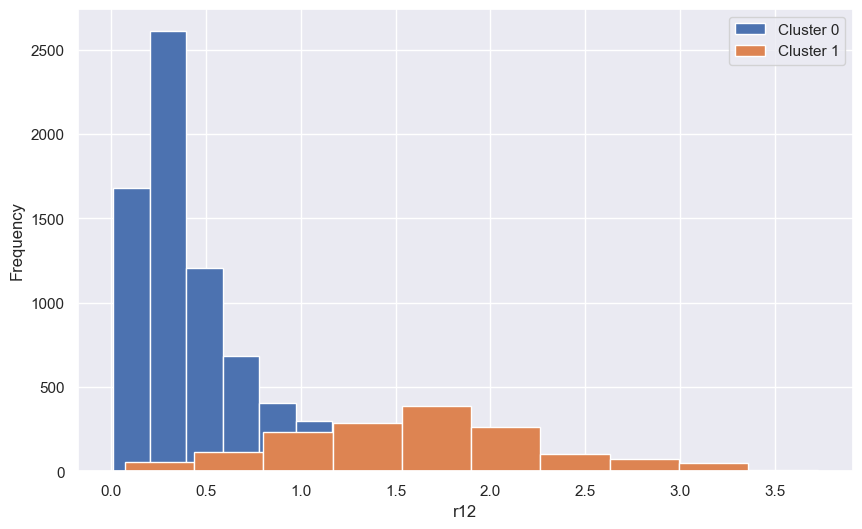

Season


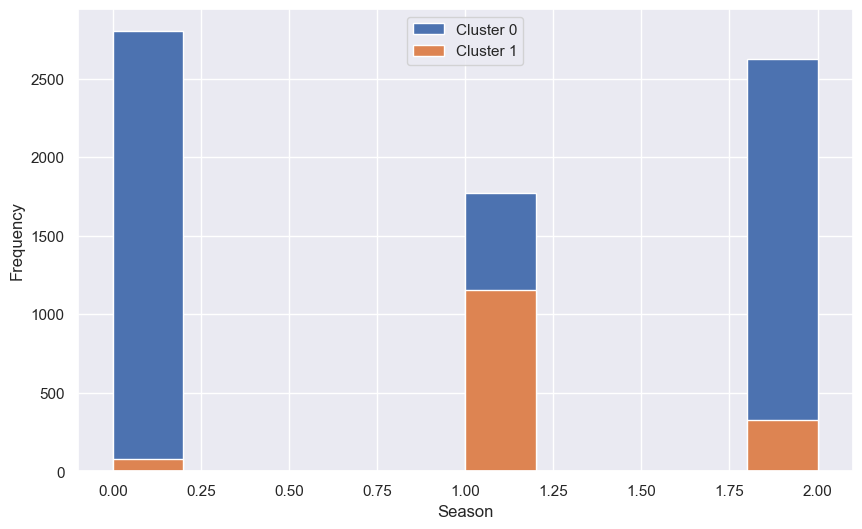

cluster_label


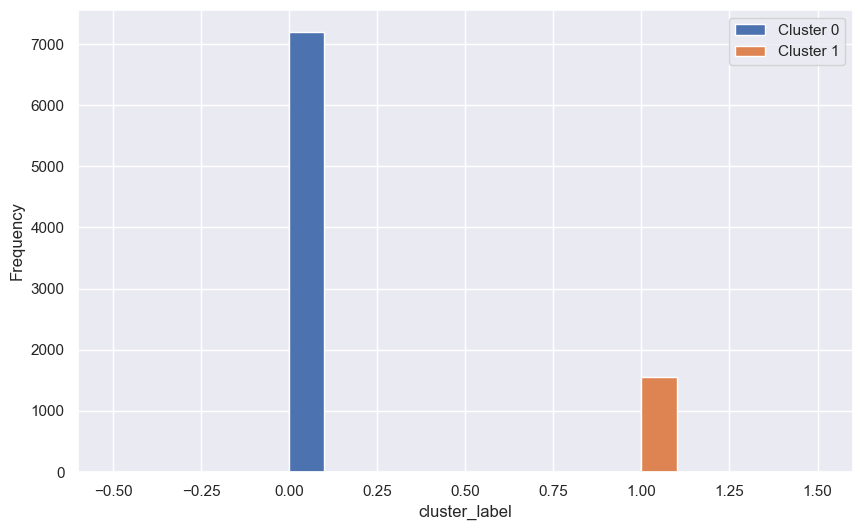

In [119]:
#OVERALL ANALYSIS OF CLUSTERS WITH OTHER FEATURES
for feature in d_f.columns:
    print(feature)
    plt.figure()
    for cluster_label, cluster_data in d_f.groupby('cluster_label'):
        plt.hist(cluster_data[feature], label=f'Cluster {cluster_label}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [84]:
#PCA
covariance_matrix = np.cov(df_r, rowvar=False)
covariance_matrix

array([[ 0.00536557, -0.00010542,  0.00033876,  0.00025764,  0.00043869,
         0.0006347 ,  0.00086361,  0.00122611,  0.0004123 ,  0.0012647 ,
         0.00041656, -0.00031297],
       [-0.00010542,  0.00561618,  0.00037685,  0.00025499,  0.00023074,
         0.00086504,  0.00045414,  0.00032677,  0.00106722,  0.00124816,
         0.0015812 ,  0.00272287],
       [ 0.00033876,  0.00037685,  0.007639  ,  0.00024893,  0.00069476,
         0.00227233,  0.00075662,  0.0003209 ,  0.00226557,  0.00203466,
         0.00153098,  0.00270479],
       [ 0.00025764,  0.00025499,  0.00024893,  0.00136944,  0.00036414,
         0.00040011,  0.00040938,  0.00055097,  0.0003599 ,  0.00080857,
         0.00081311,  0.0010383 ],
       [ 0.00043869,  0.00023074,  0.00069476,  0.00036414,  0.00506211,
         0.00134214,  0.00051248,  0.00085689,  0.00204031,  0.00116435,
         0.00073243,  0.0010427 ],
       [ 0.0006347 ,  0.00086504,  0.00227233,  0.00040011,  0.00134214,
         0.0109689 ,  

In [85]:
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
num_components = 3
top_k_eigenvectors = eigenvectors[:, :num_components]
reduced_data = np.dot(df_r, top_k_eigenvectors)
reduced_data.shape,reduced_data

((8760, 3),
 array([[-0.201088  , -0.09478783, -0.20196312],
        [-0.22631263,  0.01261888, -0.03339178],
        [-0.37654314,  0.22942116, -0.17724051],
        ...,
        [-0.09802025,  0.0387545 , -0.026346  ],
        [-0.13022479, -0.01182458, -0.07756836],
        [-0.11281082,  0.01194853, -0.00349117]]))

In [86]:
ax.plot(reduced_data[:, 0], label='Principal Component 1')
ax.plot(reduced_data[:, 1], label='Principal Component 2')
ax.plot(reduced_data[:, 2], label='Principal Component 3')

# Set plot title and labels
ax.set_title('PCA: Reduced Data')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Principal Component Values')
ax.legend()

# Show the plot
plt.show()

In [87]:
plt.figure(figsize=(8, 6))
for cluster_id in set(cluster_labels):
    cluster_points = df_r[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}')


InvalidIndexError: (slice(None, None, None), 0)

<Figure size 800x600 with 0 Axes>

In [ ]:
#TSNE 

In [125]:
features = df_r.values
features

array([[0.06460233, 0.23541286, 0.02921892, ..., 0.04795755, 0.25419177,
        0.06637251],
       [0.07513361, 0.17934948, 0.0361036 , ..., 0.13794346, 0.04502065,
        0.1409777 ],
       [0.15487792, 0.27936472, 0.03614458, ..., 0.48281849, 0.0308036 ,
        0.10040625],
       ...,
       [0.07309022, 0.04985527, 0.01692484, ..., 0.05526255, 0.02168664,
        0.04022169],
       [0.07319501, 0.0407145 , 0.01544955, ..., 0.04327317, 0.10294947,
        0.06010385],
       [0.07251388, 0.0410192 , 0.00758135, ..., 0.04058702, 0.02105477,
        0.07716108]])

In [126]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne1 = tsne.fit_transform(features)
X_tsne1


C:\Users\AVDEV03\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\AVDEV03\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[ 31.801931, -32.408466],
       [ 45.460682,  23.90922 ],
       [-65.7736  , -25.507566],
       ...,
       [ 31.136288,  82.50206 ],
       [ 21.447462,  81.532394],
       [ 31.51402 ,  82.16715 ]], dtype=float32)

In [ ]:
plt.scatter(X_tsne1[:, 0], X_tsne1[:, 1], cmap='viridis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.colorbar(label='Cluster Label')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1],c = df['season'])
# Use colors to represent labels if available
plt.colorbar(ticks=range(10))
plt.title('t-SNE Visualization')
plt.show()

In [ ]:
# Calculate the Euclidean distance of each point to its nearest neighbors
distances = np.linalg.norm(embedded_data - np.mean(features1, axis=0), axis=1)

# Set a threshold to define outliers
threshold = np.percentile(distances, 95)  # Adjust the percentile as needed

# Identify outliers based on the distance threshold
outliers = df[distances > threshold]

# Plot the t-SNE embeddings and highlight outliers
plt.scatter(embedded_data[:, 0], embedded_data[:, 1], label='Normal')
plt.scatter(embedded_data[outliers.index, 0], embedded_data[outliers.index, 1], color='red', label='Outliers')
plt.title("t-SNE Visualization with Outliers")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
for cluster_id in df_R['cluster'].unique():
    cluster_data = df_R[df_R['cluster'] == cluster_id]
    for column in cluster_data.columns[:-1]:  # Exclude the cluster label column
        plt.plot(cluster_data[column], label=f'Cluster {cluster_id}')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Clustered Time Series')
plt.legend()
plt.show()

In [ ]:

# Get the cluster labels assigned to each time series
cluster_labels = kmeans.labels_

# Assign the cluster labels back to the original data
data['cluster'] = cluster_labels

# Explore the results
for cluster_id in data['cluster'].unique():
    cluster_data = data[data['cluster'] == cluster_id]
    print(f"Cluster {cluster_id} has {len(cluster_data)} time series.")

# Visualize the clustered time series
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for cluster_id in data['cluster'].unique():
    cluster_data = data[data['cluster'] == cluster_id]
    for column in cluster_data.columns[:-1]:  # Exclude the cluster label column
        plt.plot(cluster_data[column], label=f'Cluster {cluster_id}')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Clustered Time Series')
plt.legend()
plt.show()

In [ ]:
##DBSCAN clustering - not useful for temporal 

In [120]:
#hyperparameter tuning,to select specific epsilon and sample_value
eps_values = [0.1, 0.3, 0.5, 0.7, 1.0]
min_samples_values = [3, 5, 7, 10]

best_eps = None
best_min_samples = None
best_silhouette_score = -1


In [89]:
for eps in eps_values:
    for min_samples in min_samples_values:
        
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(df_r)

        if len(set(clusters)) > 1:  
            silhouette = silhouette_score(df_r, clusters)
        else:
            silhouette = -1
        
        if silhouette > best_silhouette_score:
            best_silhouette_score = silhouette
            best_eps = eps
            best_min_samples = min_samples

In [121]:
best_silhouette_score,best_eps,best_min_samples
#not suitable for this dataset


(-1, None, None)

In [123]:
dbscan = DBSCAN(eps=0.7, min_samples=3)
clusters = dbscan.fit_predict(df_r)
clusters.max(),clusters.min()
#not working -  this method

(0, -1)